# Diptera wing classification using Topological Data Analysis

Guilherme Vituri F. Pinto [](https://orcid.org/0000-0002-7813-8777) (Universidade Estadual Paulista)  
Sergio UraNorthonFebruary 26, 2026

We apply tools from Topological Data Analysis (TDA) to classify Diptera families based on wing venation patterns. Using three complementary filtration strategies — Vietoris-Rips on point clouds, radial filtrations, and directional (height) filtrations on wing images — we extract H0 and H1 topological features via extended summary statistics and compare classifiers via leave-one-out cross-validation. We focus on interpretable models (LDA, Decision Trees) to identify explainable topological criteria that distinguish families.

In [1]:
using TDAfly, TDAfly.Preprocessing, TDAfly.TDA, TDAfly.Analysis
using Images: mosaicview, Gray
using Plots: plot, display, heatmap, scatter, bar, bar!, default
using StatsPlots: boxplot
using PersistenceDiagrams
using PersistenceDiagrams: BettiCurve, Landscape, PersistenceImage
using DataFrames
using Distances: euclidean
using LIBSVM
using StatsBase: mean

# Use raster plots for notebook frontends that may mis-render large SVG outputs.
default(fmt = :png, dpi = 180)

In [2]:
2

2

## 1 Introduction

The order Diptera (true flies) comprises over 150,000 described species across more than 150 families. Wing venation patterns are a classical diagnostic character in Diptera systematics: the arrangement, branching and connectivity of veins varies markedly across families and provides a natural morphological signature.

In this work, we apply **Topological Data Analysis (TDA)** to the problem of classifying Diptera families from wing images. TDA provides a framework for extracting shape descriptors that are robust to continuous deformations — exactly the kind of invariance desirable when comparing biological structures that vary in scale, orientation and minor deformations across individuals.

We employ two complementary filtration strategies:

1.  **Vietoris-Rips filtration** on point-cloud samples of wing silhouettes — captures global loop structure
2.  **Radial filtration** from the wing centroid to the periphery — captures how vein topology is organized from center outward

For each filtration, we compute both **H0** (connected components / vein branching) and **H1** (loops / enclosed cells) persistence, then extract extended summary statistics (17 interpretable features per diagram after dropping skewness and kurtosis) and classify using simple, explainable models (LDA, Decision Trees, Random Forests). The goal is to find interpretable topological criteria for family identification.

> **Why only two filtrations?**
>
> We initially tested five filtration strategies including directional height filtrations (8 directions), Euclidean Distance Transform (EDT), and grayscale cubical filtrations. However: **(a)** directional filtrations are noise-sensitive — in images with isolated pixels and incomplete vein segmentation, each sweep direction creates spurious topological features; **(b)** EDT produces trivial persistence on binarized images where veins are ~1 pixel wide; **(c)** cubical (grayscale) filtrations are meaningless on already-binarized black-and-white images. See `NOTES.md` for details on discarded methods.

## 2 Methods

### 2.1 Data loading and preprocessing

All images are in the `images/processed` directory. For each image, we load it, apply a Gaussian blur (to close small gaps in the wing membrane and keep it connected), crop to the bounding box, and resize to 150 pixels of height.

In [3]:
all_paths = readdir("images/processed", join = true)
all_filenames = basename.(all_paths) .|> (x -> replace(x, ".png" => ""))

function extract_family(name)
    family_raw = lowercase(split(name, r"[\s\-]")[1])
    if family_raw in ("bibionidae", "biobionidae")
        return "Bibionidae"
    elseif family_raw in ("sciaridae", "scaridae")
        return "Sciaridae"
    elseif family_raw == "simulidae"
        return "Simuliidae"
    else
        return titlecase(family_raw)
    end
end

function canonical_id(name)
    family = extract_family(name)
    parts = split(name, r"[\s\-]")
    number = parts[end]
    "$(family)-$(number)"
end

# Deduplicate (space vs hyphen variants of the same file)
seen = Set{String}()
keep_idx = Int[]
for (i, fname) in enumerate(all_filenames)
    cid = canonical_id(fname)
    if !(cid in seen)
        push!(seen, cid)
        push!(keep_idx, i)
    end
end

paths = all_paths[keep_idx]
species = all_filenames[keep_idx]
families = extract_family.(species)

individuals = map(species) do specie
    parts = split(specie, r"[\s\-]")
    string(extract_family(specie)[1]) * "-" * parts[end]
end

println("Total images after deduplication: $(length(paths))")
println("Families: ", sort(unique(families)))
println("\nSamples per family:")
for f in sort(unique(families))
    println("  $(f): $(count(==(f), families))")
end

Total images after deduplication: 70
Families: ["Asilidae", "Bibionidae", "Ceratopogonidae", "Chironomidae", "Rhagionidae", "Sciaridae", "Simuliidae", "Tabanidae", "Tipulidae"]

Samples per family:
  Asilidae: 8
  Bibionidae: 6
  Ceratopogonidae: 8
  Chironomidae: 8
  Rhagionidae: 4
  Sciaridae: 6
  Simuliidae: 7
  Tabanidae: 11
  Tipulidae: 12

#### 2.1.1 Excluding small families

Families with fewer than 3 samples (e.g. Pelecorhynchidae with $n=2$) can distort cross-validation results—a single misclassification changes accuracy by 50%. We provide a filtered version and run the analysis both ways.

In [4]:
MIN_FAMILY_SIZE = 3
family_counts = Dict(f => count(==(f), families) for f in unique(families))
small_families = [f for (f, c) in family_counts if c < MIN_FAMILY_SIZE]

if !isempty(small_families)
    println("Families with < $MIN_FAMILY_SIZE samples (excluded from filtered analysis):")
    for f in sort(small_families)
        println("  $(f): $(family_counts[f]) samples")
    end
end

# Build filtered indices
keep_filtered = [i for i in eachindex(families) if family_counts[families[i]] >= MIN_FAMILY_SIZE]
paths_filtered = paths[keep_filtered]
species_filtered = species[keep_filtered]
families_filtered = families[keep_filtered]
individuals_filtered = individuals[keep_filtered]

println("\nFiltered dataset: $(length(keep_filtered)) samples, $(length(unique(families_filtered))) families")


Filtered dataset: 70 samples, 9 families

In [5]:
wings = load_wing.(paths, blur = 1.8)
Xs = map(wings) do w
    image_to_r2(w; threshold=0.08, ensure_connected = true, connectivity = 8)
end;


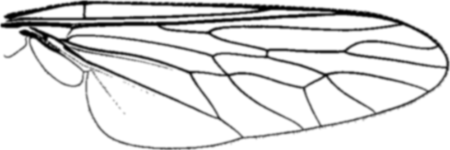

In [6]:
wings[1]


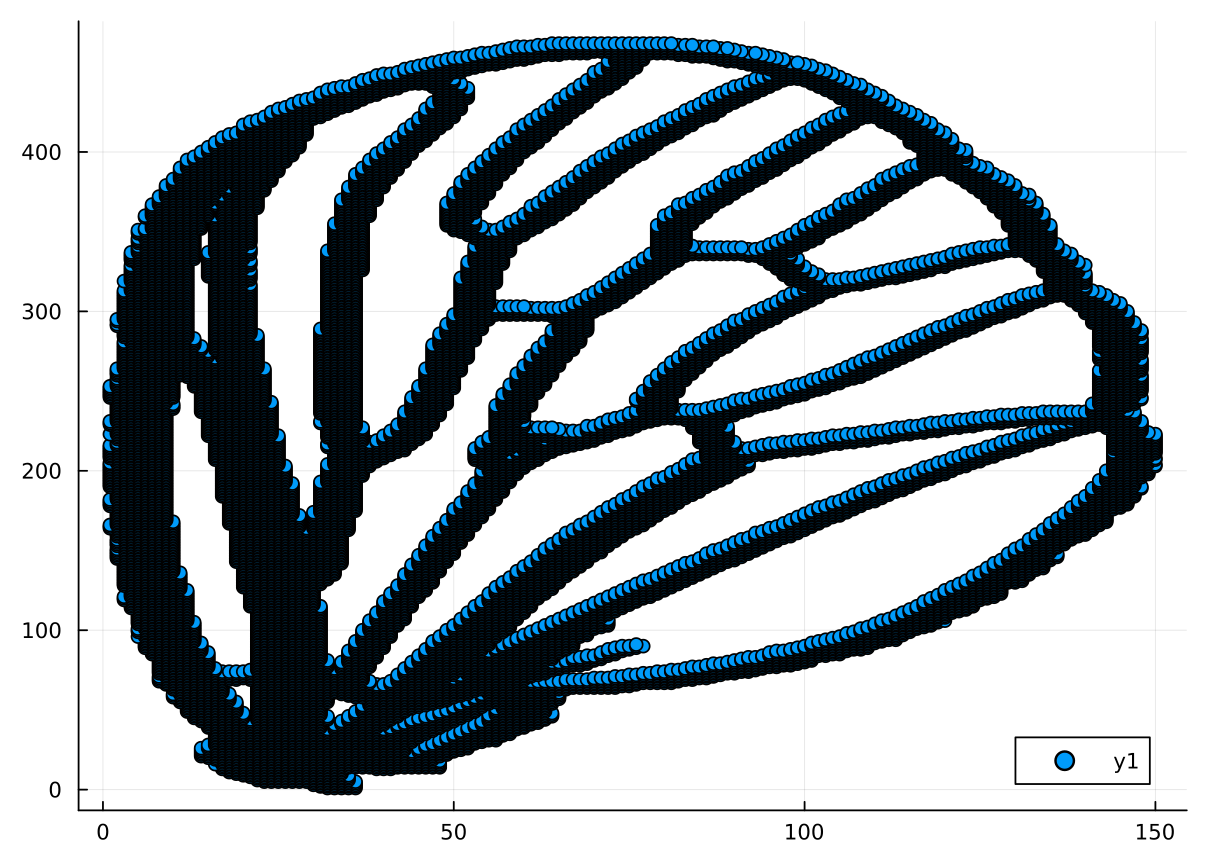

In [7]:
scatter(Xs[5] .|> first, Xs[5] .|> last)


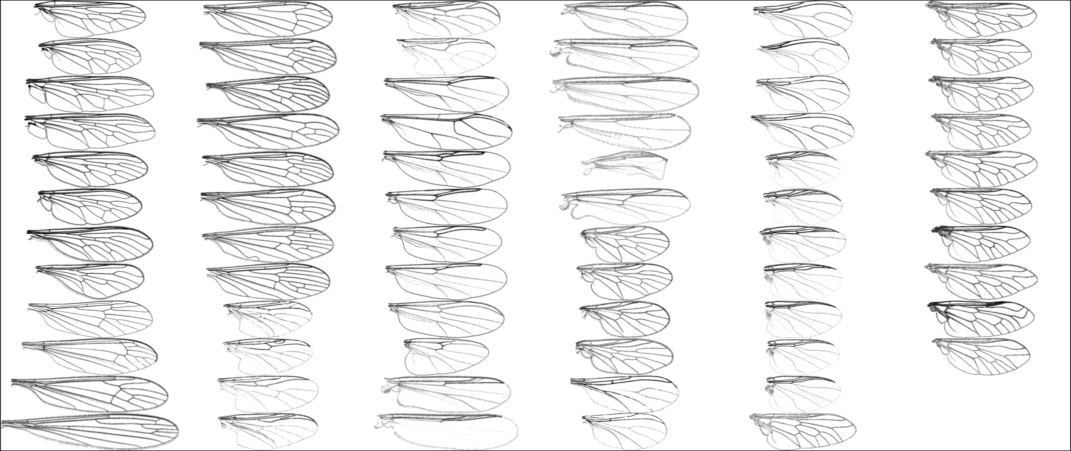

In [8]:
mosaicview(wings, ncol = 6, fillvalue = 1)

### 2.2 Example: forcing connectivity on 5 wings

The chunk below selects 5 wings (prioritizing those with the largest number of disconnected components before correction), then compares the binary pixel set before and after `connect_pixel_components`.


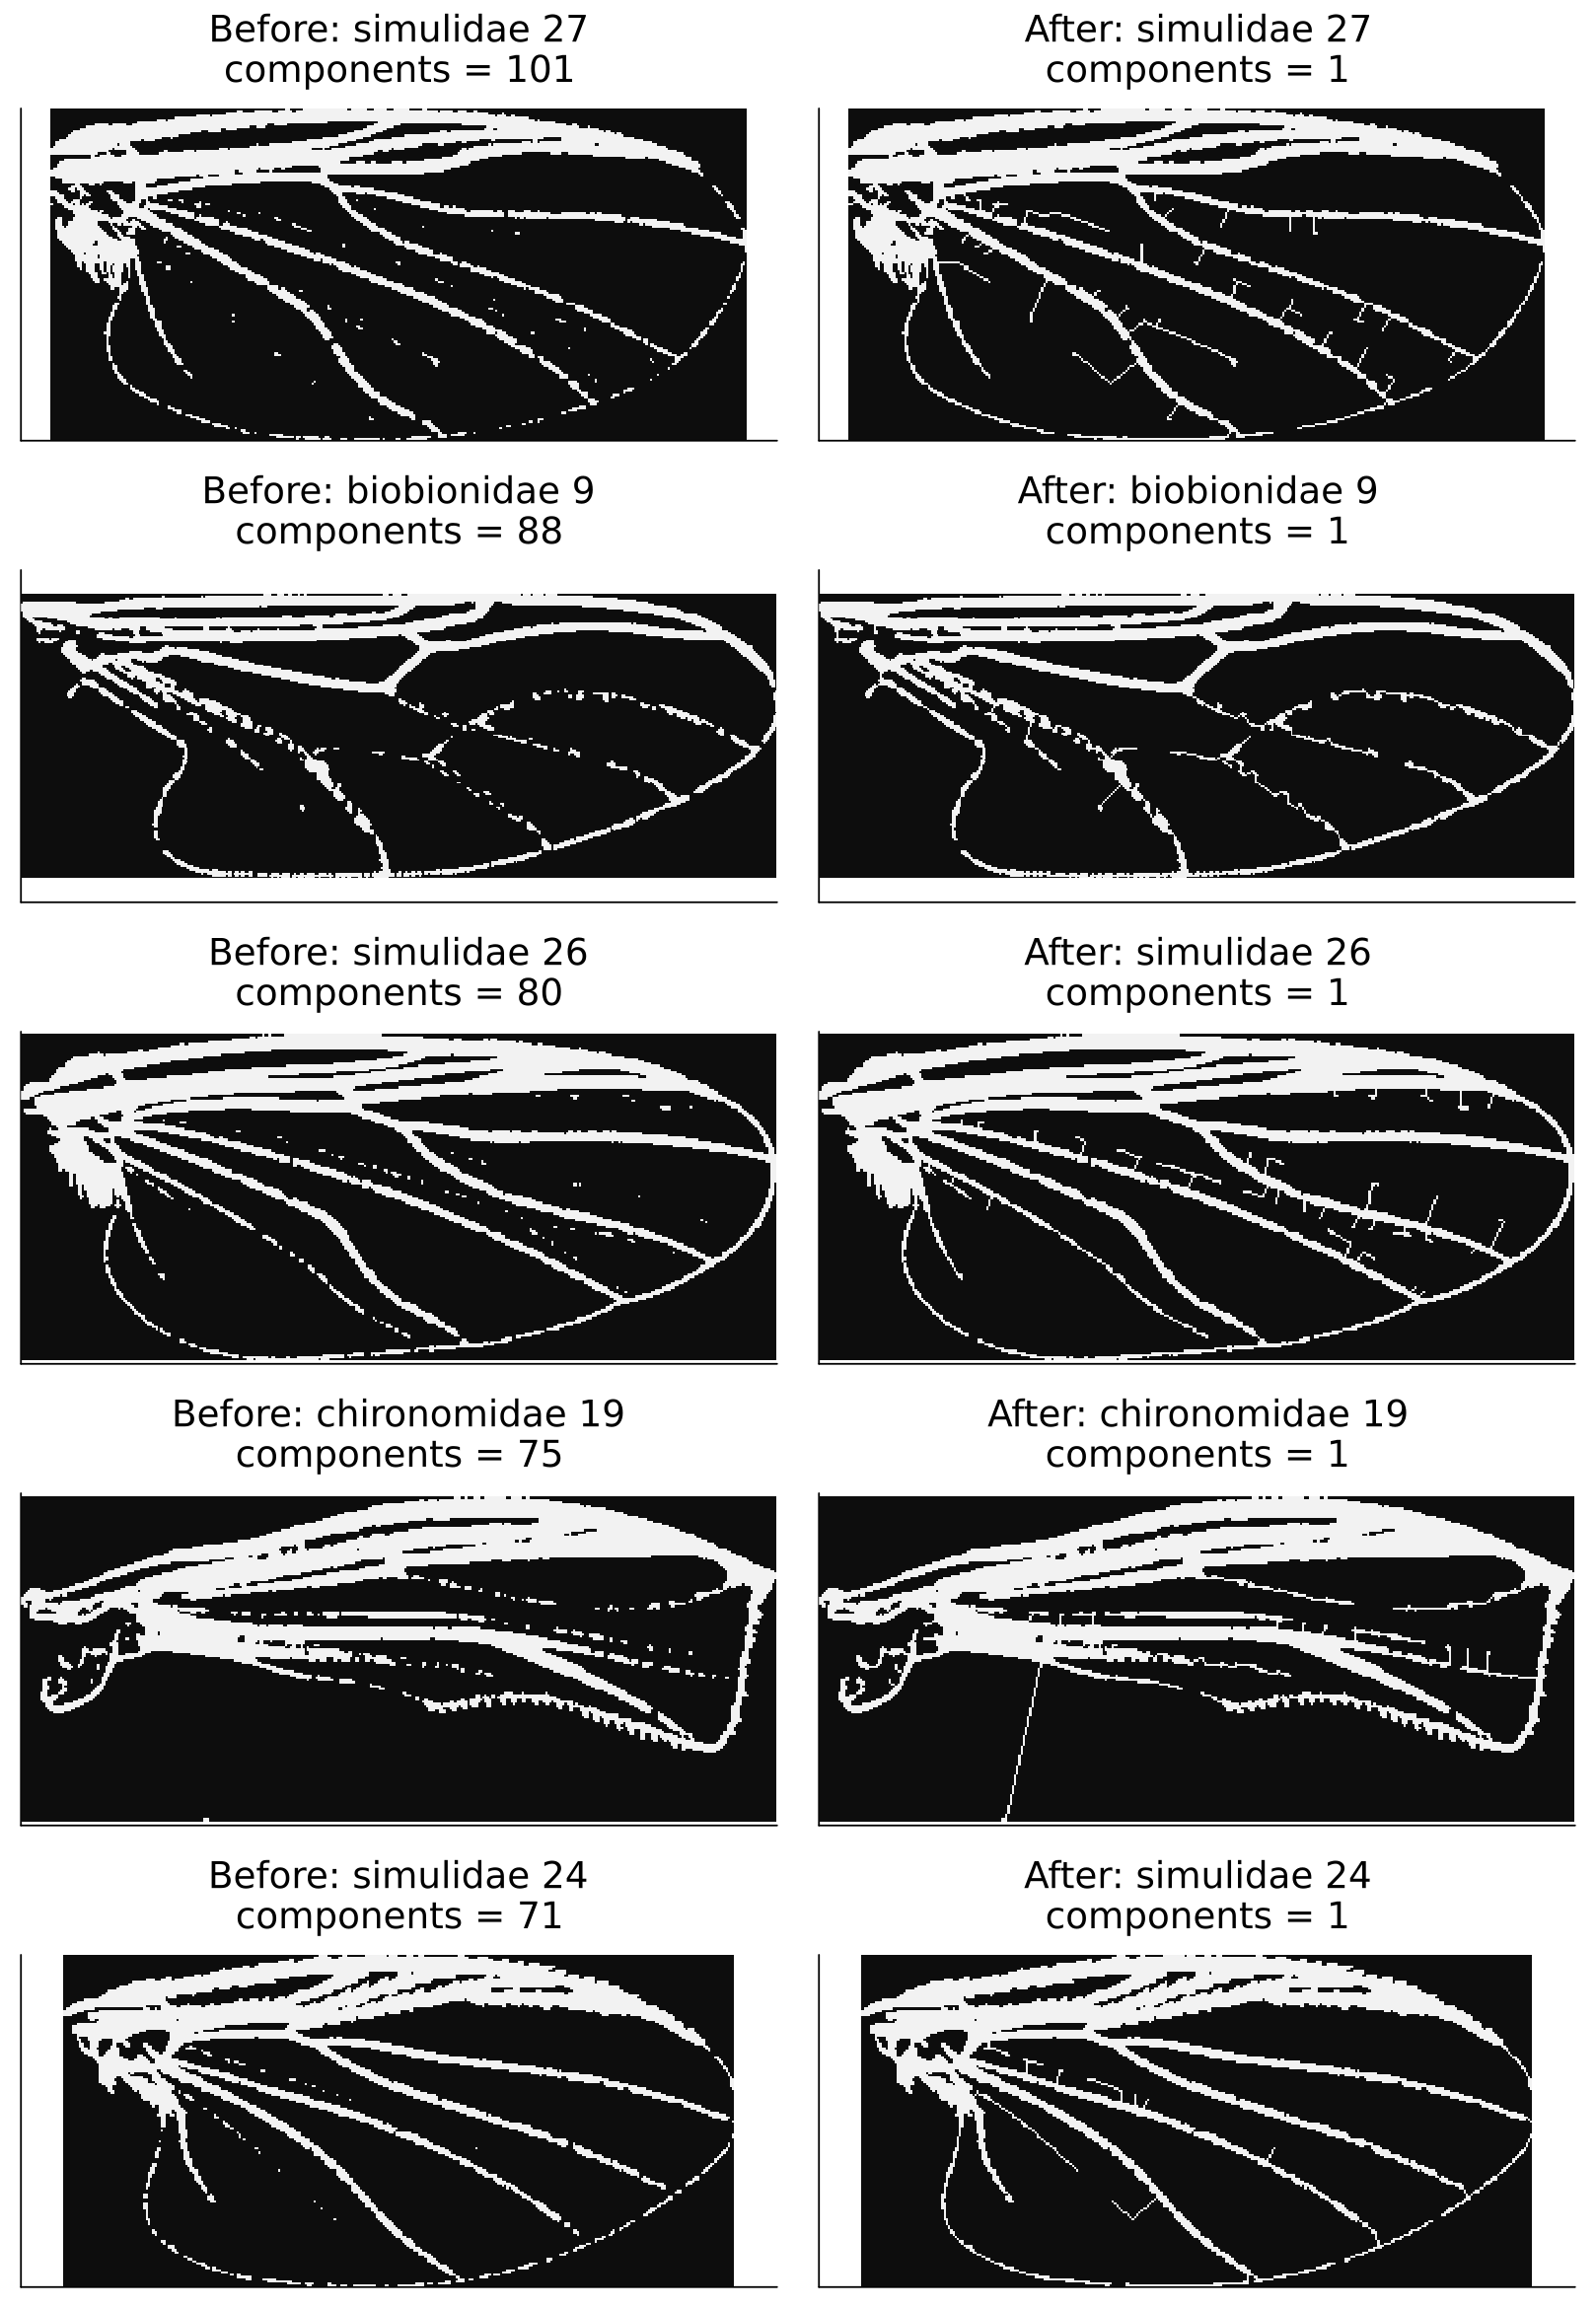

In [9]:
threshold_conn = 0.1
conn = 8

component_count_before = map(wings) do w
    ids0 = findall_ids(>(threshold_conn), image_to_array(w))
    length(pixel_components(ids0; connectivity = conn))
end

demo_idx = sortperm(component_count_before, rev = true)[1:min(5, length(wings))]

function ids_to_mask(ids)
    isempty(ids) && return zeros(Float32, 1, 1)
    xs = first.(ids)
    ys = last.(ids)
    M = zeros(Float32, maximum(xs), maximum(ys))
    for p in ids
        M[p[1], p[2]] = 1f0
    end
    M
end

demo_connectivity_df = DataFrame(
    sample = String[],
    n_components_before = Int[],
    n_components_after = Int[],
    n_pixels_before = Int[],
    n_pixels_after = Int[],
)

panel_plots = Any[]
for idx in demo_idx
    ids_before = findall_ids(>(threshold_conn), image_to_array(wings[idx]))
    ids_after = connect_pixel_components(ids_before; connectivity = conn)

    n_before = length(pixel_components(ids_before; connectivity = conn))
    n_after = length(pixel_components(ids_after; connectivity = conn))

    push!(demo_connectivity_df, (
        species[idx],
        n_before,
        n_after,
        length(ids_before),
        length(ids_after),
    ))

    M_before = ids_to_mask(ids_before)
    M_after = ids_to_mask(ids_after)

    p_before = heatmap(
        M_before[end:-1:1, :],
        color = :grays,
        colorbar = false,
        legend = false,
        aspect_ratio = :equal,
        xticks = false,
        yticks = false,
        title = "Before: $(species[idx])\ncomponents = $(n_before)",
    )

    p_after = heatmap(
        M_after[end:-1:1, :],
        color = :grays,
        colorbar = false,
        legend = false,
        aspect_ratio = :equal,
        xticks = false,
        yticks = false,
        title = "After: $(species[idx])\ncomponents = $(n_after)",
    )

    push!(panel_plots, p_before)
    push!(panel_plots, p_after)
end

plot(panel_plots..., layout = (length(demo_idx), 2), size = (900, 260 * length(demo_idx)))

In [10]:
demo_connectivity_df

## 3 Topological feature extraction

We compute persistent homology using three filtration strategies. For the Vietoris-Rips filtration on connected point clouds, H0 is uninformative (single infinite bar), so we use only H1. For the radial filtration (computed via sublevel-set persistence on the pixel grid), we use only **H0**, which captures when disconnected vein segments merge as the radial sweep grows outward — directly encoding vein count and branching patterns. Radial H1 is omitted because pixelated binary images produce very few clean loops under this filtration. We also compute **directional (height) H0 persistence** in four sweep directions, capturing how vein connectivity changes along different axes.

> **What is persistent homology?**
>
> Persistent homology is the main tool of TDA. Given a shape or dataset, it tracks how topological features — connected components (dimension 0), loops (dimension 1), voids (dimension 2), etc. — appear and disappear as we “grow” the shape through a filtration parameter. Each feature has a **birth** time (when it appears) and a **death** time (when it gets filled in). The collection of all (birth, death) pairs is called a **persistence diagram**. Features with long lifetimes (high persistence = death $-$ birth) represent genuine topological structure, while short-lived features are typically noise.

### 3.1 Strategy 1: Vietoris-Rips filtration on point clouds

> **Vietoris-Rips filtration**
>
> Given a set of points in $\mathbb{R}^n$, the Vietoris-Rips complex at scale $\varepsilon$ connects any subset of points that are pairwise within distance $\varepsilon$. As $\varepsilon$ increases from 0, we obtain a nested sequence of simplicial complexes — the Rips filtration. This is the most common filtration in TDA for point-cloud data. It is computationally expensive (since it must consider all pairwise distances), which is why we subsample the point clouds.

We sample 750 points from each wing silhouette using farthest-point sampling (which ensures good coverage of the shape), then compute 1-dimensional Rips persistence:

In [11]:
samples = Vector{Any}(undef, length(Xs))
Threads.@threads for i in eachindex(Xs)
    samples[i] = farthest_points_sample(Xs[i], 750)
end

In [12]:
pds_rips = @showprogress map(samples) do s
    rips_pd_1d(s, cutoff = 5, threshold = 200)
end;

In [13]:
# Build connected binary arrays: same size as the loaded wing image,
# foreground pixels connected via Minimum Spanning Tree bridges.
# Values: 0.0 = foreground (dark veins), 1.0 = background — matching the
# format expected by height_filtration / radial_filtration (which check
# 1.0 - A[i,j] > threshold internally).
function make_connected_array(w; threshold = 0.08, connectivity = 8)
    rows, cols = size(w)
    ids = findall_ids(>(threshold), image_to_array(w))
    ids_conn = connect_pixel_components(ids; connectivity = connectivity)
    A = ones(Float64, rows, cols)
    for p in ids_conn
        A[p[1], p[2]] = 0.0
    end
    A
end

wing_arrays = [make_connected_array(w) for w in wings]

70-element Vector{Matrix{Float64}}:
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0;

### 3.2 Strategy 2: Radial filtration

> **Radial filtration**
>
> The **radial filtration** assigns each foreground pixel a value equal to its distance from the centroid of the wing. Sublevel-set persistence on this function captures how topological features are distributed from the center of the wing outward. This is complementary to the Rips filtration, which captures global loop structure without spatial information.

We compute H0 persistence for the radial filtration, capturing how disconnected vein segments merge as the radial sweep grows outward:

In [14]:
pds_radial_h0 = @showprogress "radial_pd_0d" map(wing_arrays) do A
    radial_pd_0d(A)
end;

### 3.3 Strategy 3: Directional (height) filtration

> **Directional filtration**
>
> The **directional (height) filtration** sweeps a hyperplane across the wing along a given direction. Each foreground pixel is assigned a value equal to its projection onto the sweep direction. As the sweep progresses, disconnected vein segments merge — captured by H0 persistence. We use four directions: horizontal `[1,0]`, vertical `[0,1]`, and both diagonals `[1,1]` and `[1,-1]`.

In [15]:
directions = [[1, 0], [0, 1], [1, 1], [1, -1]]
direction_names = ["horiz", "vert", "diag1", "diag2"]

pds_dir_h0 = Dict{String, Vector}()
for (dir, name) in zip(directions, direction_names)
    pds_dir_h0[name] = @showprogress "dir_h0_$name" map(wing_arrays) do A
        directional_pd_0d(A, dir)
    end
end;

### 3.4 Visualizing the radial filtration

The radial filtration assigns each foreground pixel a value proportional to its distance from the wing centroid. Below we visualize the radial filtration arrays and the resulting H0 persistence diagrams for one wing per family:


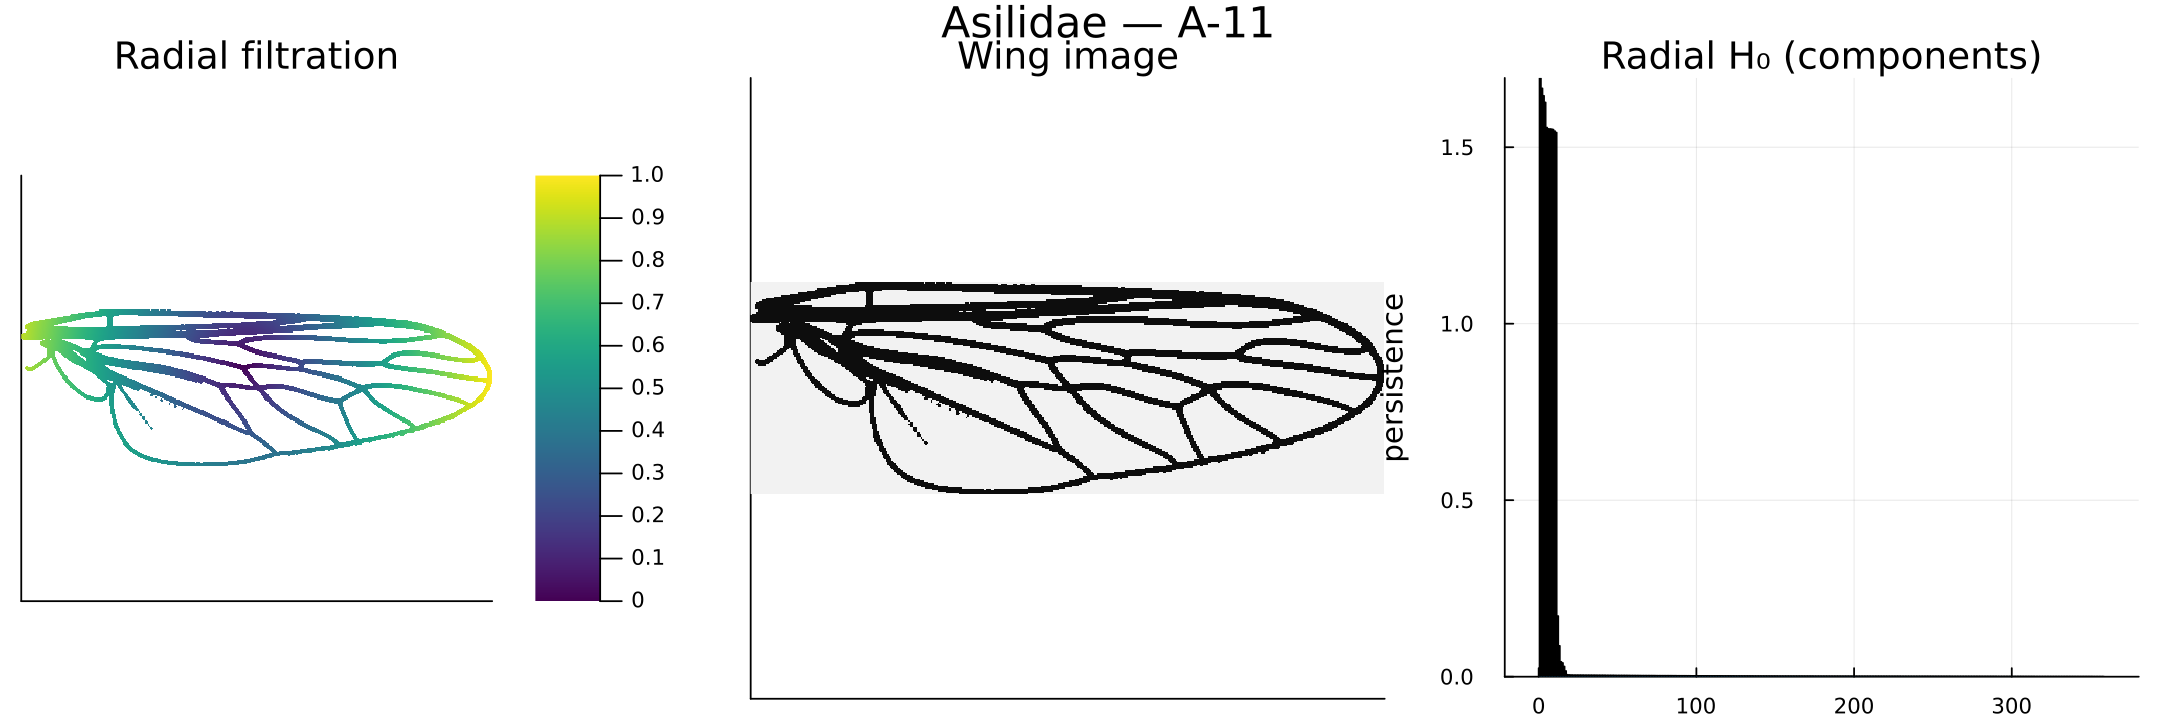


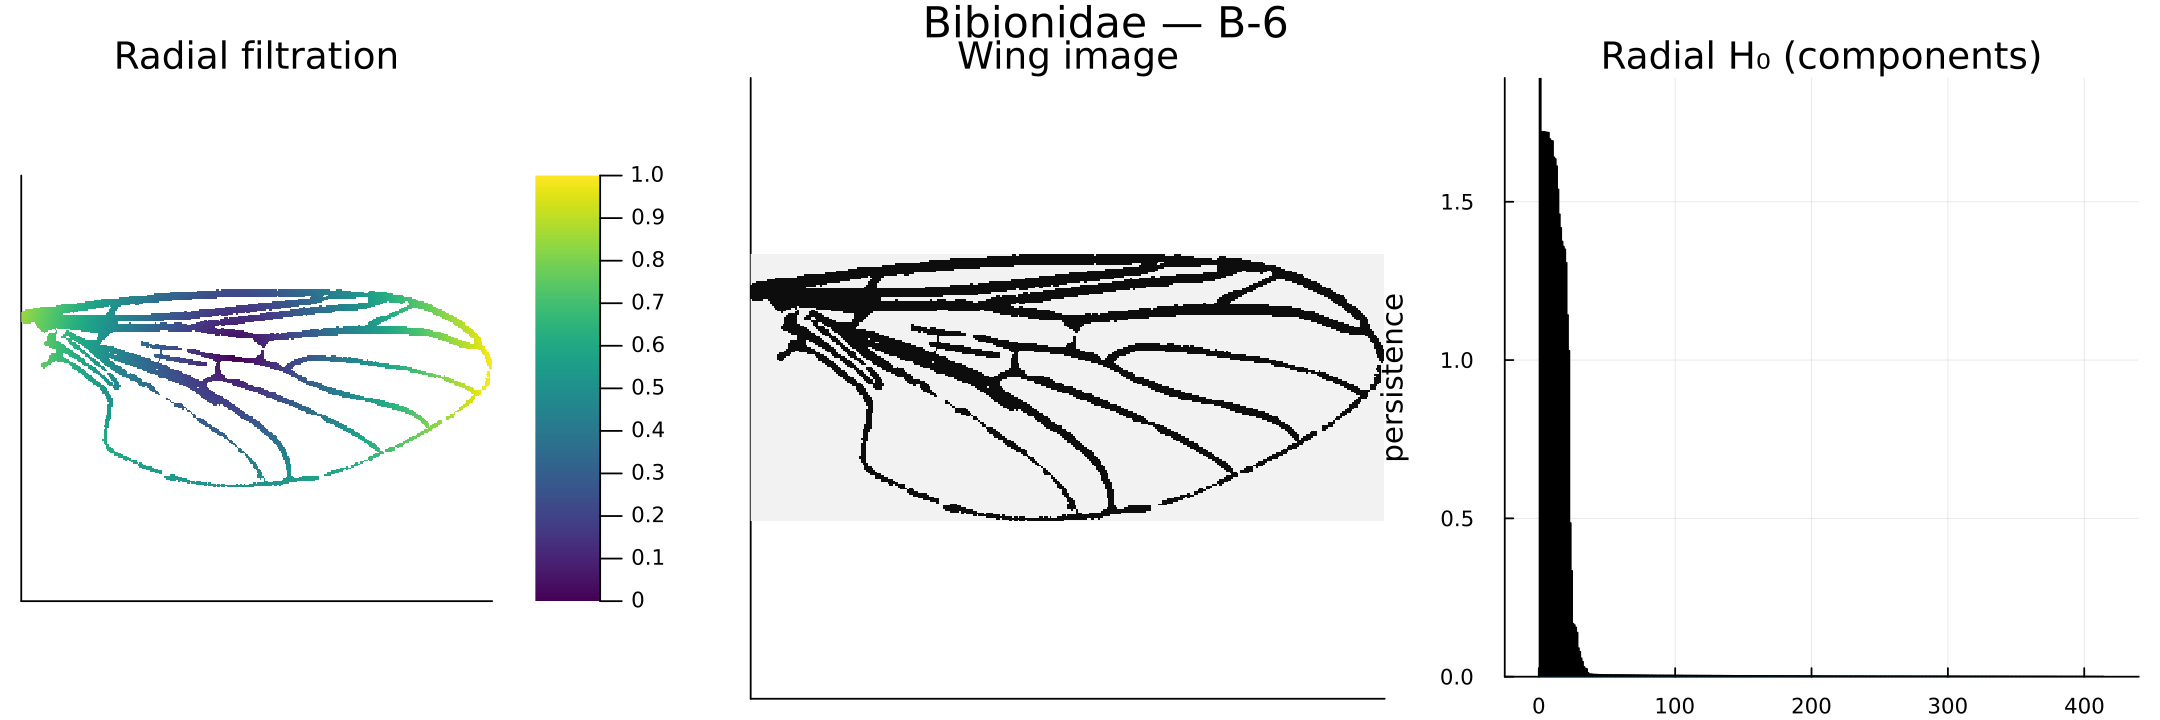


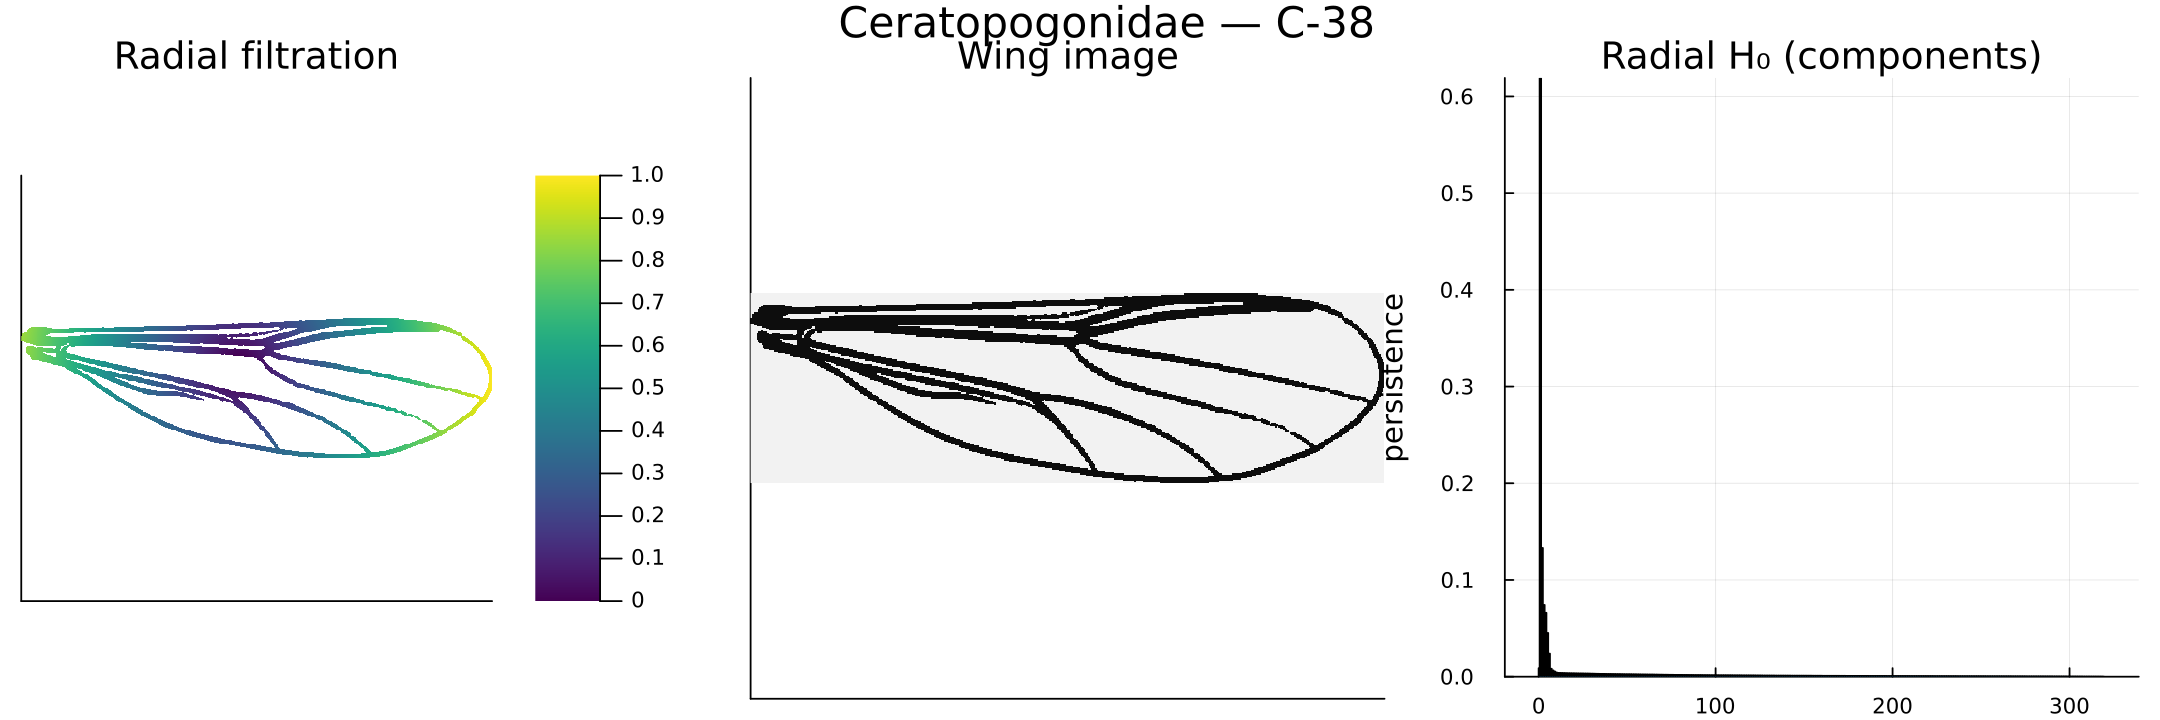


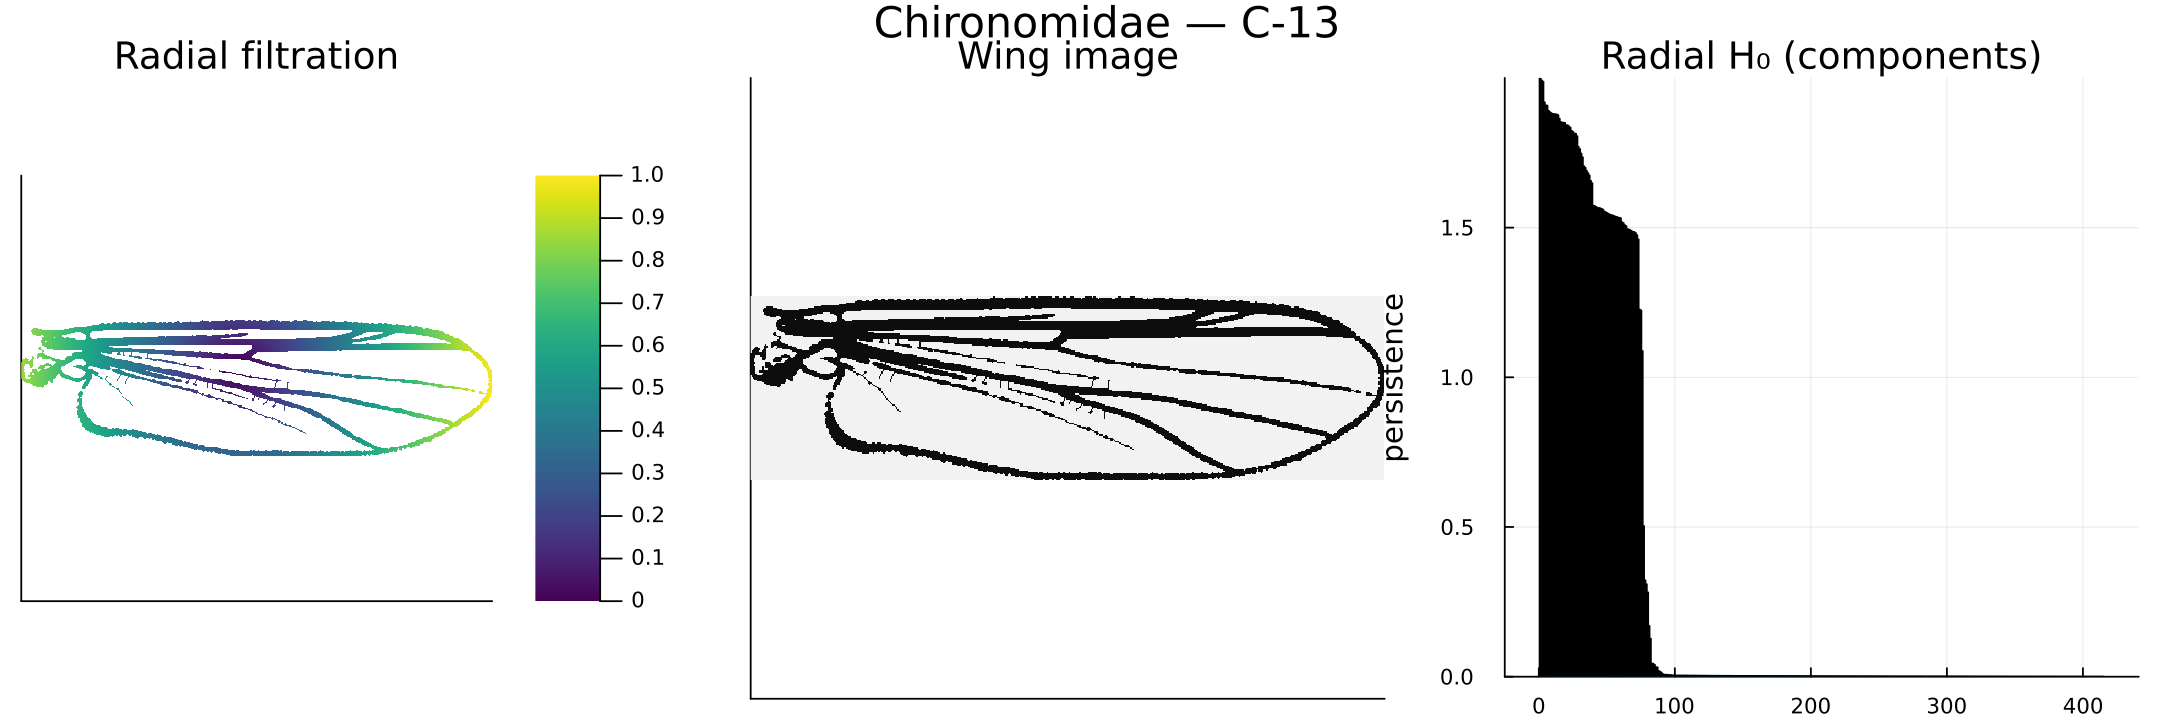


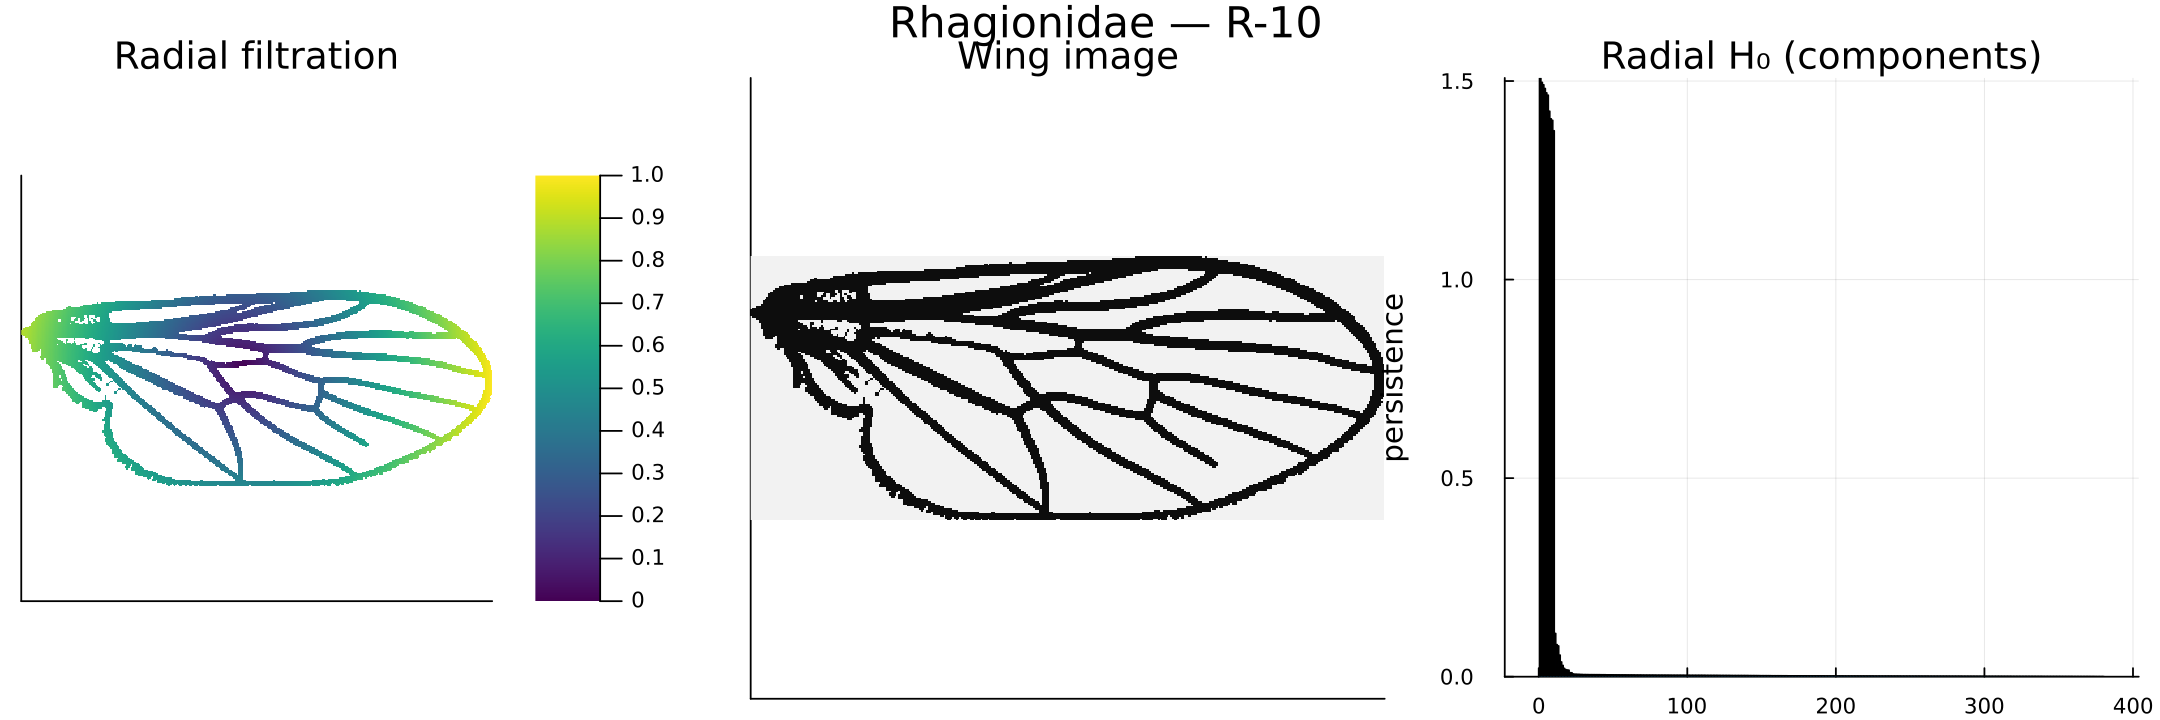

In [16]:
example_indices = [findfirst(==(f), families) for f in sort(unique(families))]

for i in example_indices[1:min(5, length(example_indices))]
    F_rad = radial_filtration(wing_arrays[i])

    # Only show foreground in the heatmap
    F_display = copy(F_rad)
    F_display[F_display .> 1.5] .= NaN  # mask background

    p1 = heatmap(F_display[end:-1:1, :],
                 color = :viridis, colorbar = true,
                 title = "Radial filtration",
                 aspect_ratio = :equal, xticks = false, yticks = false)

    p2 = heatmap(wing_arrays[i][end:-1:1, :],
                 color = :grays, colorbar = false,
                 title = "Wing image",
                 aspect_ratio = :equal, xticks = false, yticks = false)

    pers_rad_h0 = [persistence(x) for x in pds_radial_h0[i] if isfinite(persistence(x))]
    p3 = isempty(pers_rad_h0) ? plot(title = "Radial H₀ (empty)") :
         bar(sort(pers_rad_h0, rev = true), title = "Radial H₀ (components)",
             legend = false, ylabel = "persistence")

    p = plot(p1, p2, p3, layout = (1, 3), size = (1200, 400),
             plot_title = "$(families[i]) — $(individuals[i])")
    display(p)
end;

### 3.5 Radial filtration gallery: all families

Below we show all specimens organised by family. The top row shows the wing image (greyscale) and the bottom row shows the radial filtration (viridis colour scale, brighter = farther from centroid). Background pixels are masked.


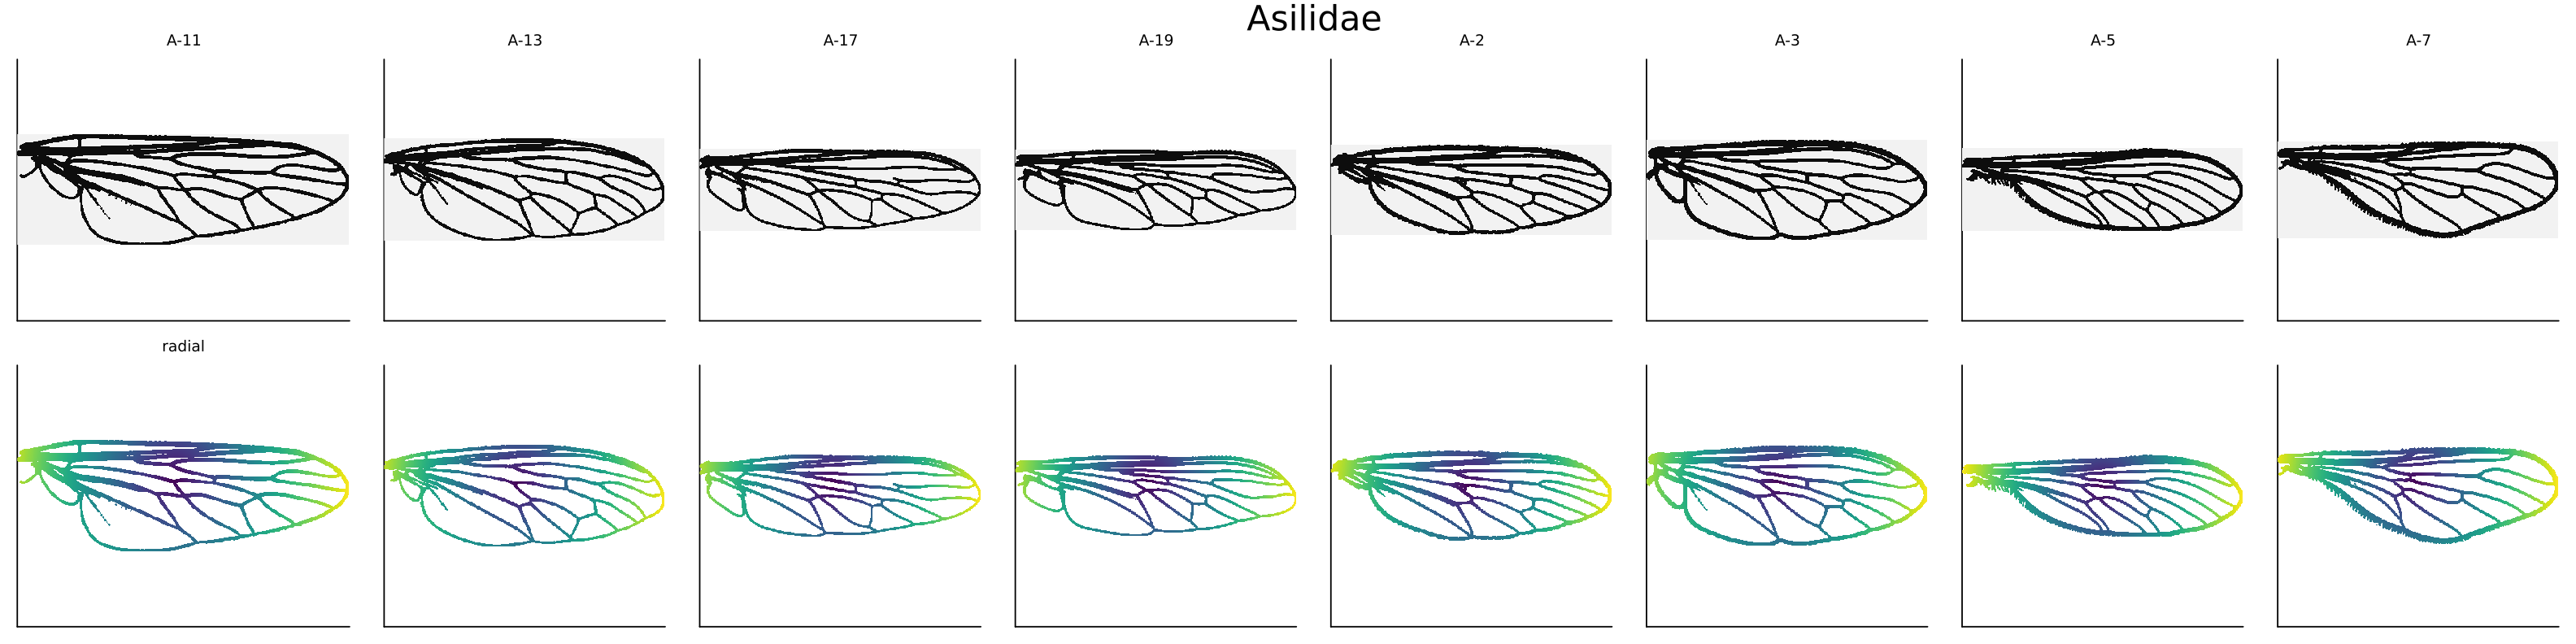


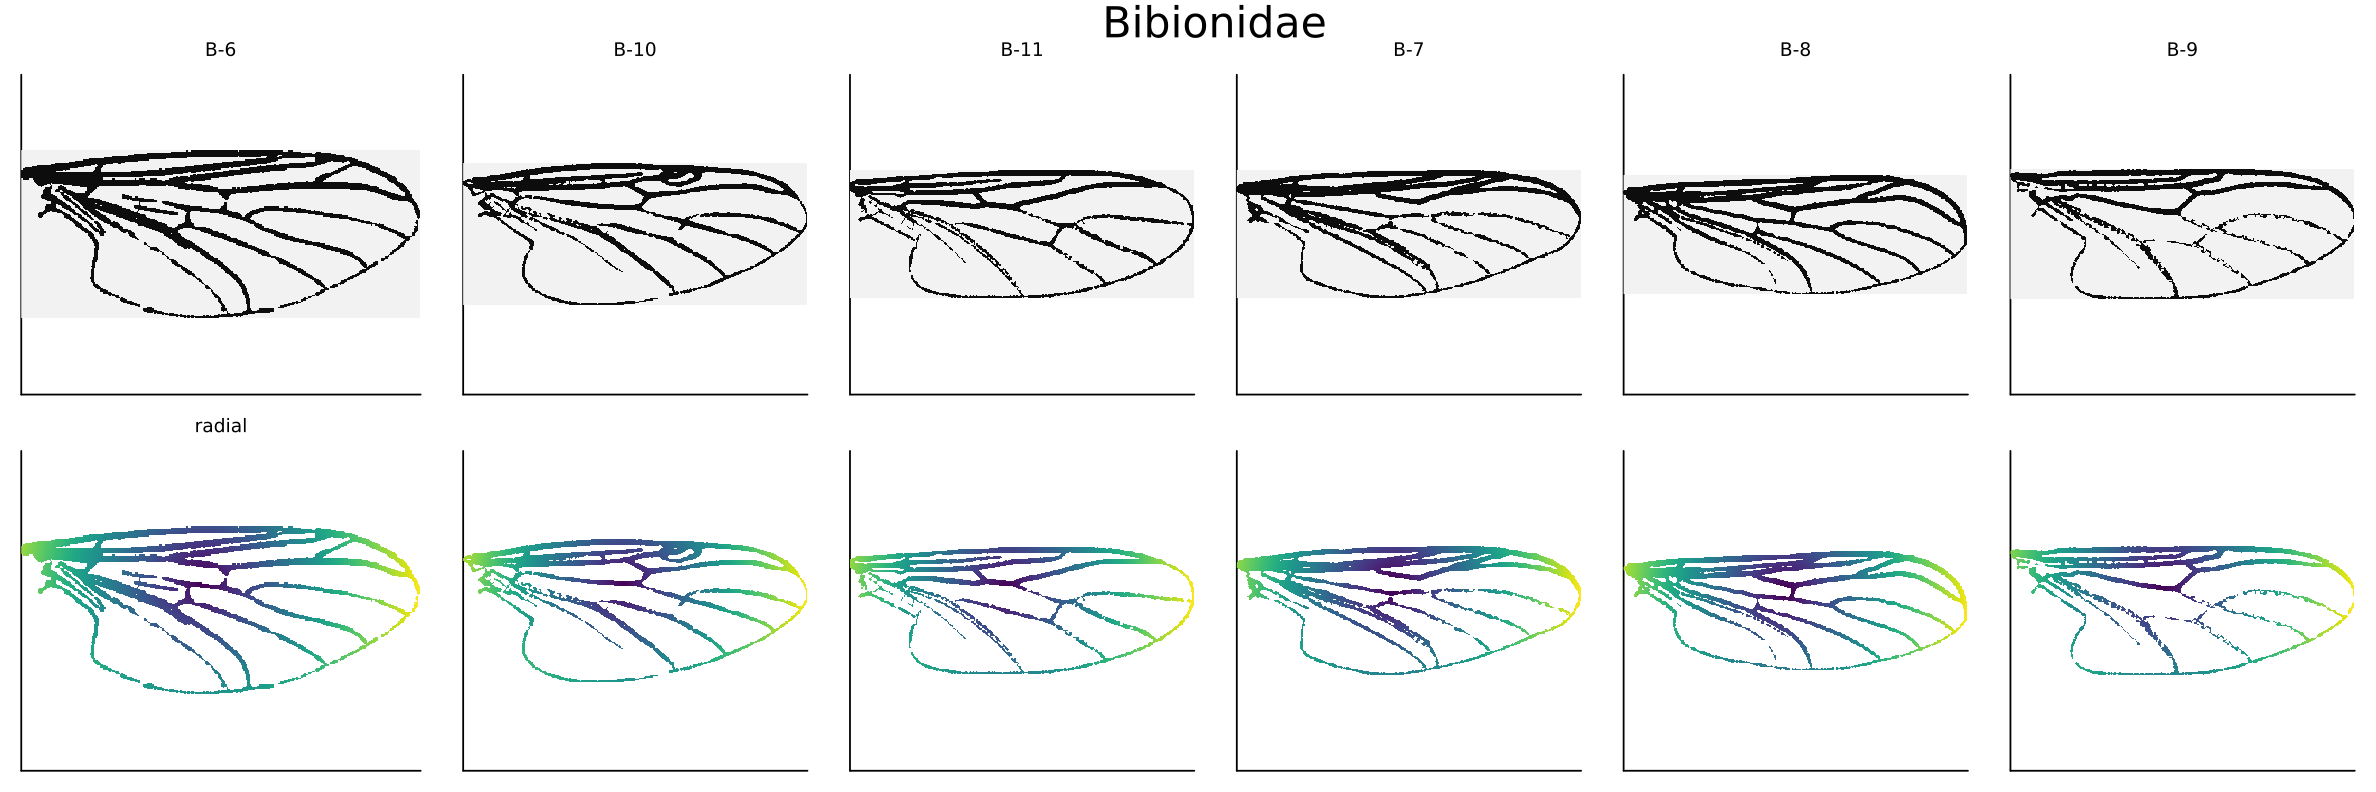


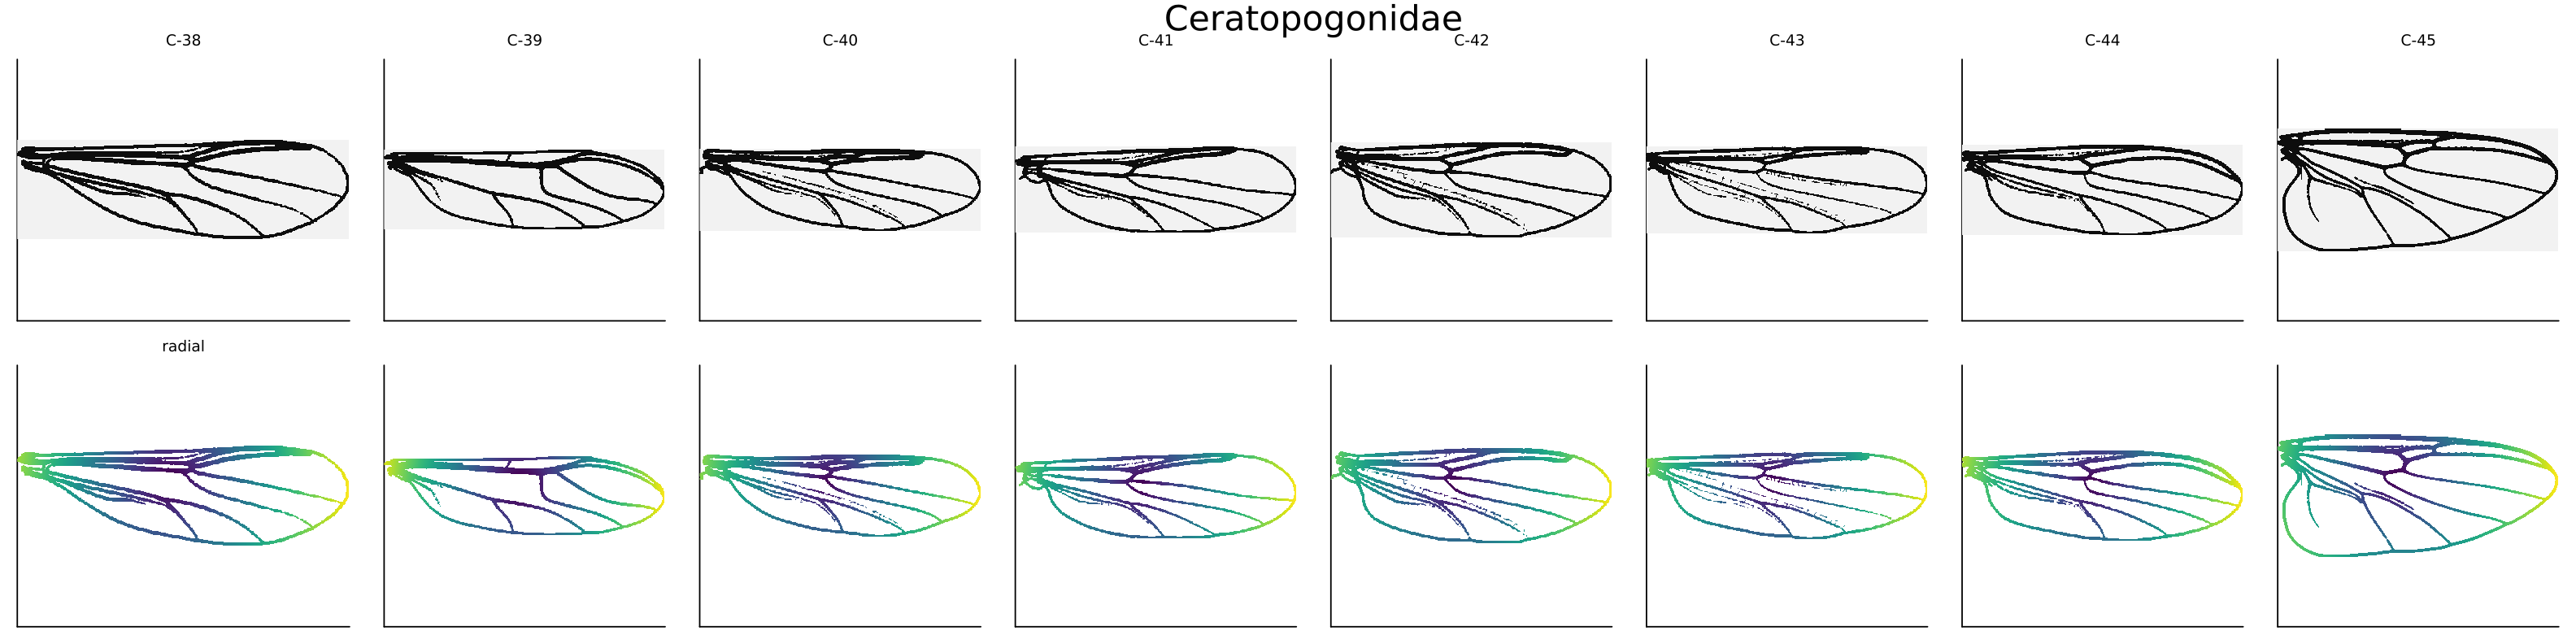


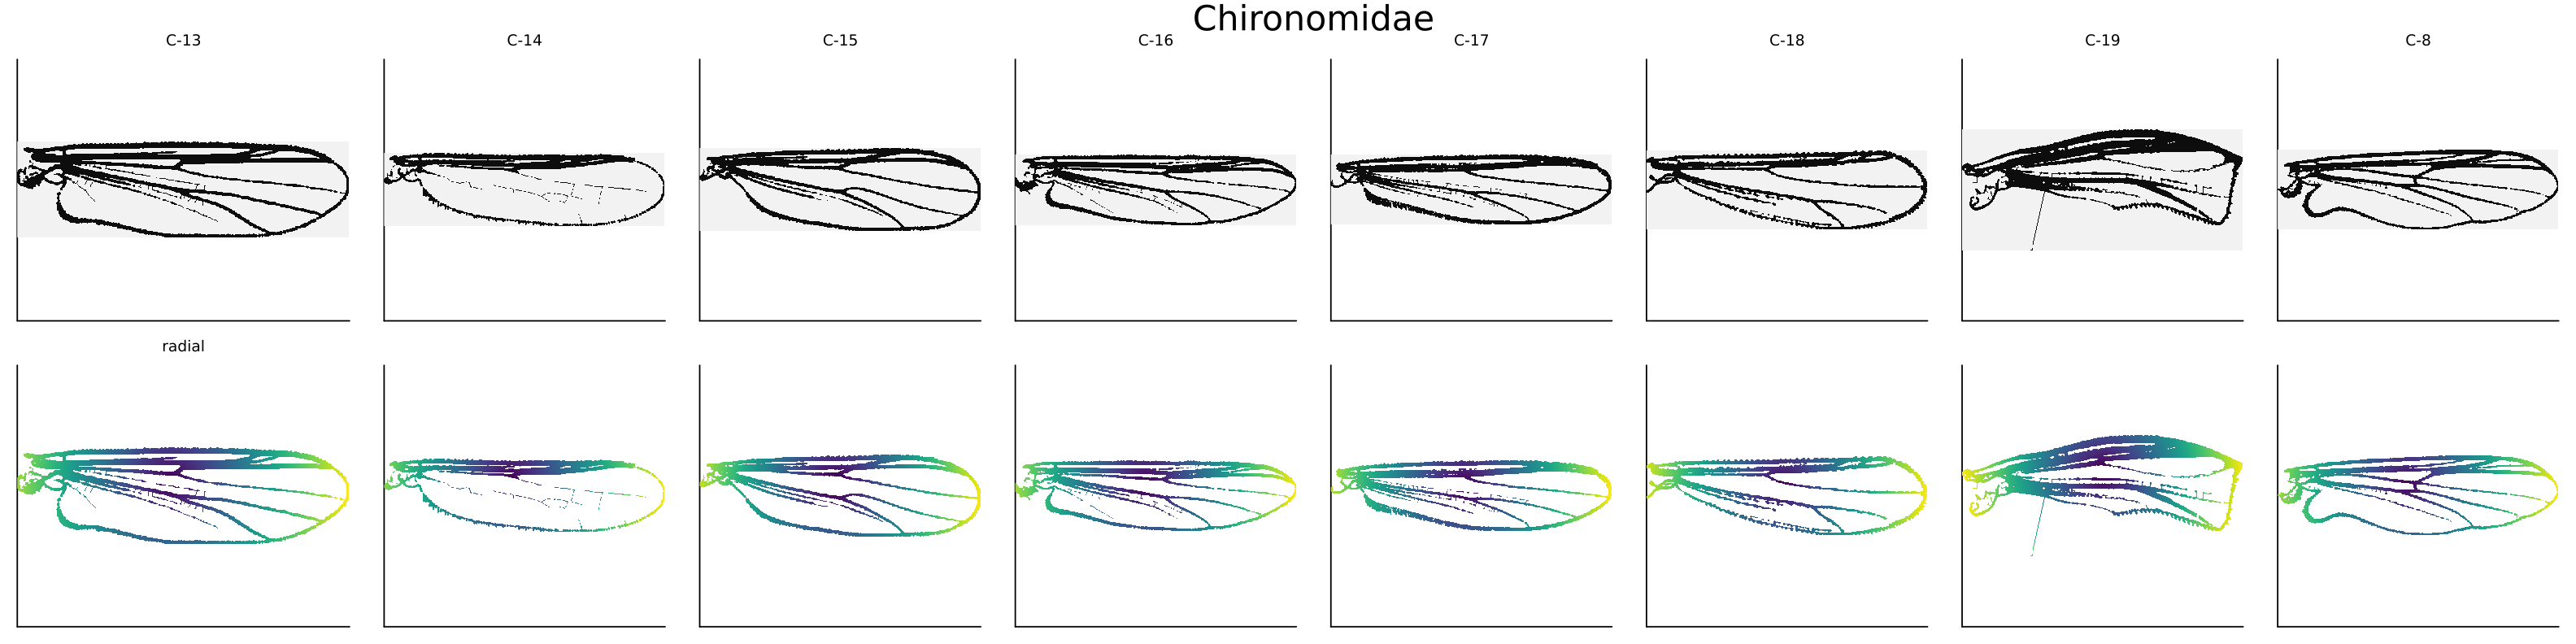


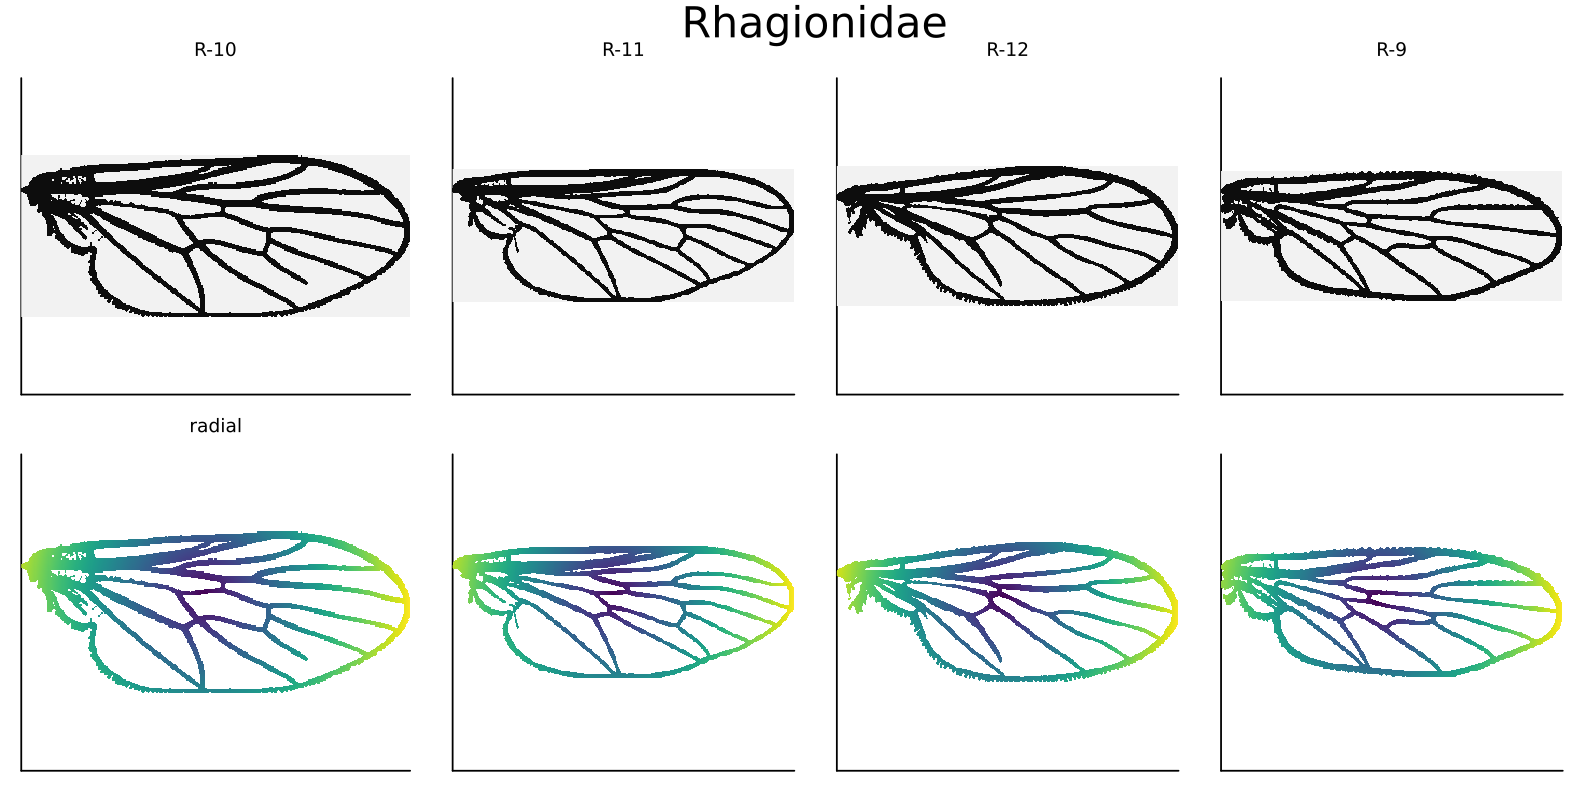


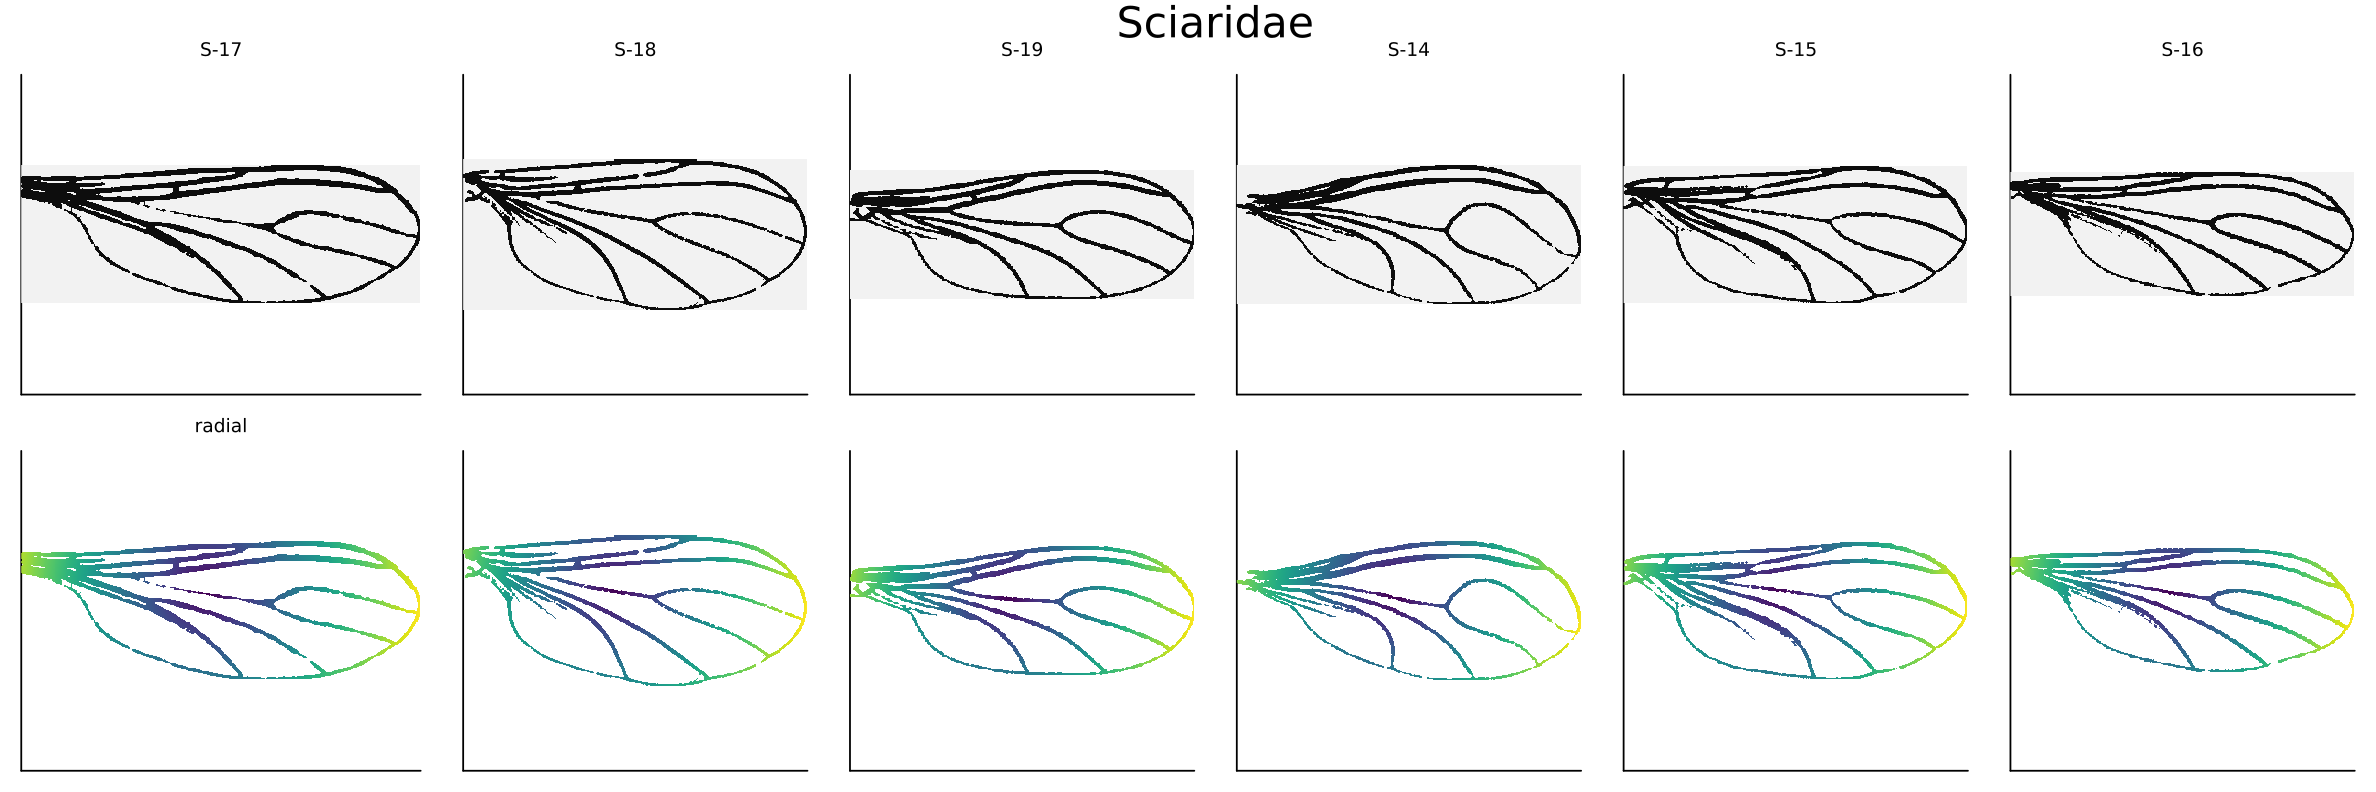


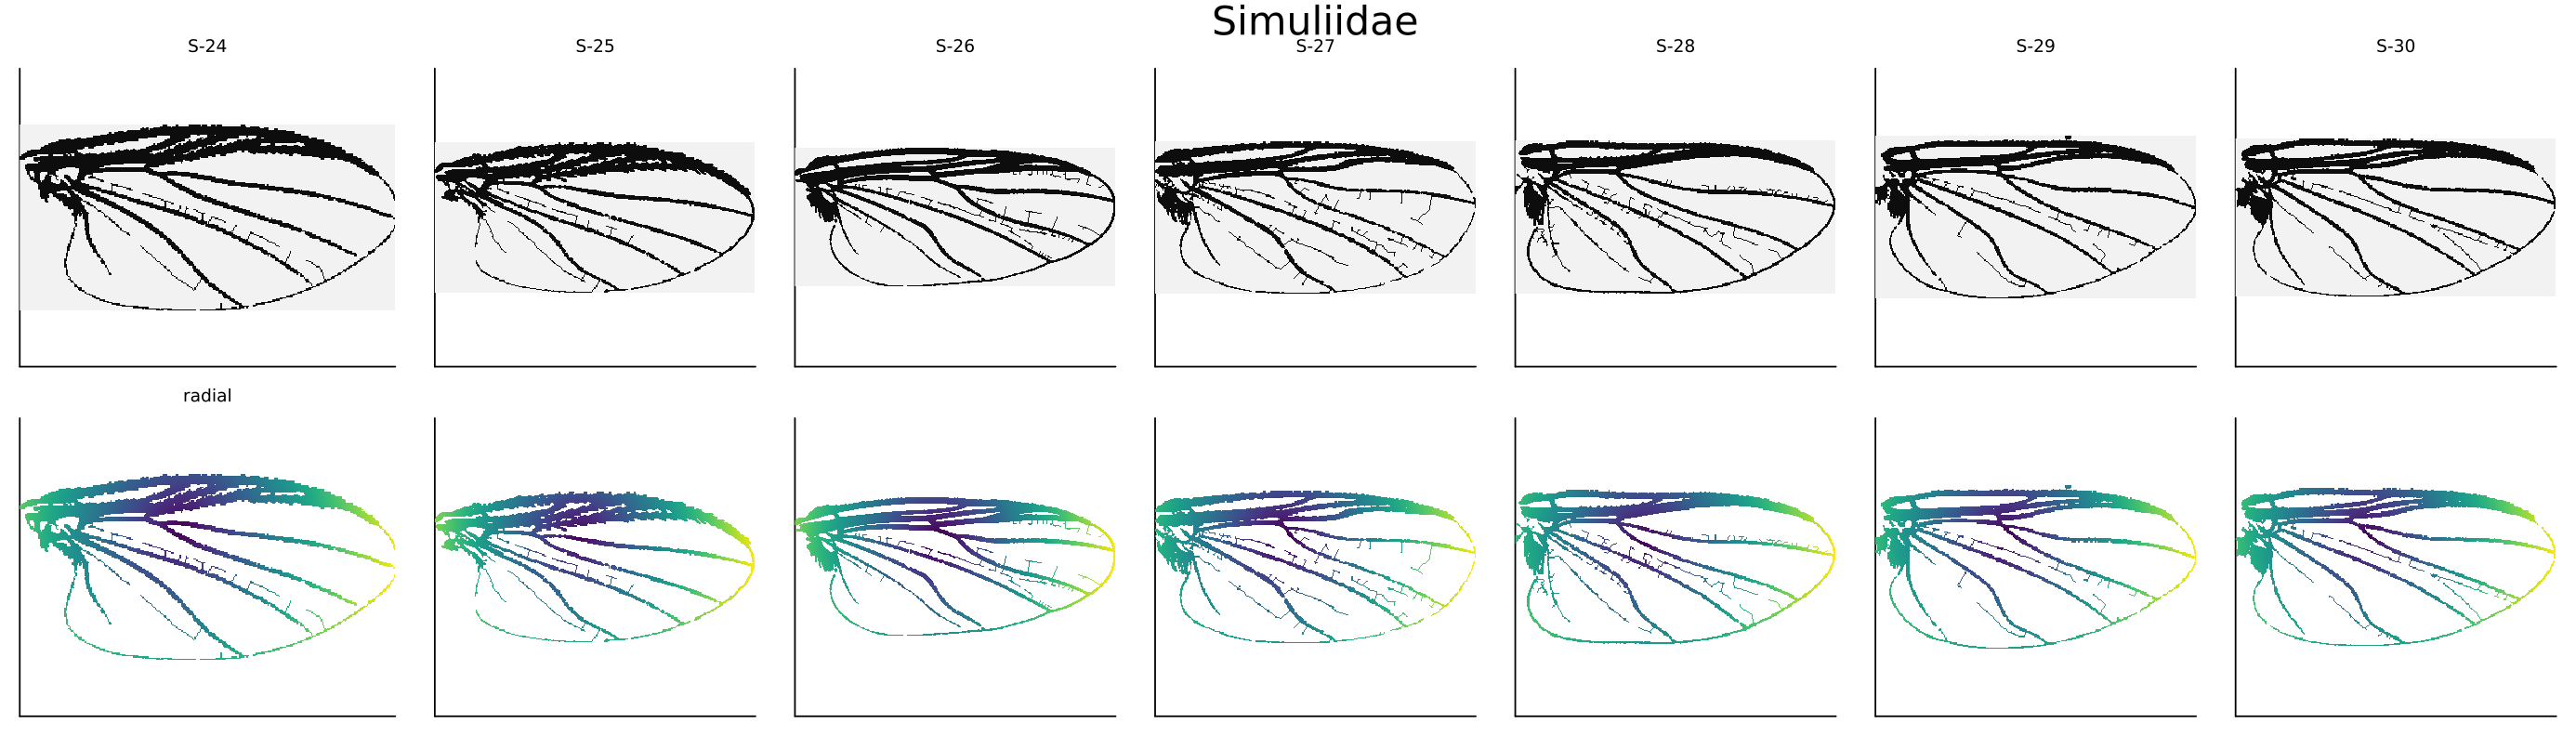


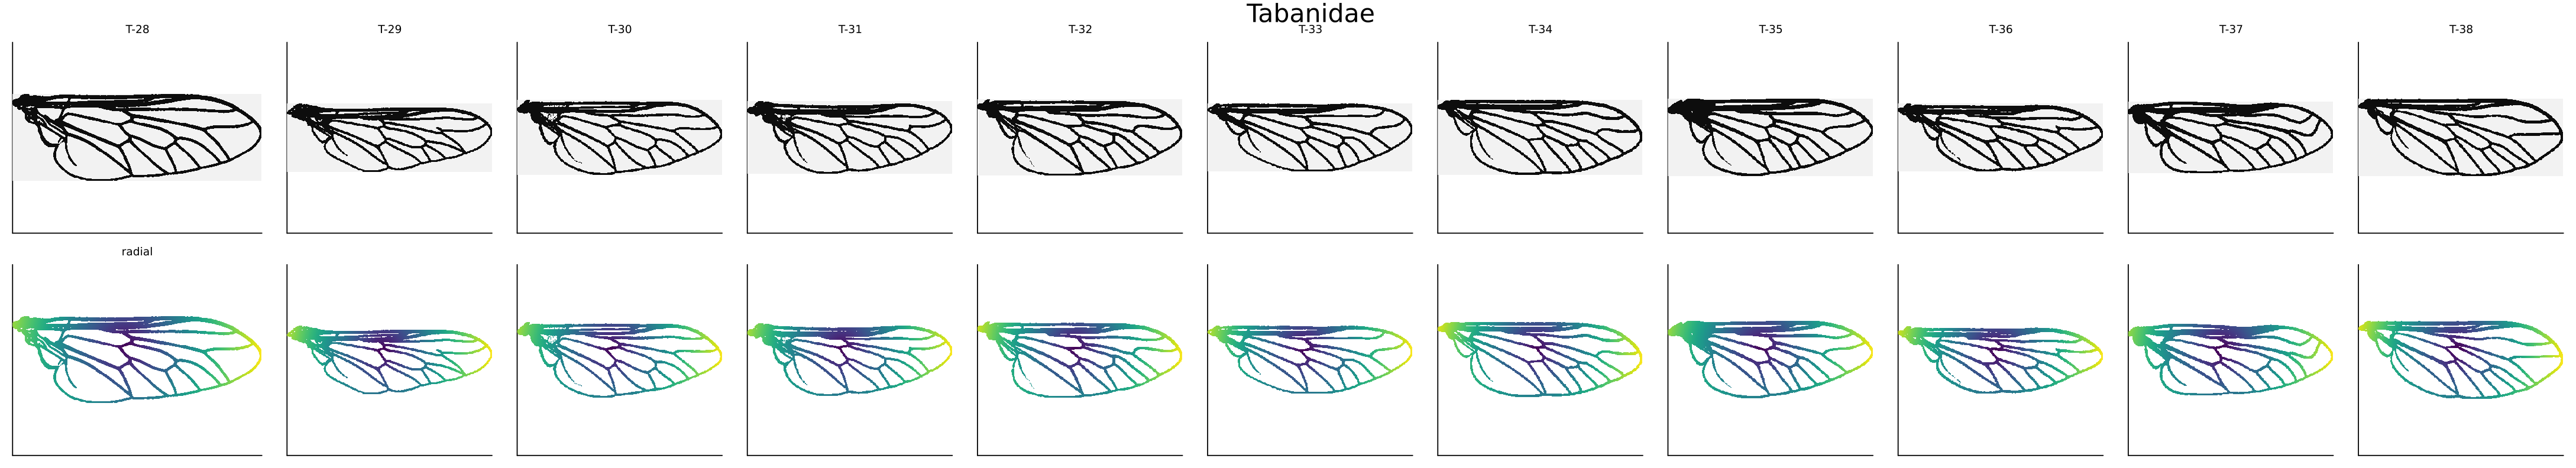


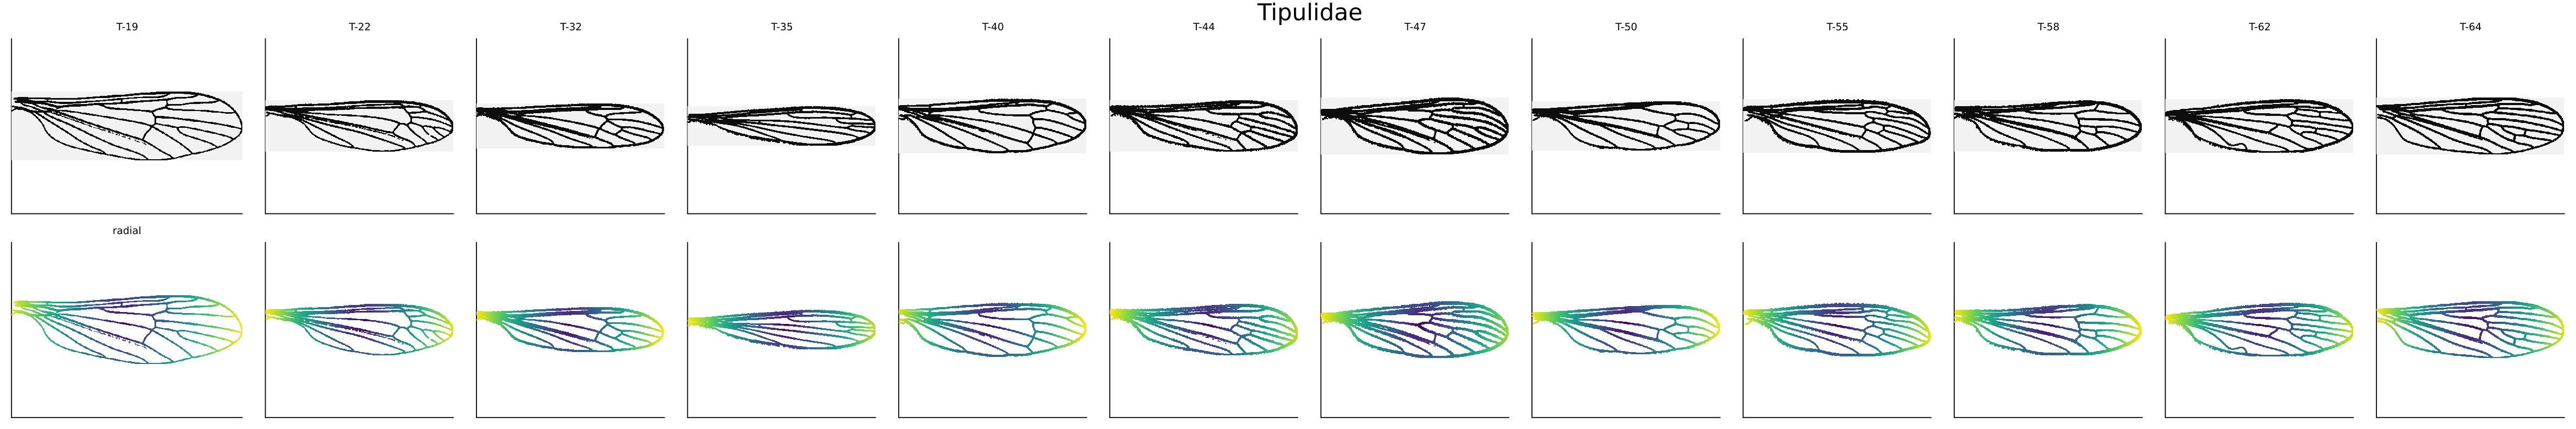

In [17]:
# ── Helpers used throughout the rest of the document ───────────────────────
# wing_panel / radial_panel are reused in "Misclassified wings" below.

function wing_panel(idx; title_str = "")
    heatmap(
        wing_arrays[idx][end:-1:1, :],
        color = :grays, colorbar = false,
        aspect_ratio = :equal, xticks = false, yticks = false,
        title = title_str, titlefontsize = 7,
    )
end

function radial_panel(idx; title_str = "")
    F = radial_filtration(wing_arrays[idx])
    F_display = copy(F)
    F_display[F_display .> 1.5] .= NaN
    heatmap(
        F_display[end:-1:1, :],
        color = :viridis, colorbar = false,
        aspect_ratio = :equal, xticks = false, yticks = false,
        title = title_str, titlefontsize = 7,
    )
end

# One block per family: top row = wings, bottom row = radial filtrations
for f in sort(unique(families))
    fidx = findall(==(f), families)
    n_f  = length(fidx)
    wing_ps   = [wing_panel(i;   title_str = individuals[i]) for i in fidx]
    radial_ps = [radial_panel(i; title_str = (i == fidx[1] ? "radial" : "")) for i in fidx]
    p = plot([wing_ps; radial_ps]...,
             layout = (2, n_f),
             size   = (220 * n_f, 440),
             plot_title = f)
    display(p)
end

### 3.6 Examples: persistence diagrams from each strategy

Below we show persistence diagrams from the Rips, radial, and directional filtrations for one specimen per family:


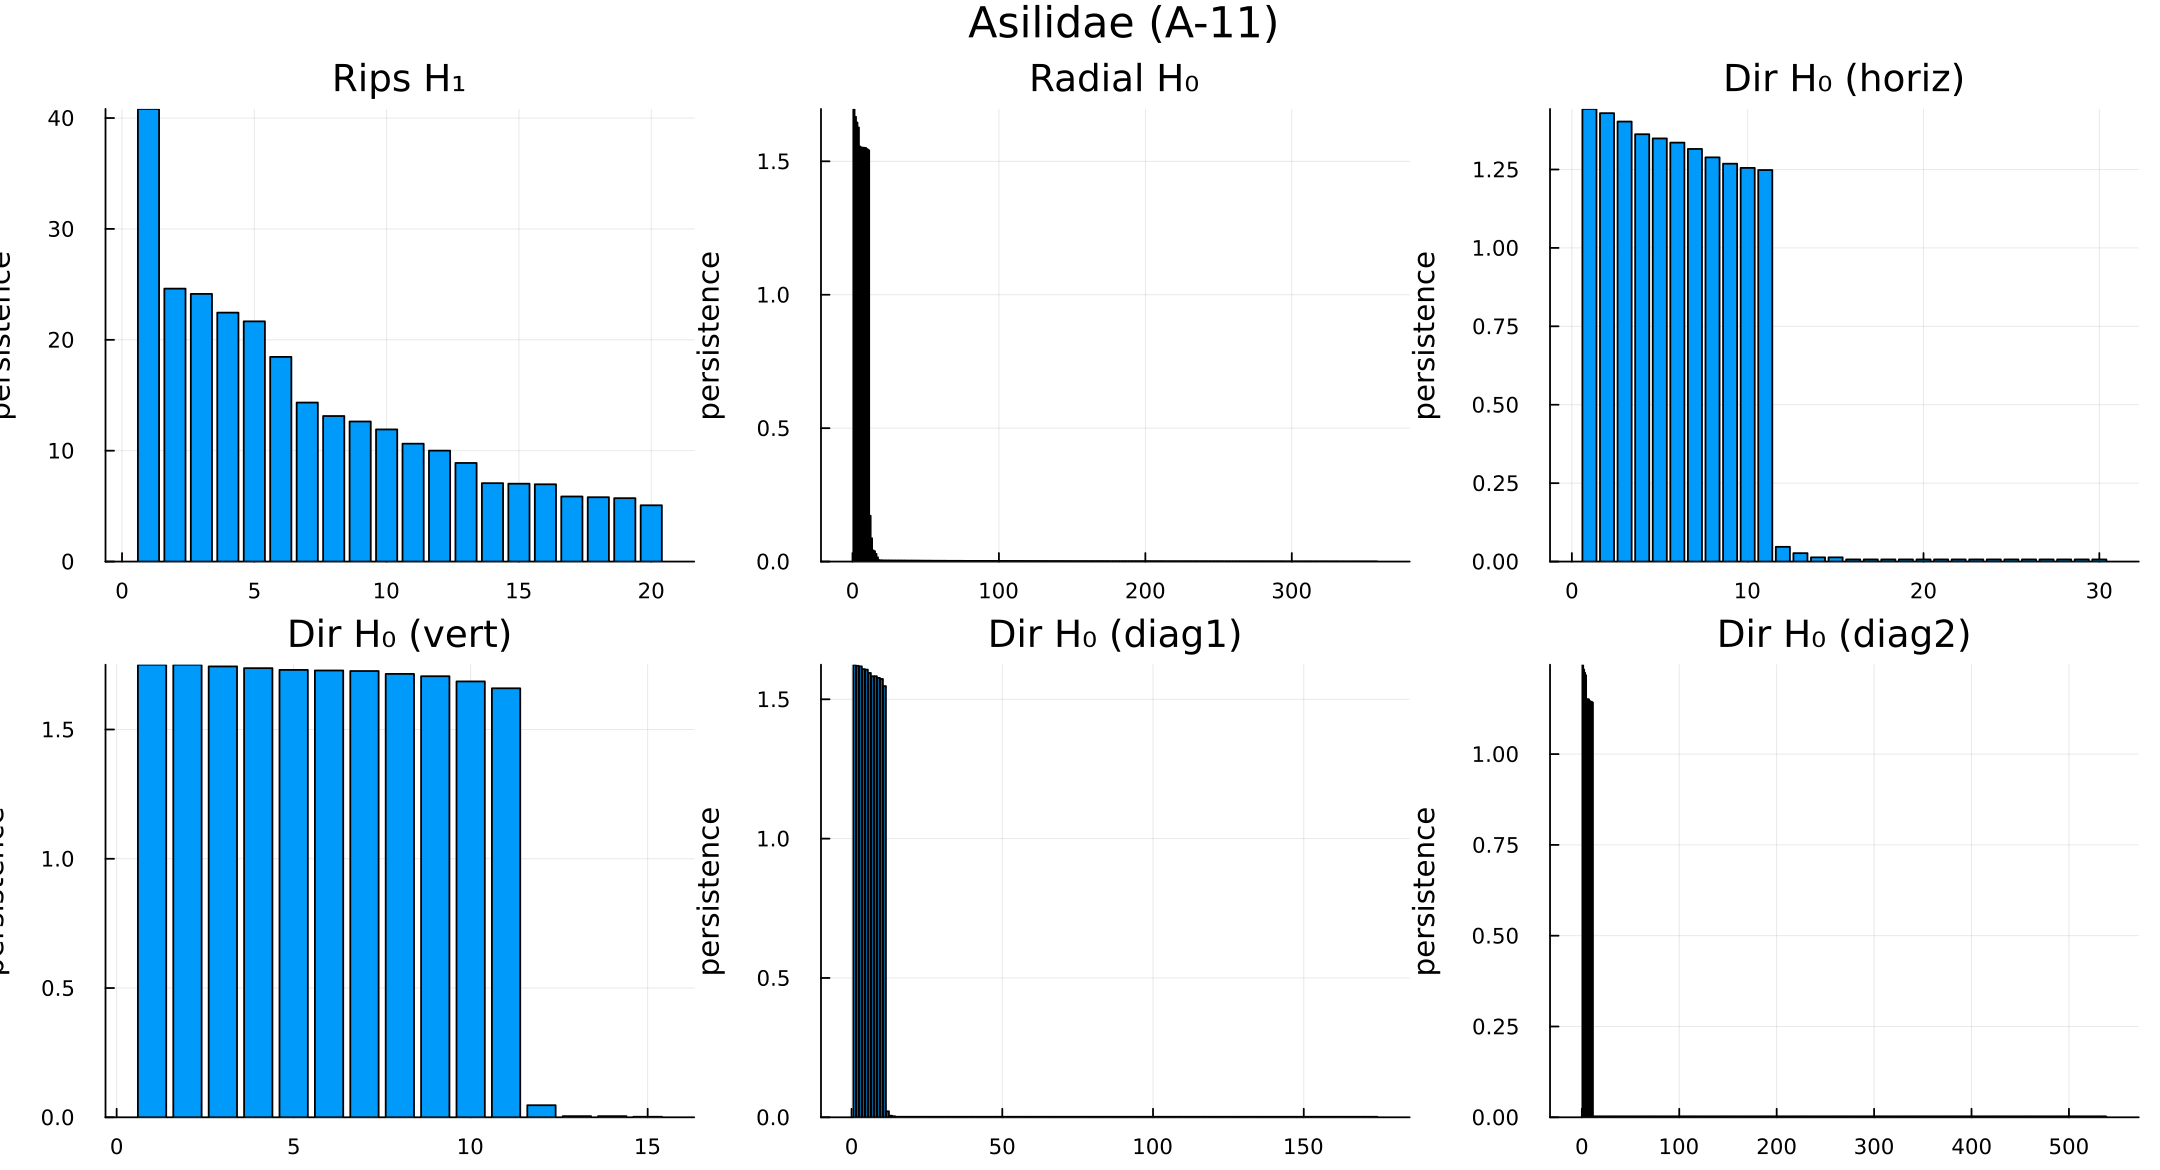


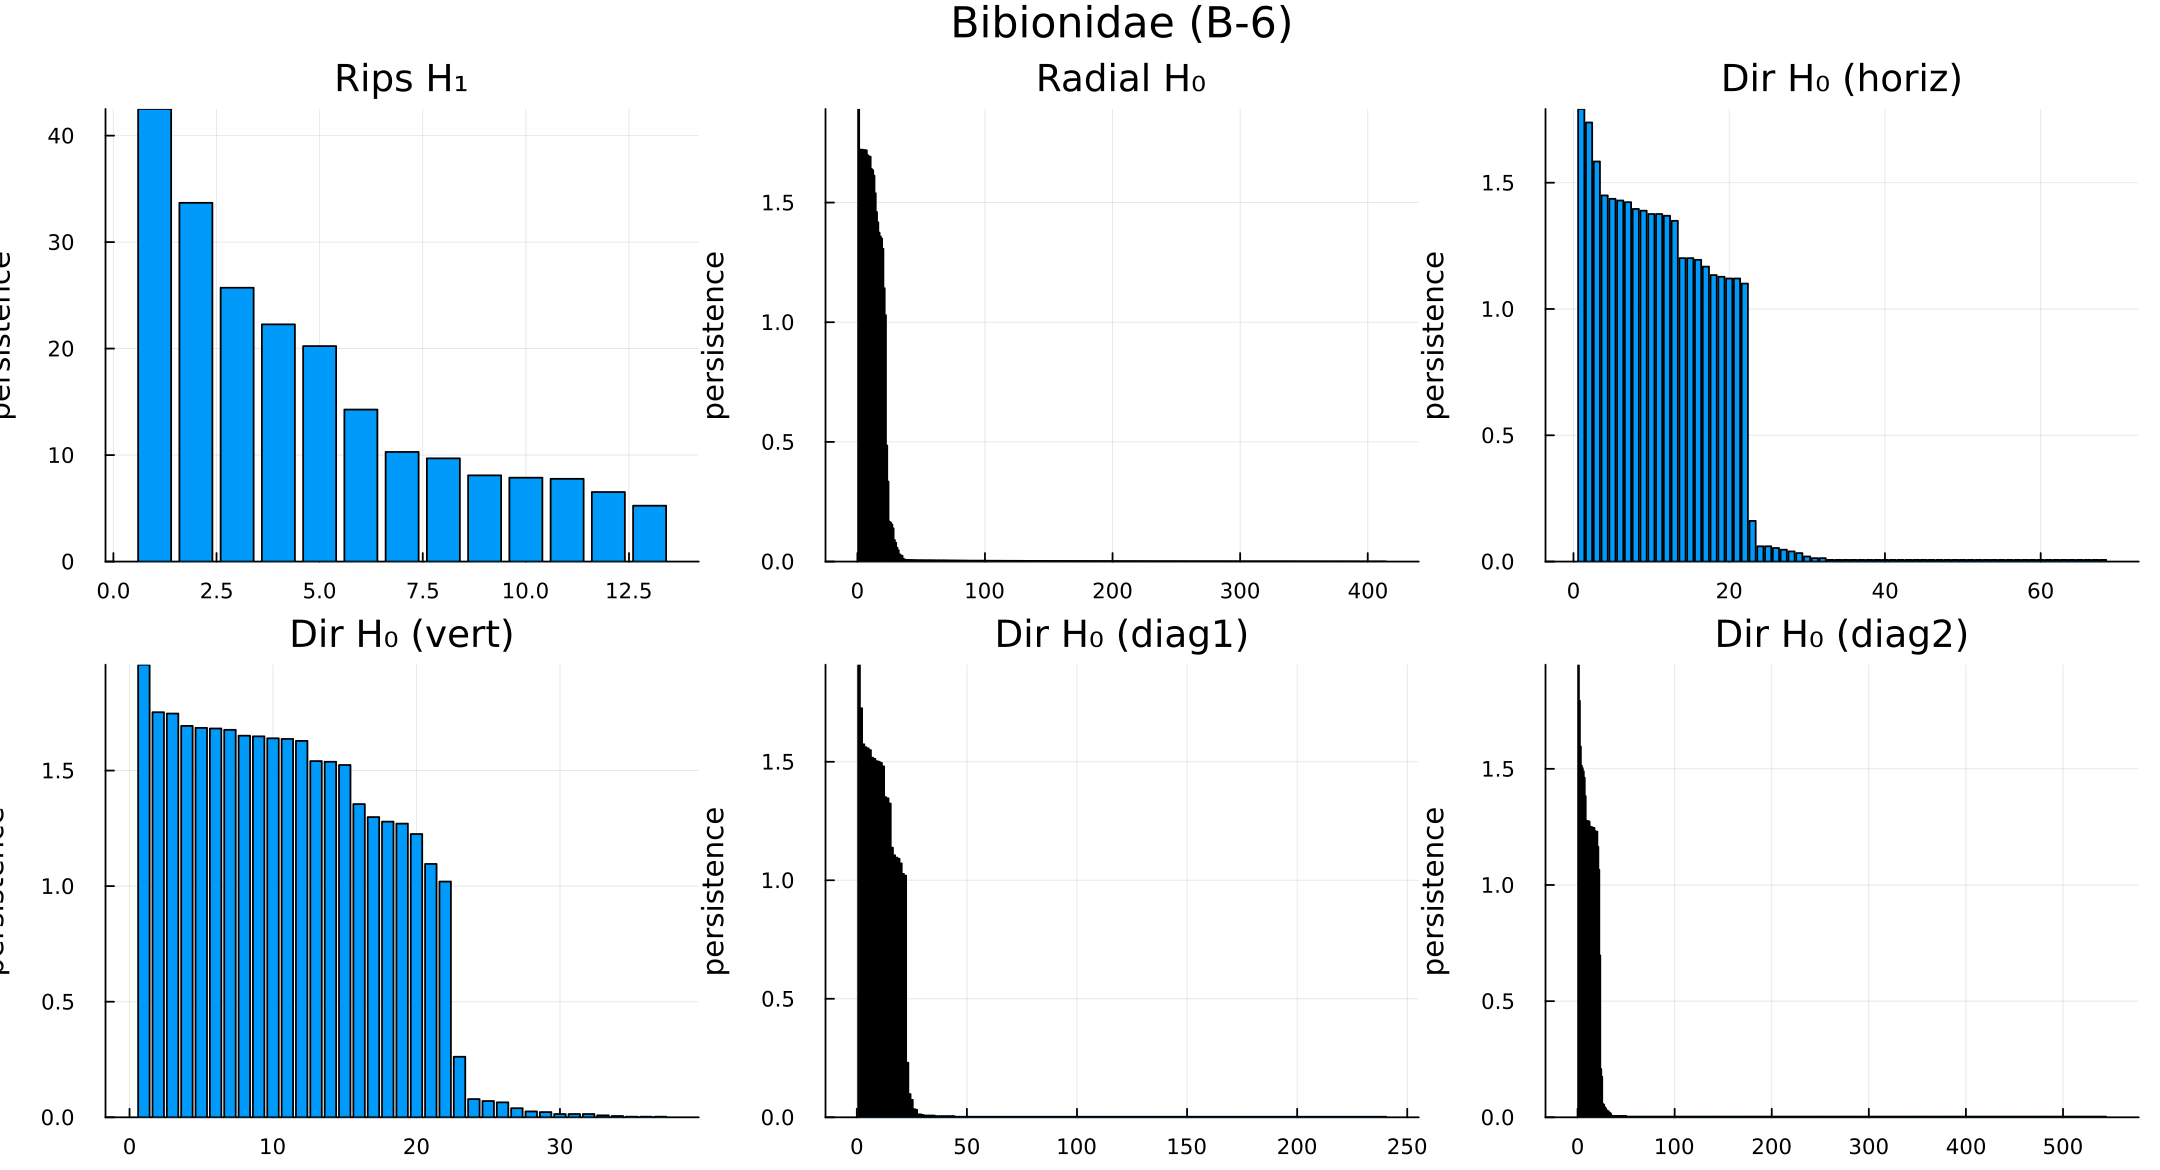


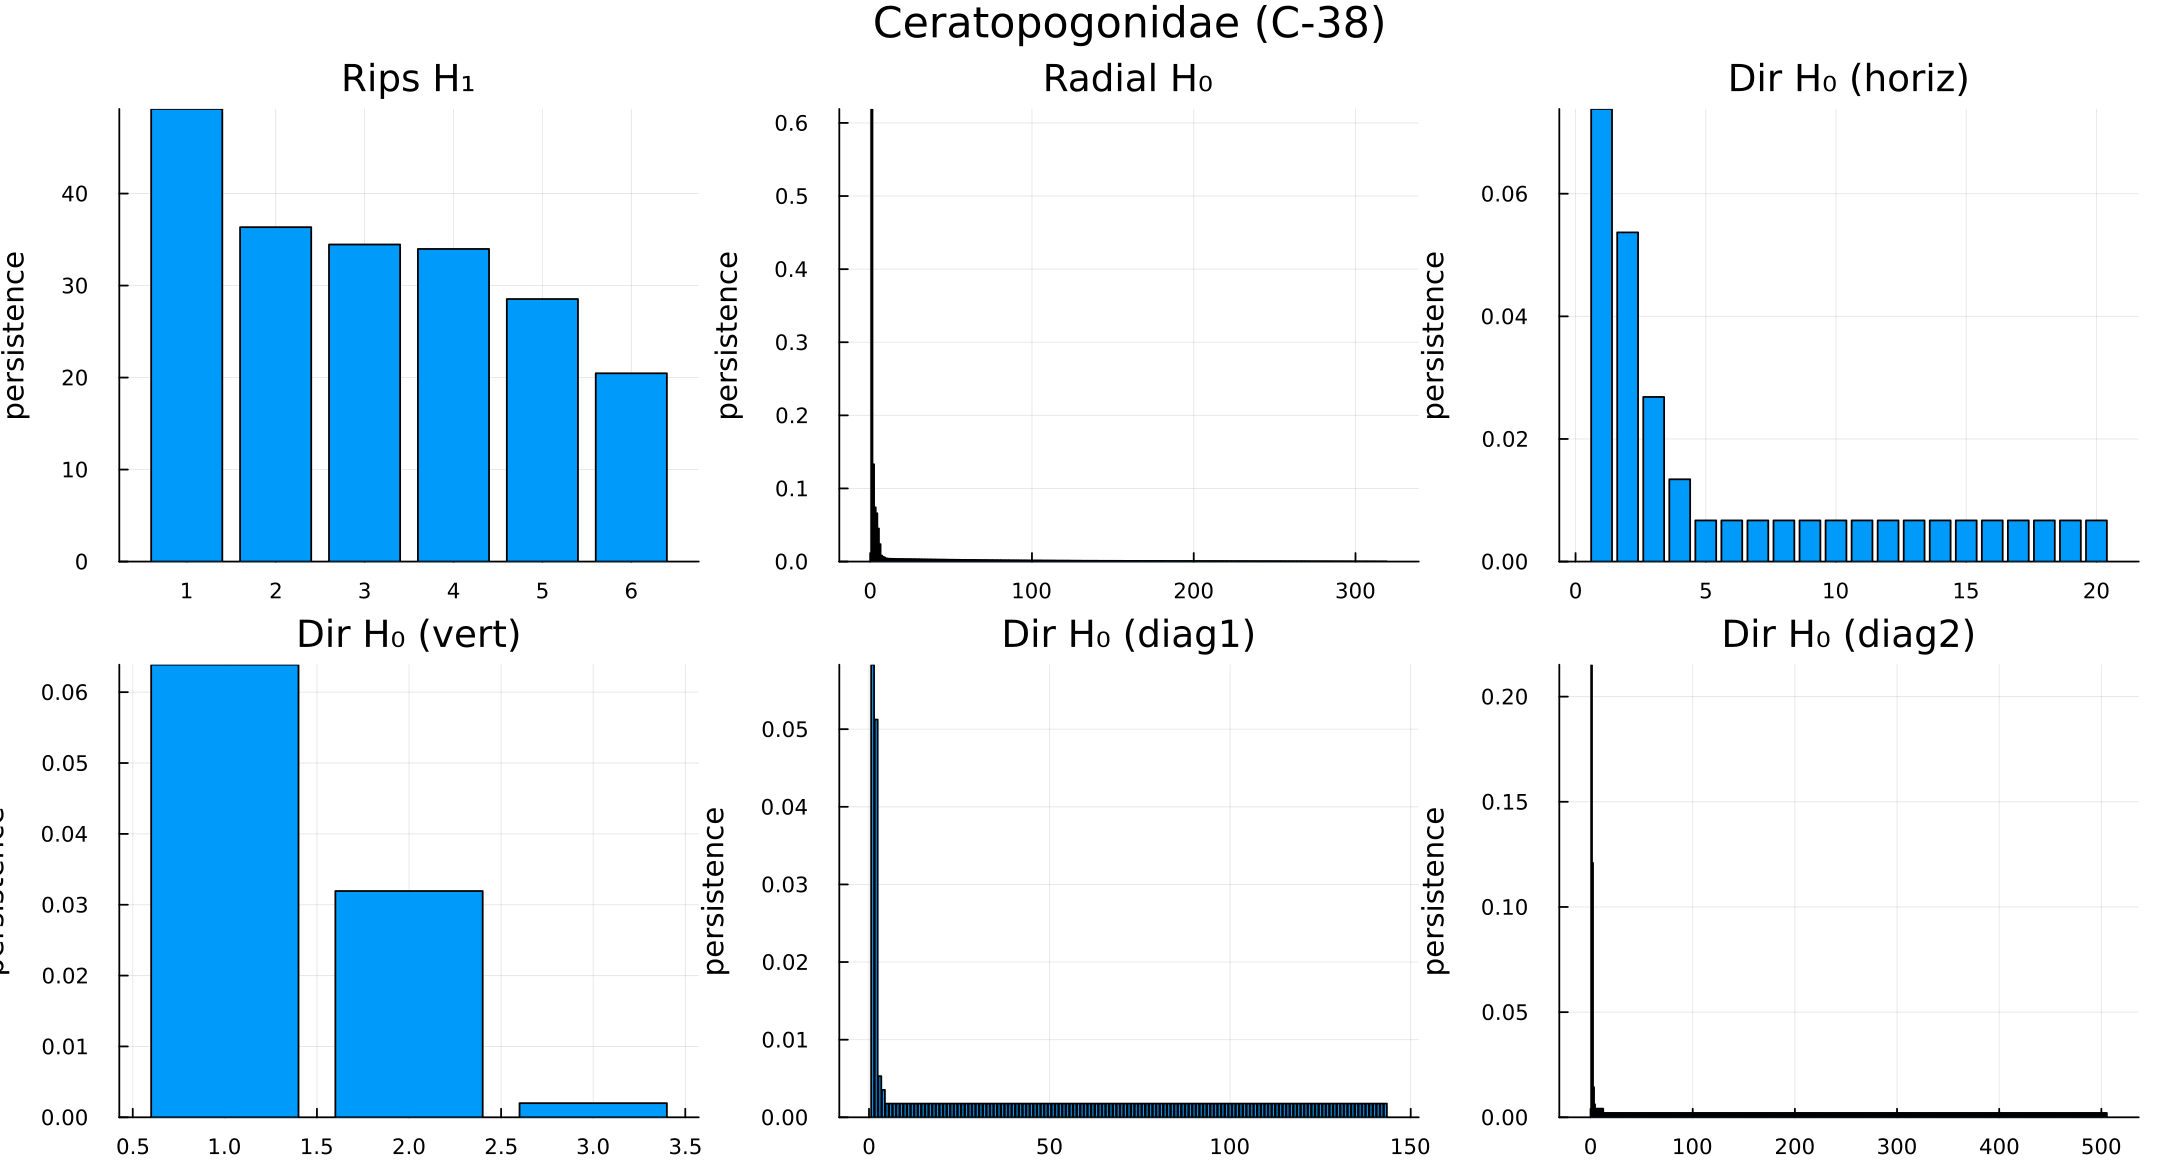


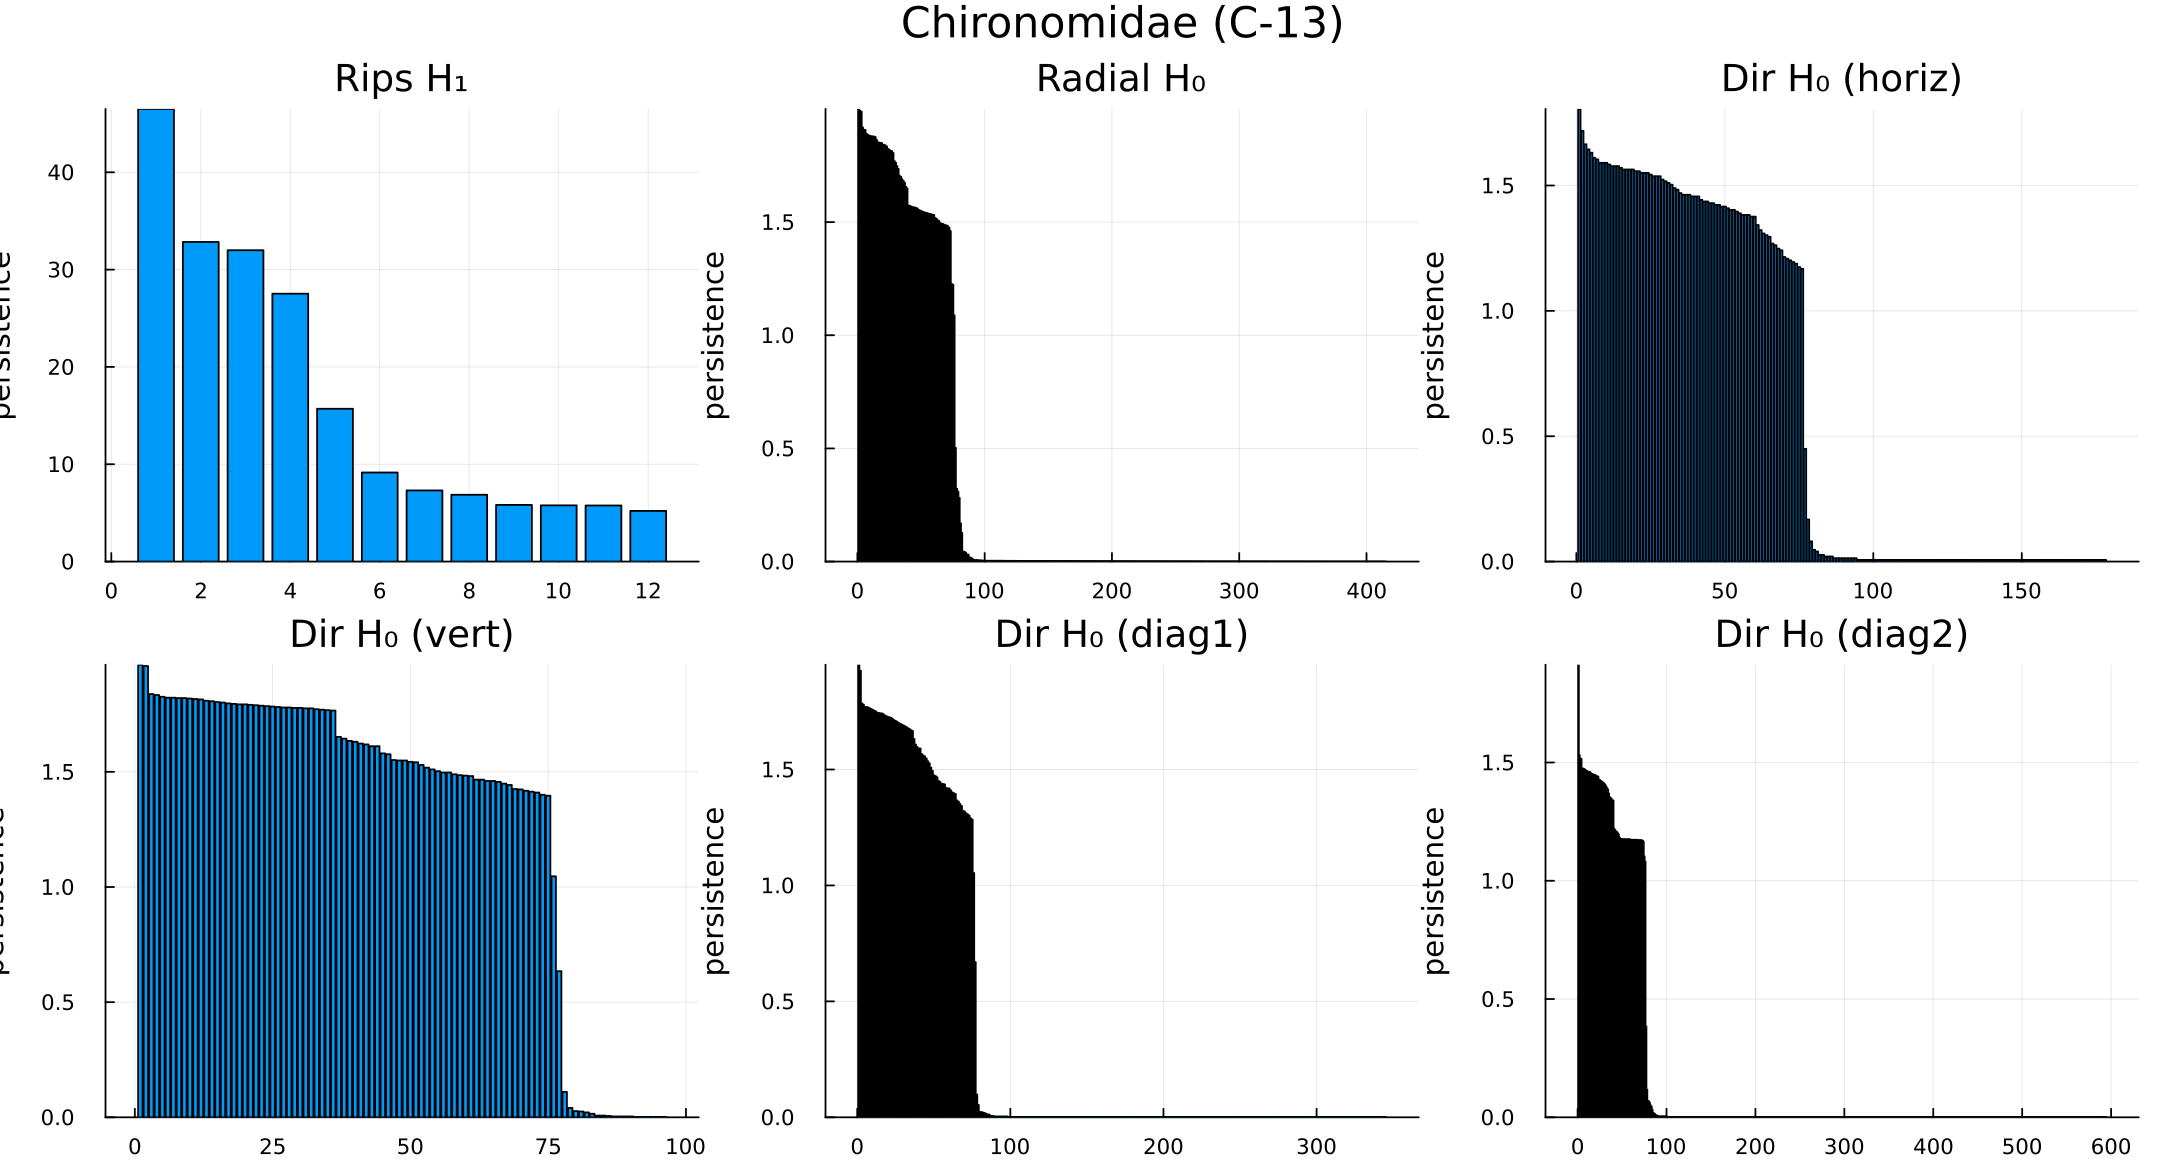


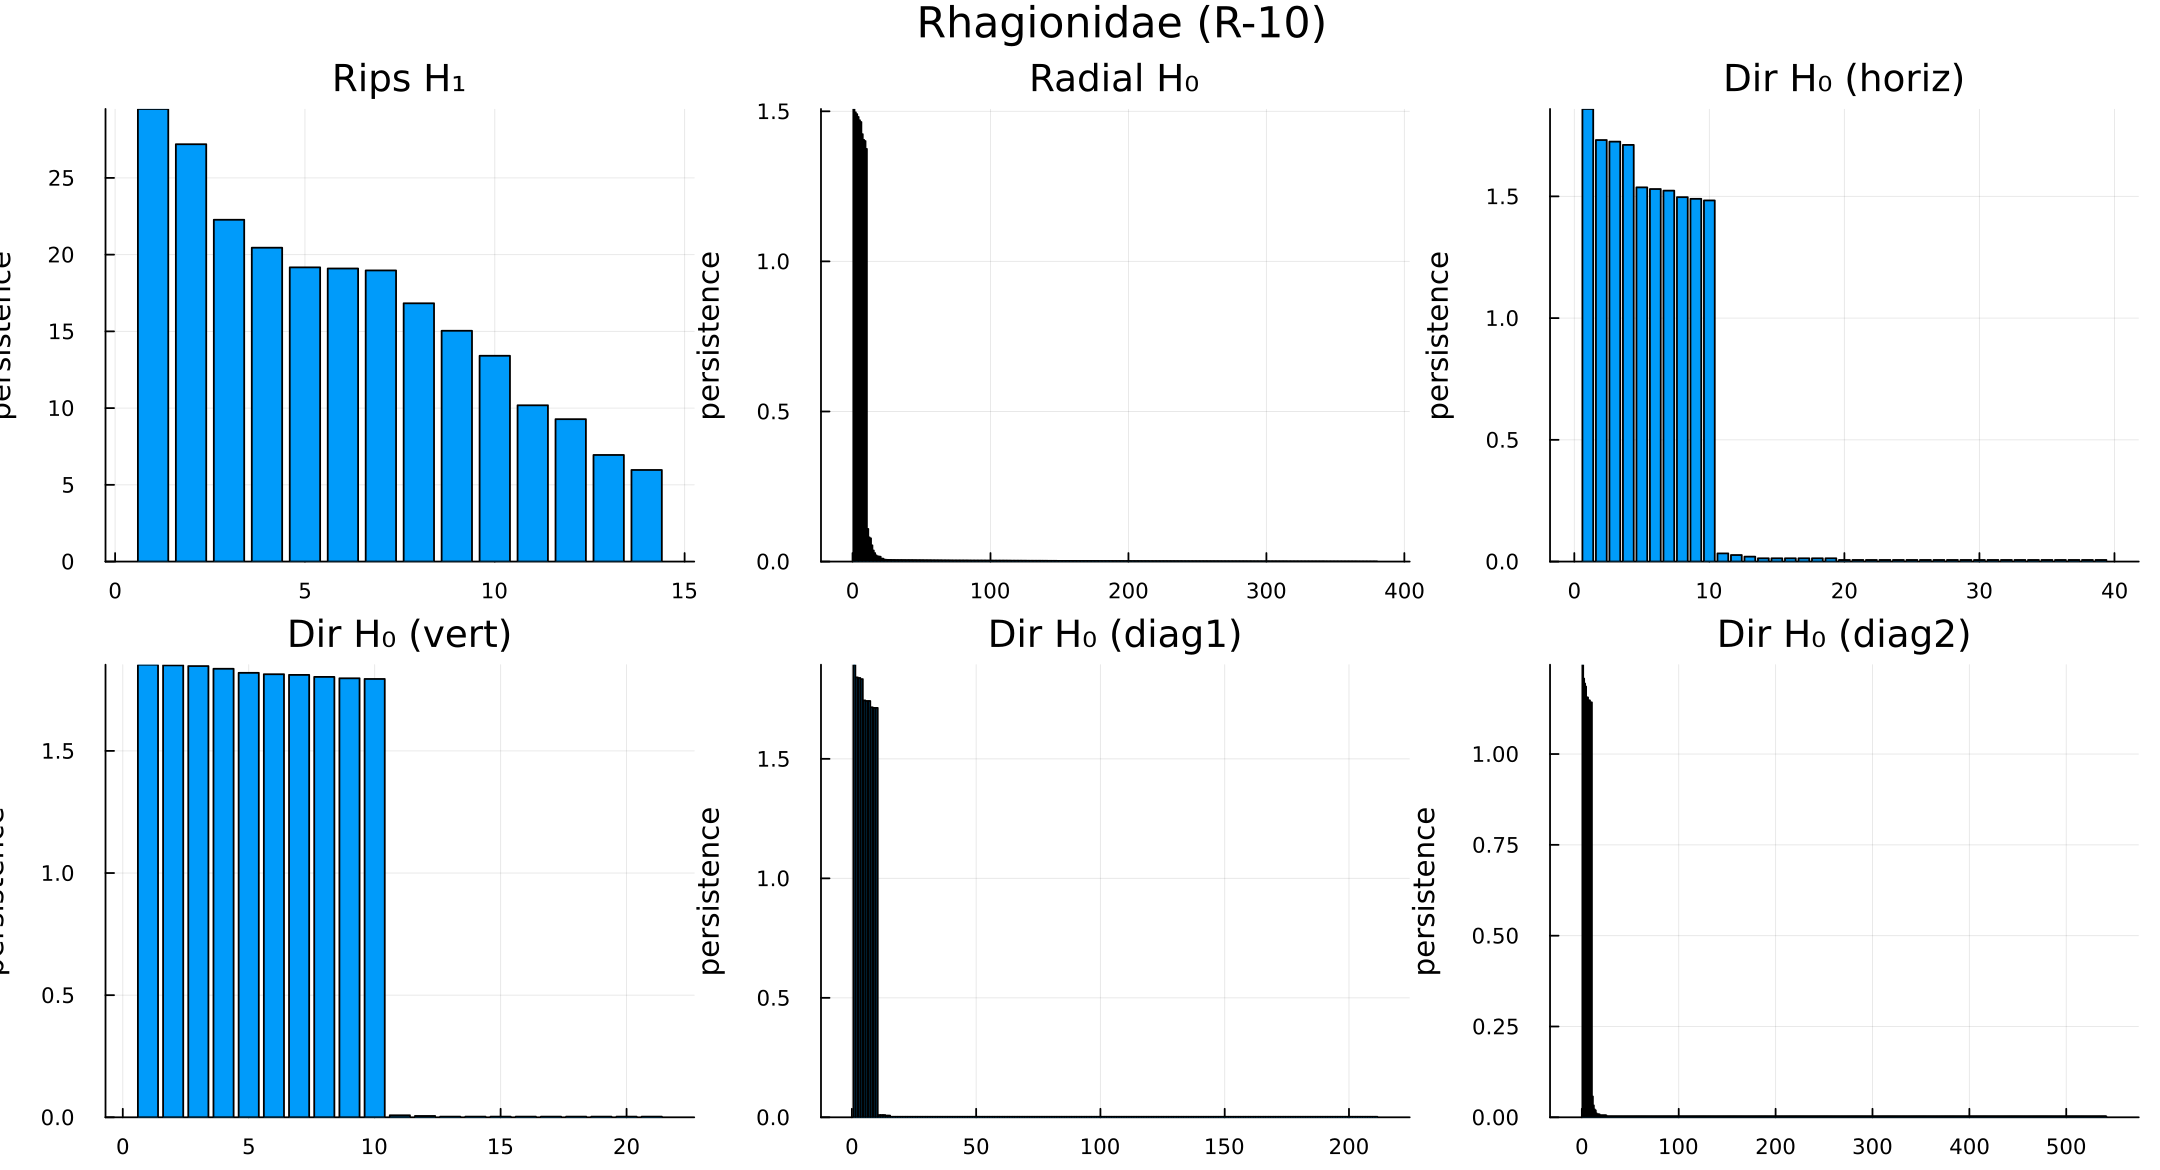


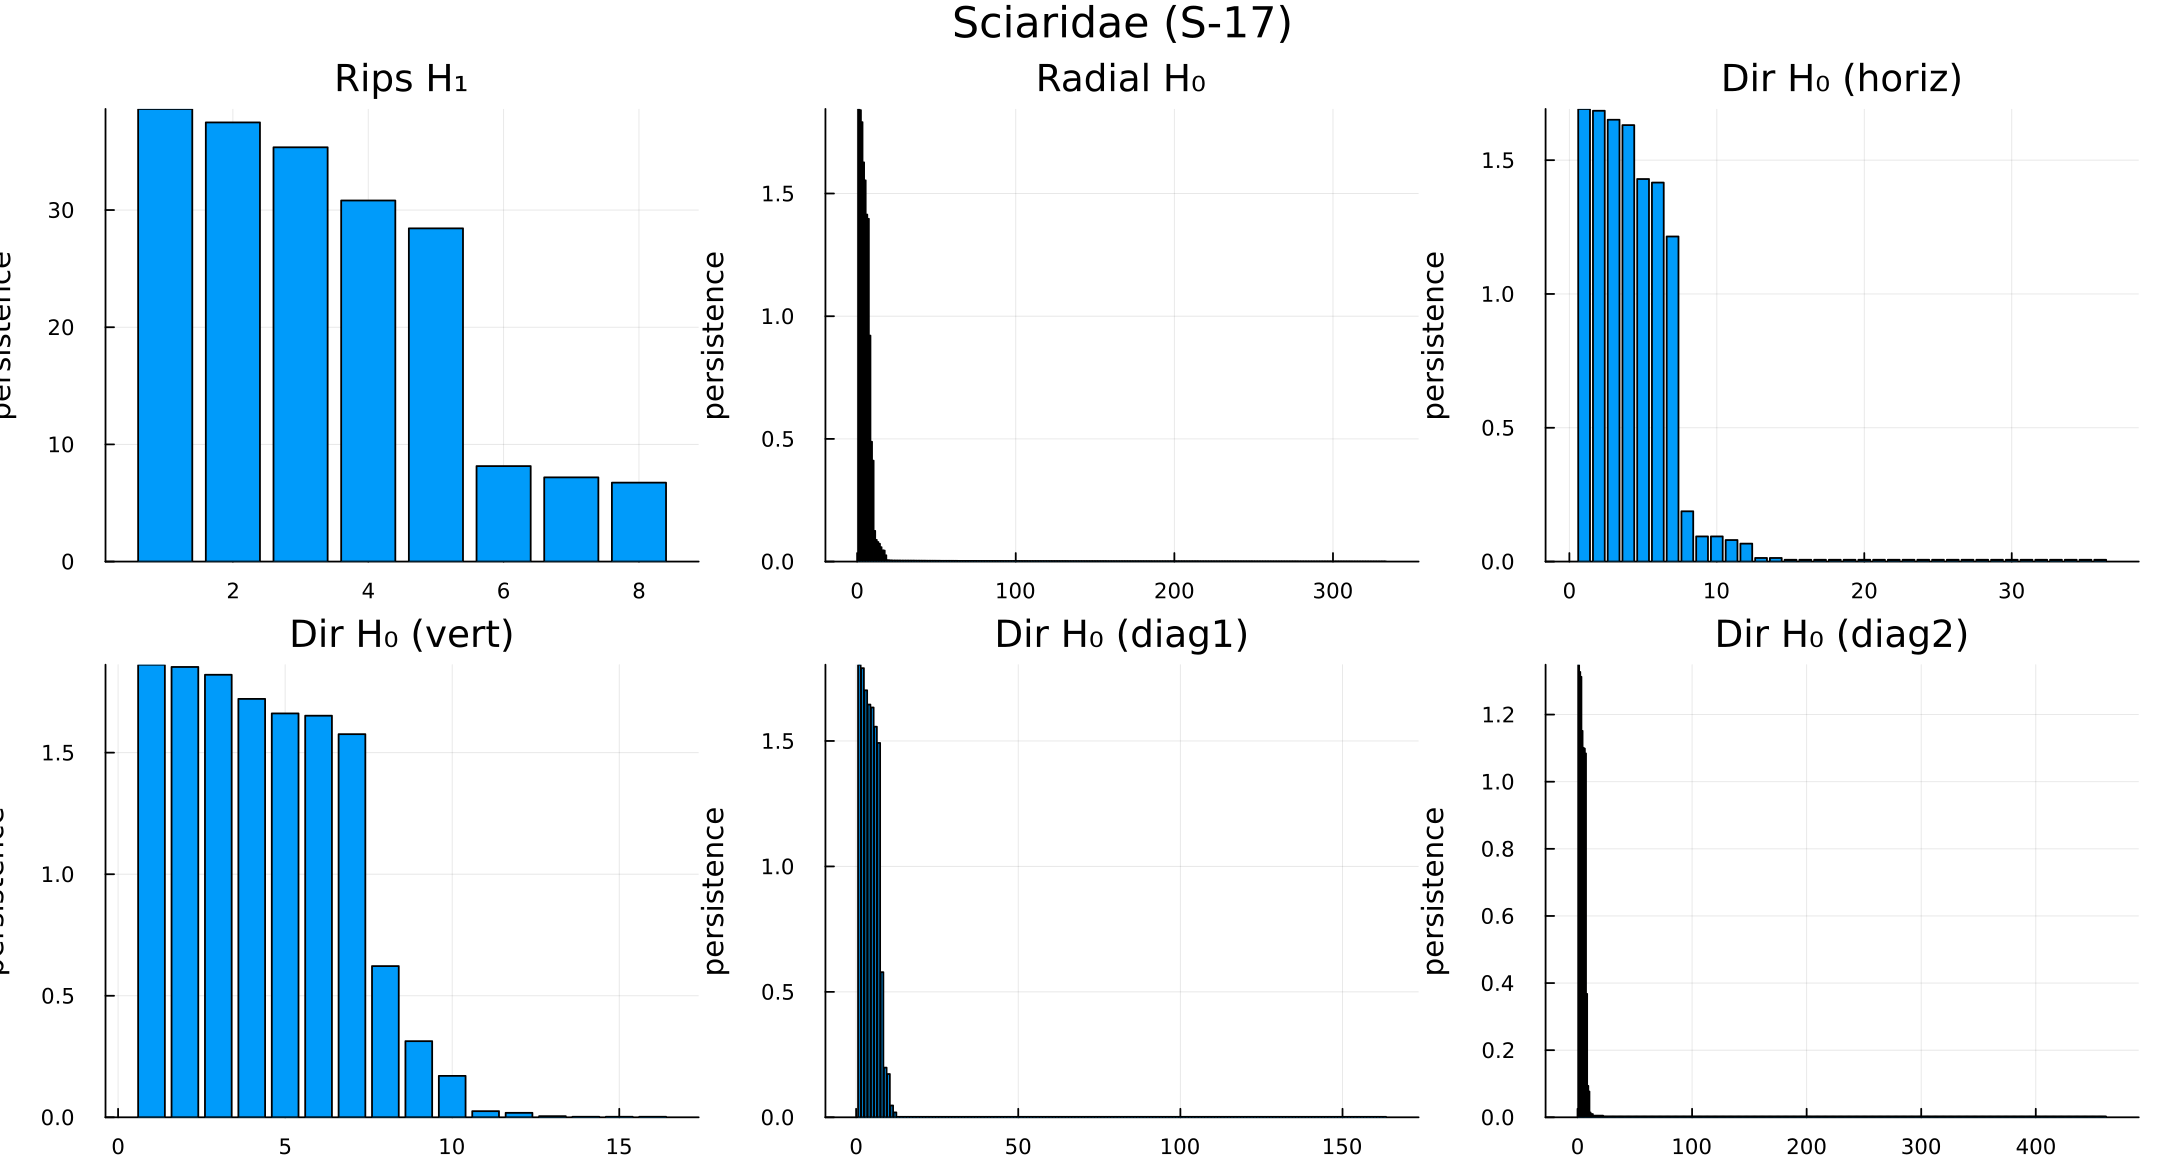


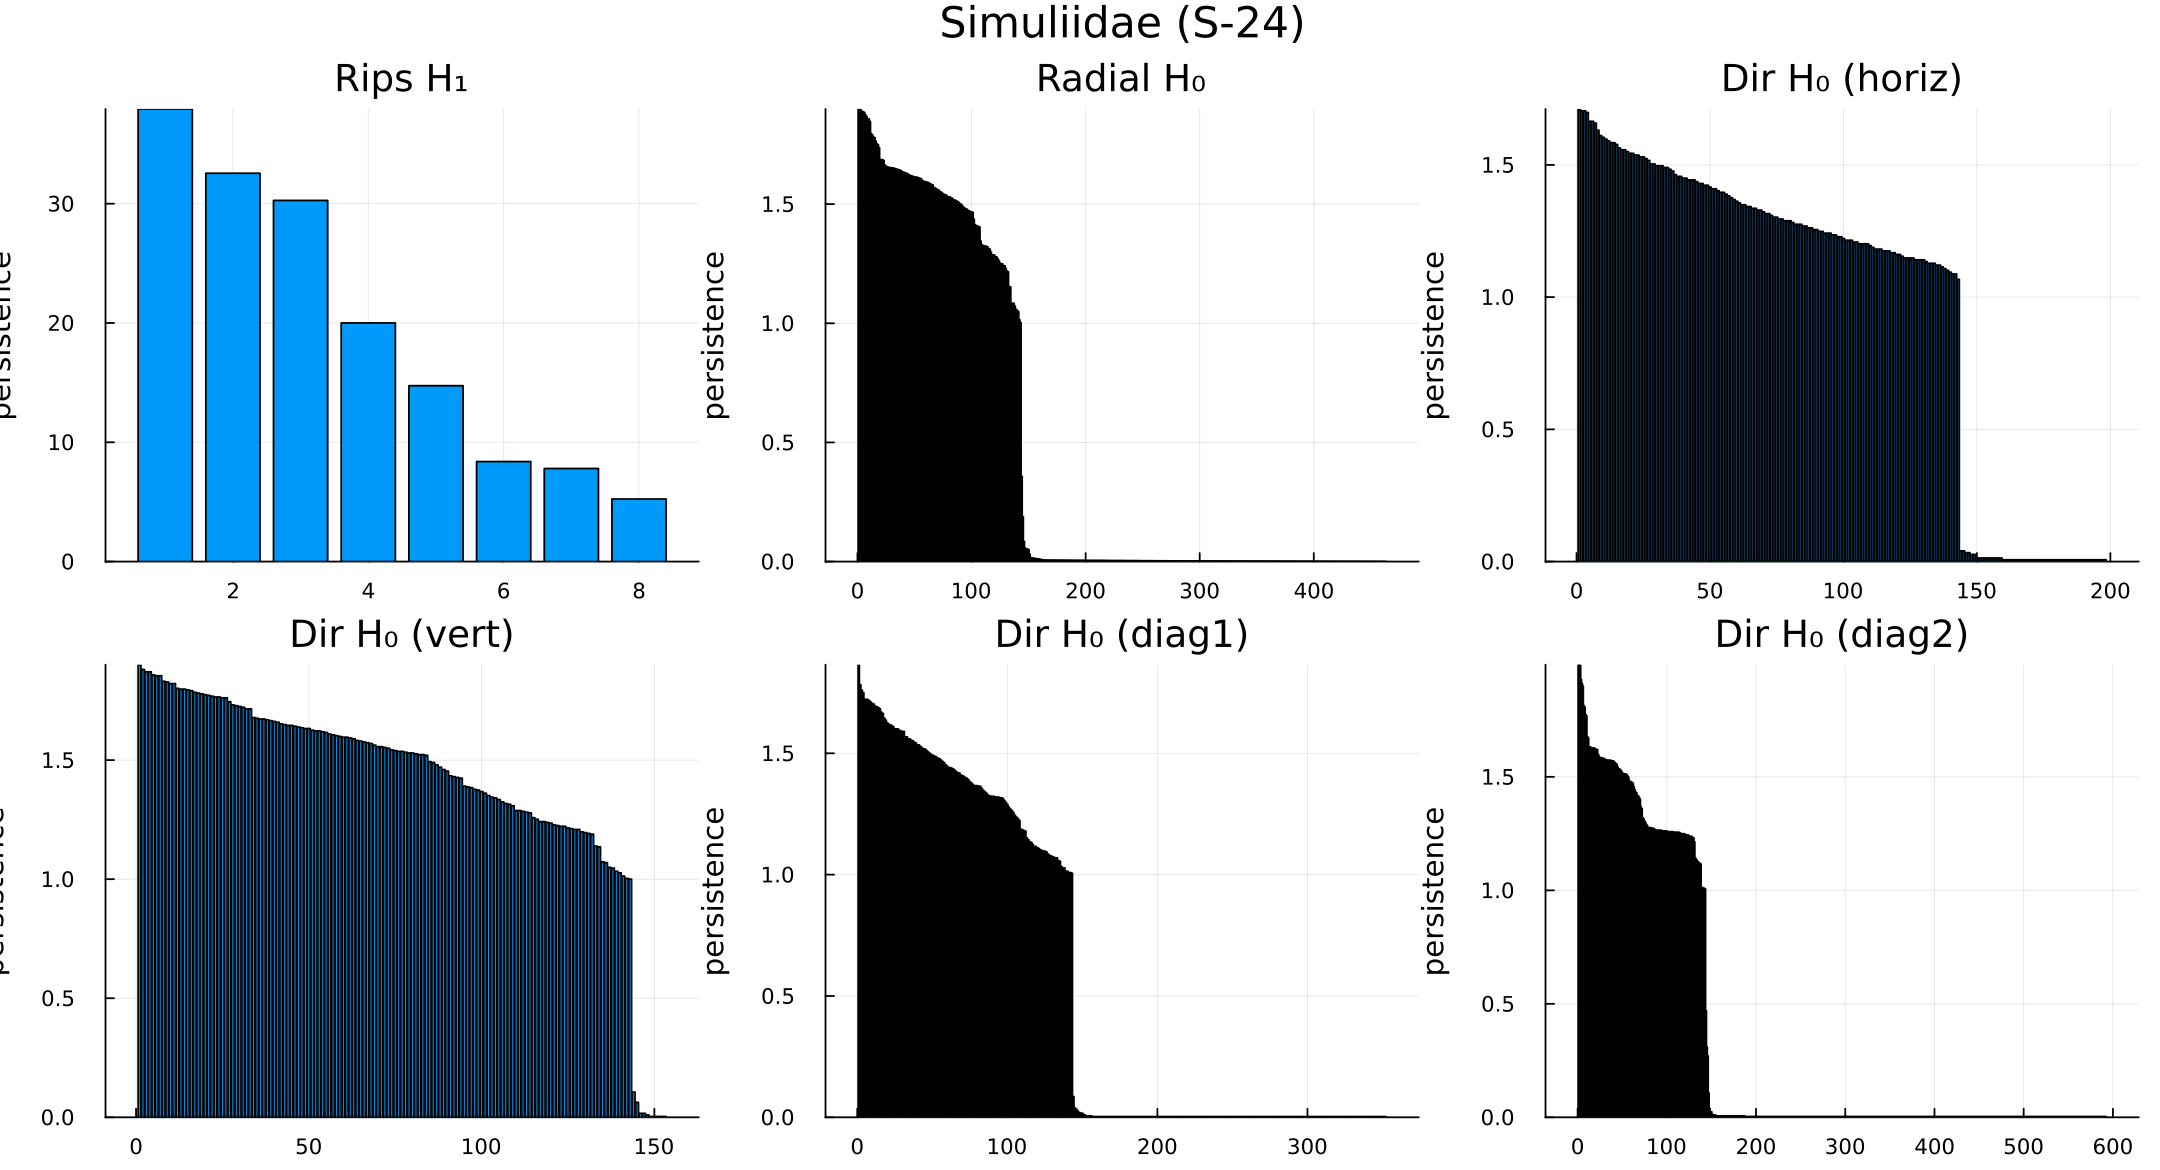


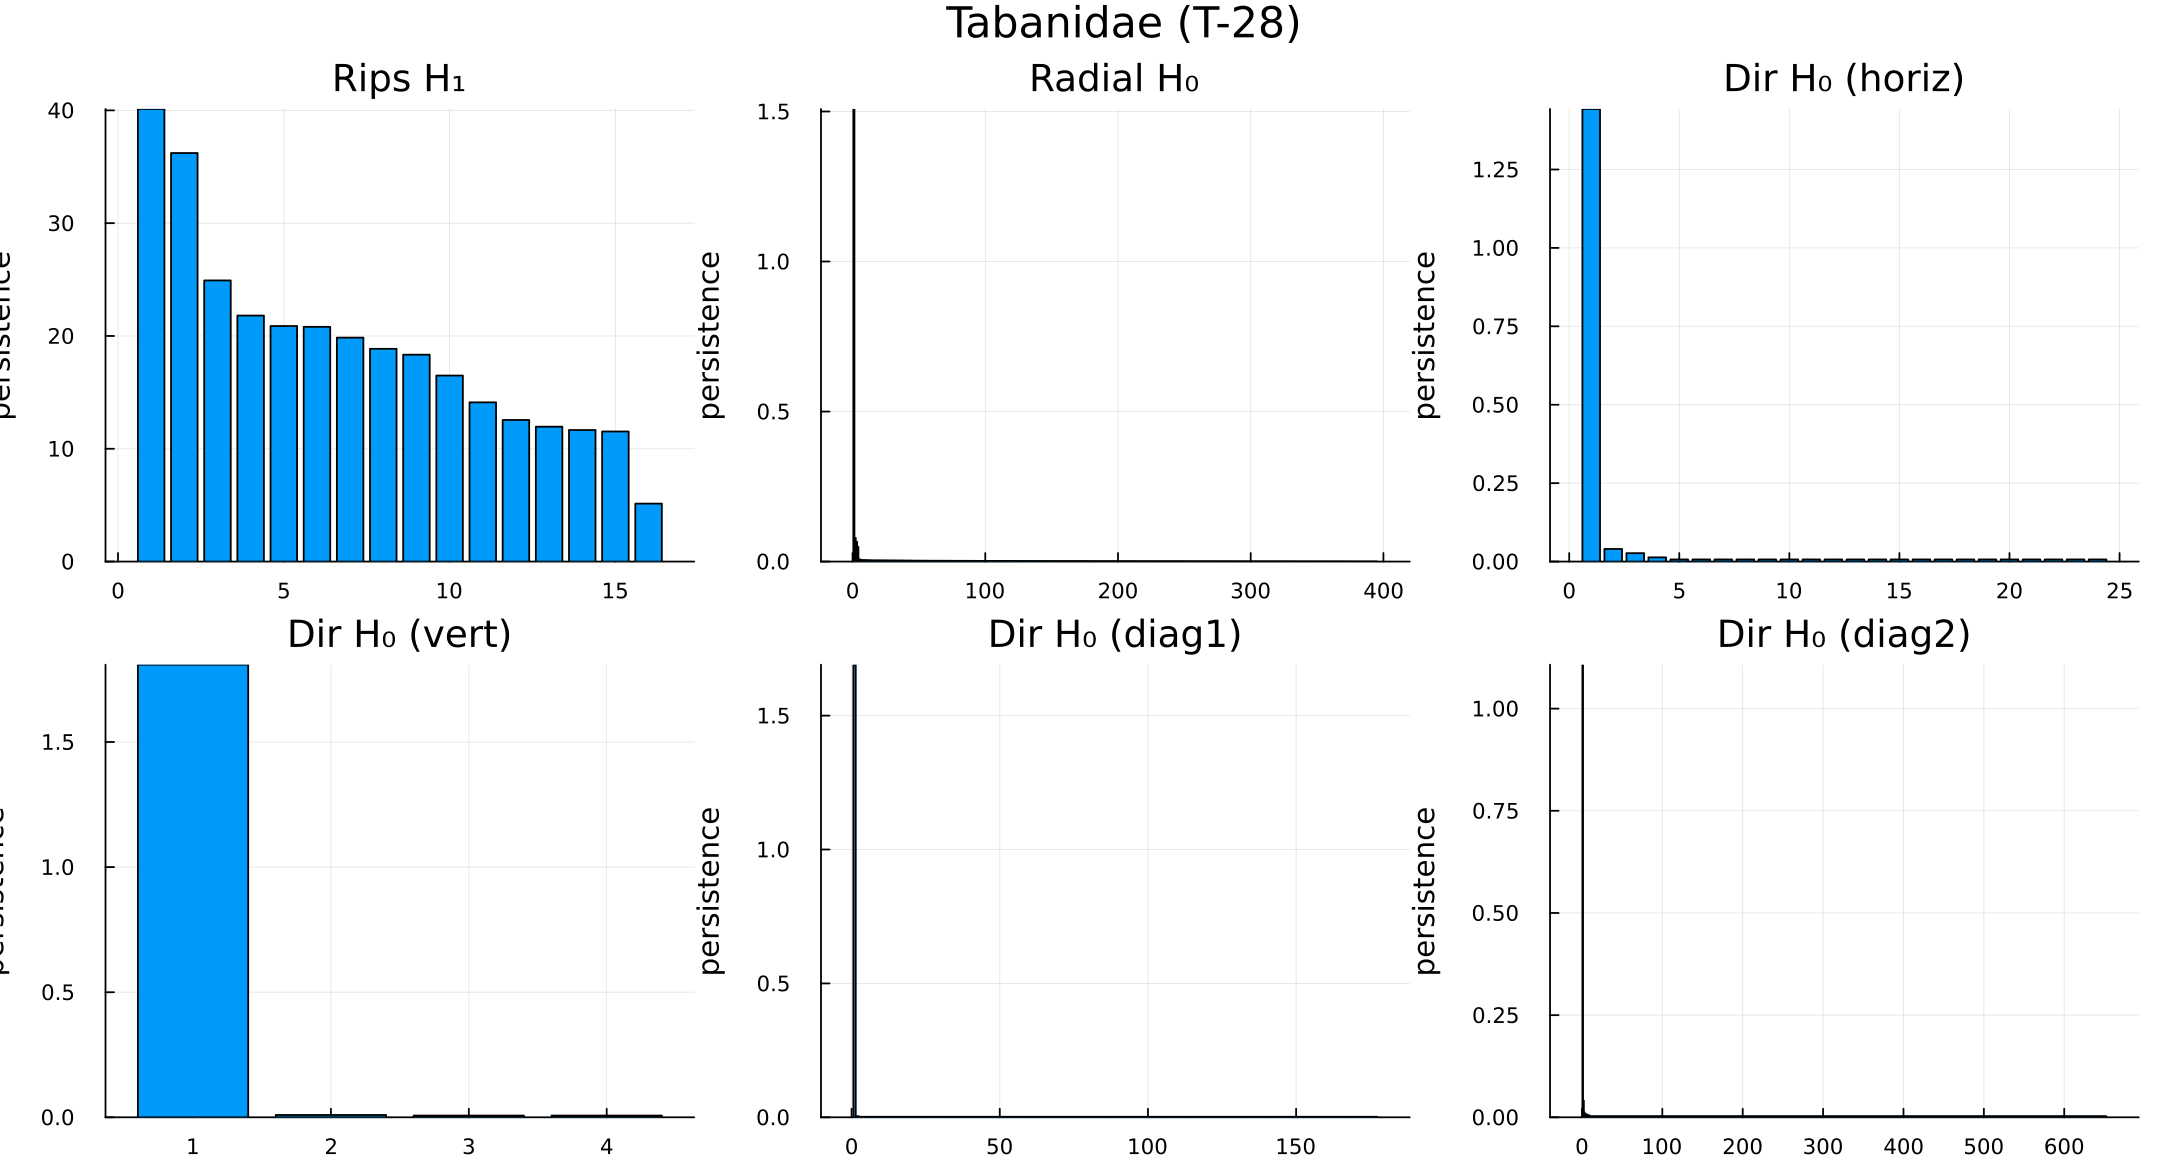


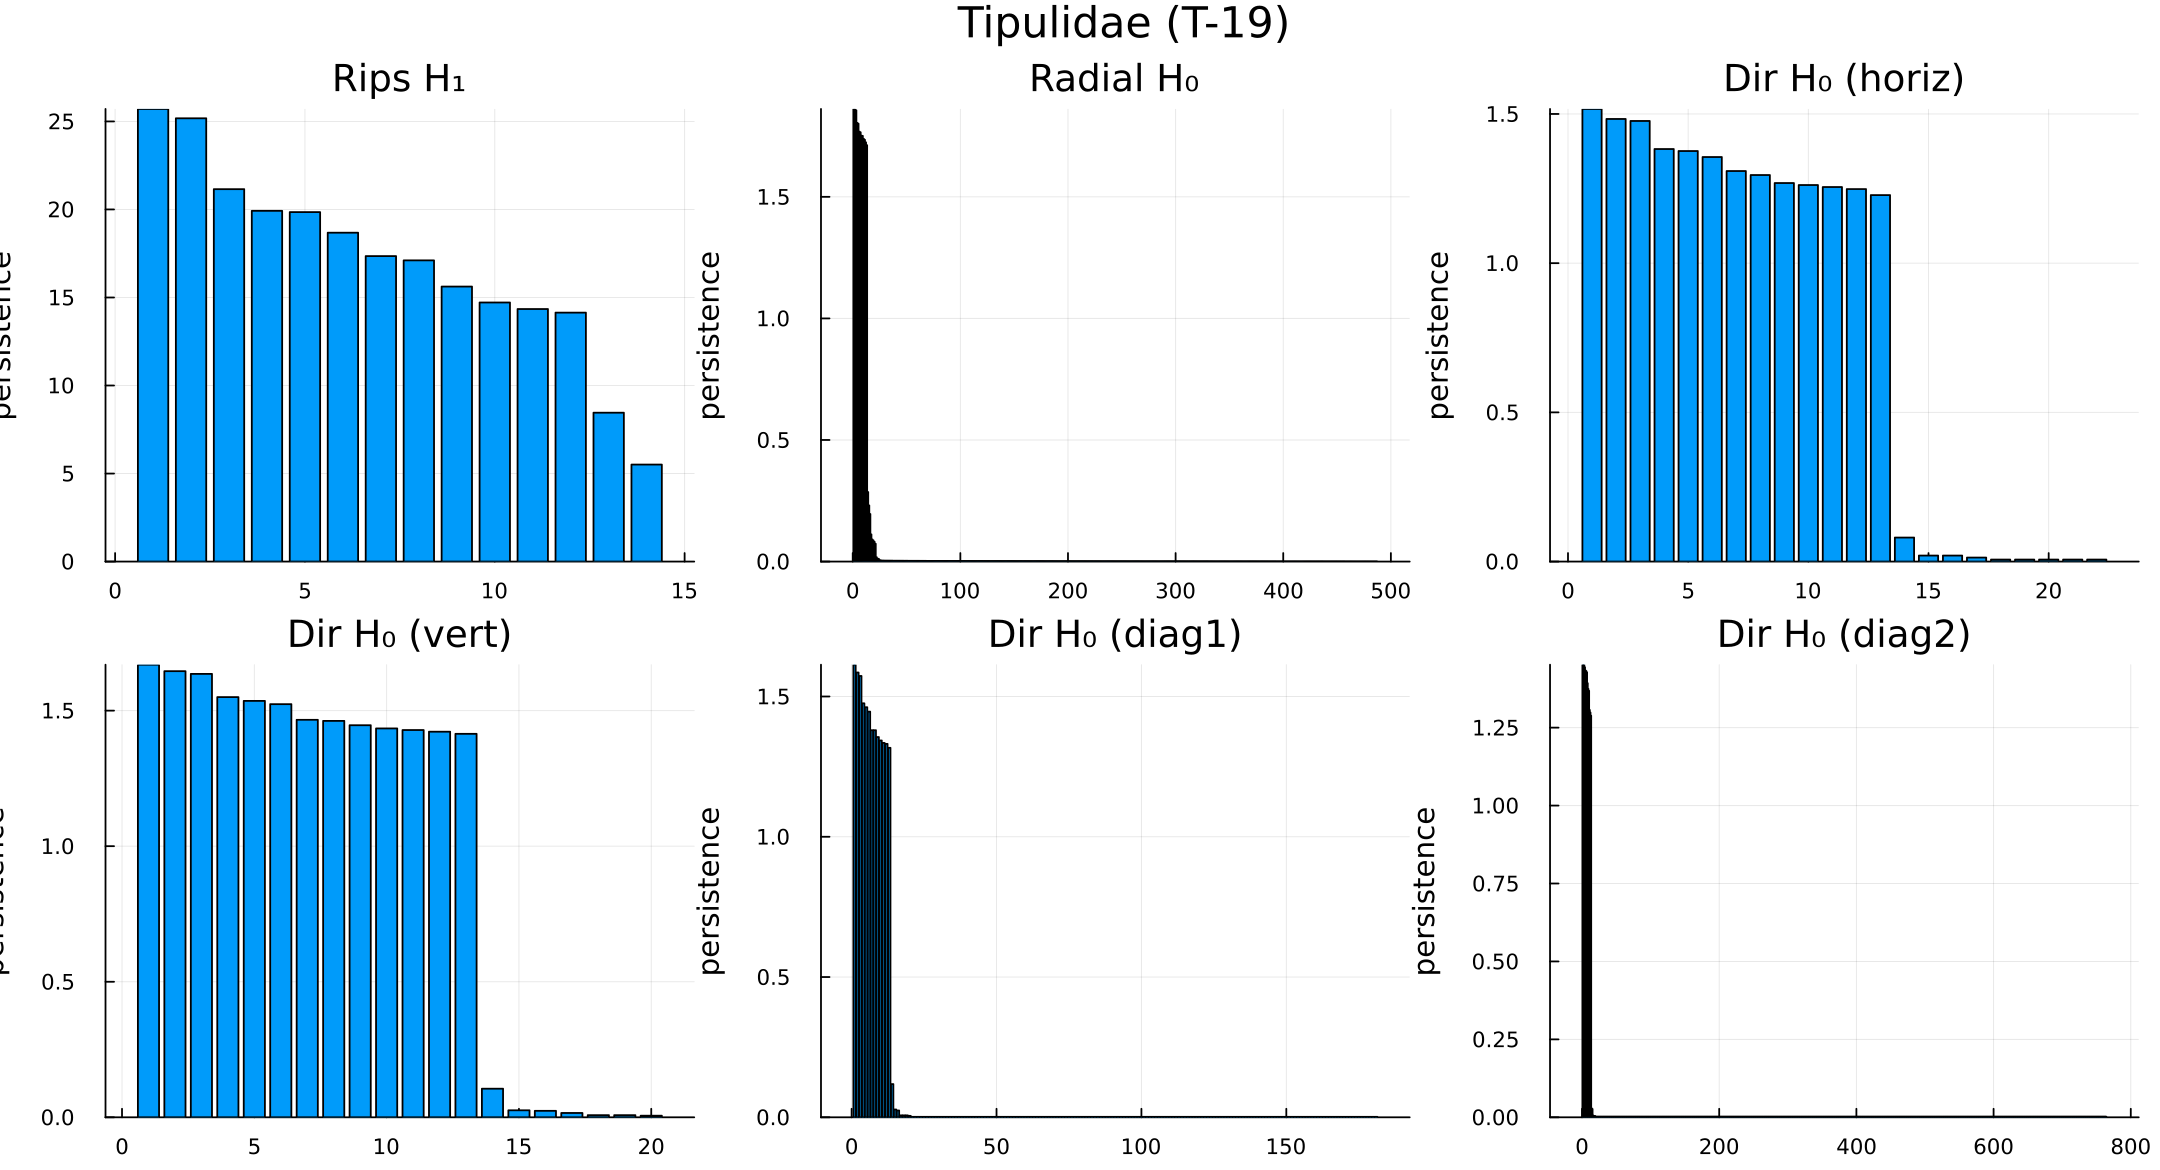

In [18]:
for i in example_indices
    pers_rips = persistence.(pds_rips[i])
    pers_rad_h0 = [persistence(x) for x in pds_radial_h0[i] if isfinite(persistence(x))]

    p1 = isempty(pers_rips) ? plot(title = "Rips H₁ (empty)") :
         bar(sort(pers_rips, rev = true), title = "Rips H₁", legend = false, ylabel = "persistence")
    p2 = isempty(pers_rad_h0) ? plot(title = "Radial H₀ (empty)") :
         bar(sort(pers_rad_h0, rev = true), title = "Radial H₀", legend = false, ylabel = "persistence")

    dir_plots = []
    for (dir, name) in zip(directions, direction_names)
        pers_dir = [persistence(x) for x in pds_dir_h0[name][i] if isfinite(persistence(x))]
        p_dir = isempty(pers_dir) ? plot(title = "Dir H₀ $name (empty)") :
             bar(sort(pers_dir, rev = true), title = "Dir H₀ ($name)", legend = false, ylabel = "persistence")
        push!(dir_plots, p_dir)
    end

    p = plot(p1, p2, dir_plots..., layout = (2, 3), size = (1200, 650),
             plot_title = "$(families[i]) ($(individuals[i]))")
    display(p)
end;

### 3.7 Extended summary statistics

We extract extended summary statistics from each persistence diagram using `pd_statistics_extended`, then remove **skewness** and **kurtosis** (near-zero relevance in tree-based models):

-   **Count** of intervals, **max/total/total²** persistence
-   **Quantiles** (10th, 25th, 50th, 75th, 90th)
-   **Entropy**, **std** of persistence
-   **Median birth**, **median death**, **std birth**, **std death**
-   **Mean midlife** = mean of (birth + death)/2
-   **Persistence range** = max - min persistence

In [19]:
using DecisionTree
using Random: MersenneTwister

all_stat_names_ext = [
    "count", "max_pers", "total_pers", "total_pers2",
    "q10", "q25", "median", "q75", "q90",
    "entropy", "std_pers",
    "skewness", "kurtosis",
    "median_birth", "median_death", "std_birth", "std_death",
    "mean_midlife", "pers_range"
]

drop_stat_names = Set(["skewness", "kurtosis"])
keep_stat_idx = findall(s -> !(s in drop_stat_names), all_stat_names_ext)
stat_names_ext = all_stat_names_ext[keep_stat_idx]

stats_rips_raw = collect(hcat([pd_statistics_extended(pd) for pd in pds_rips]...)')
stats_radial_h0_raw = collect(hcat([pd_statistics_extended(pd) for pd in pds_radial_h0]...)')
stats_rips = stats_rips_raw[:, keep_stat_idx]
stats_radial_h0 = stats_radial_h0_raw[:, keep_stat_idx]

stats_dir_h0_raw = Dict{String, Matrix}()
stats_dir_h0 = Dict{String, Matrix}()
for name in direction_names
    stats_dir_h0_raw[name] = collect(hcat([pd_statistics_extended(pd) for pd in pds_dir_h0[name]]...)')
    stats_dir_h0[name] = stats_dir_h0_raw[name][:, keep_stat_idx]
end

println("Dropped stats: $(join(sort(collect(drop_stat_names)), ", "))")
println("Statistics per diagram retained: $(length(stat_names_ext)) features")
println("  Rips H1: $(size(stats_rips))")
println("  Radial H0: $(size(stats_radial_h0))")
for name in direction_names
    println("  Dir H0 ($name): $(size(stats_dir_h0[name]))")
end

Dropped stats: kurtosis, skewness
Statistics per diagram retained: 17 features
  Rips H1: (70, 17)
  Radial H0: (70, 17)
  Dir H0 (horiz): (70, 17)
  Dir H0 (vert): (70, 17)
  Dir H0 (diag1): (70, 17)
  Dir H0 (diag2): (70, 17)

#### 3.7.1 Statistics comparison by family


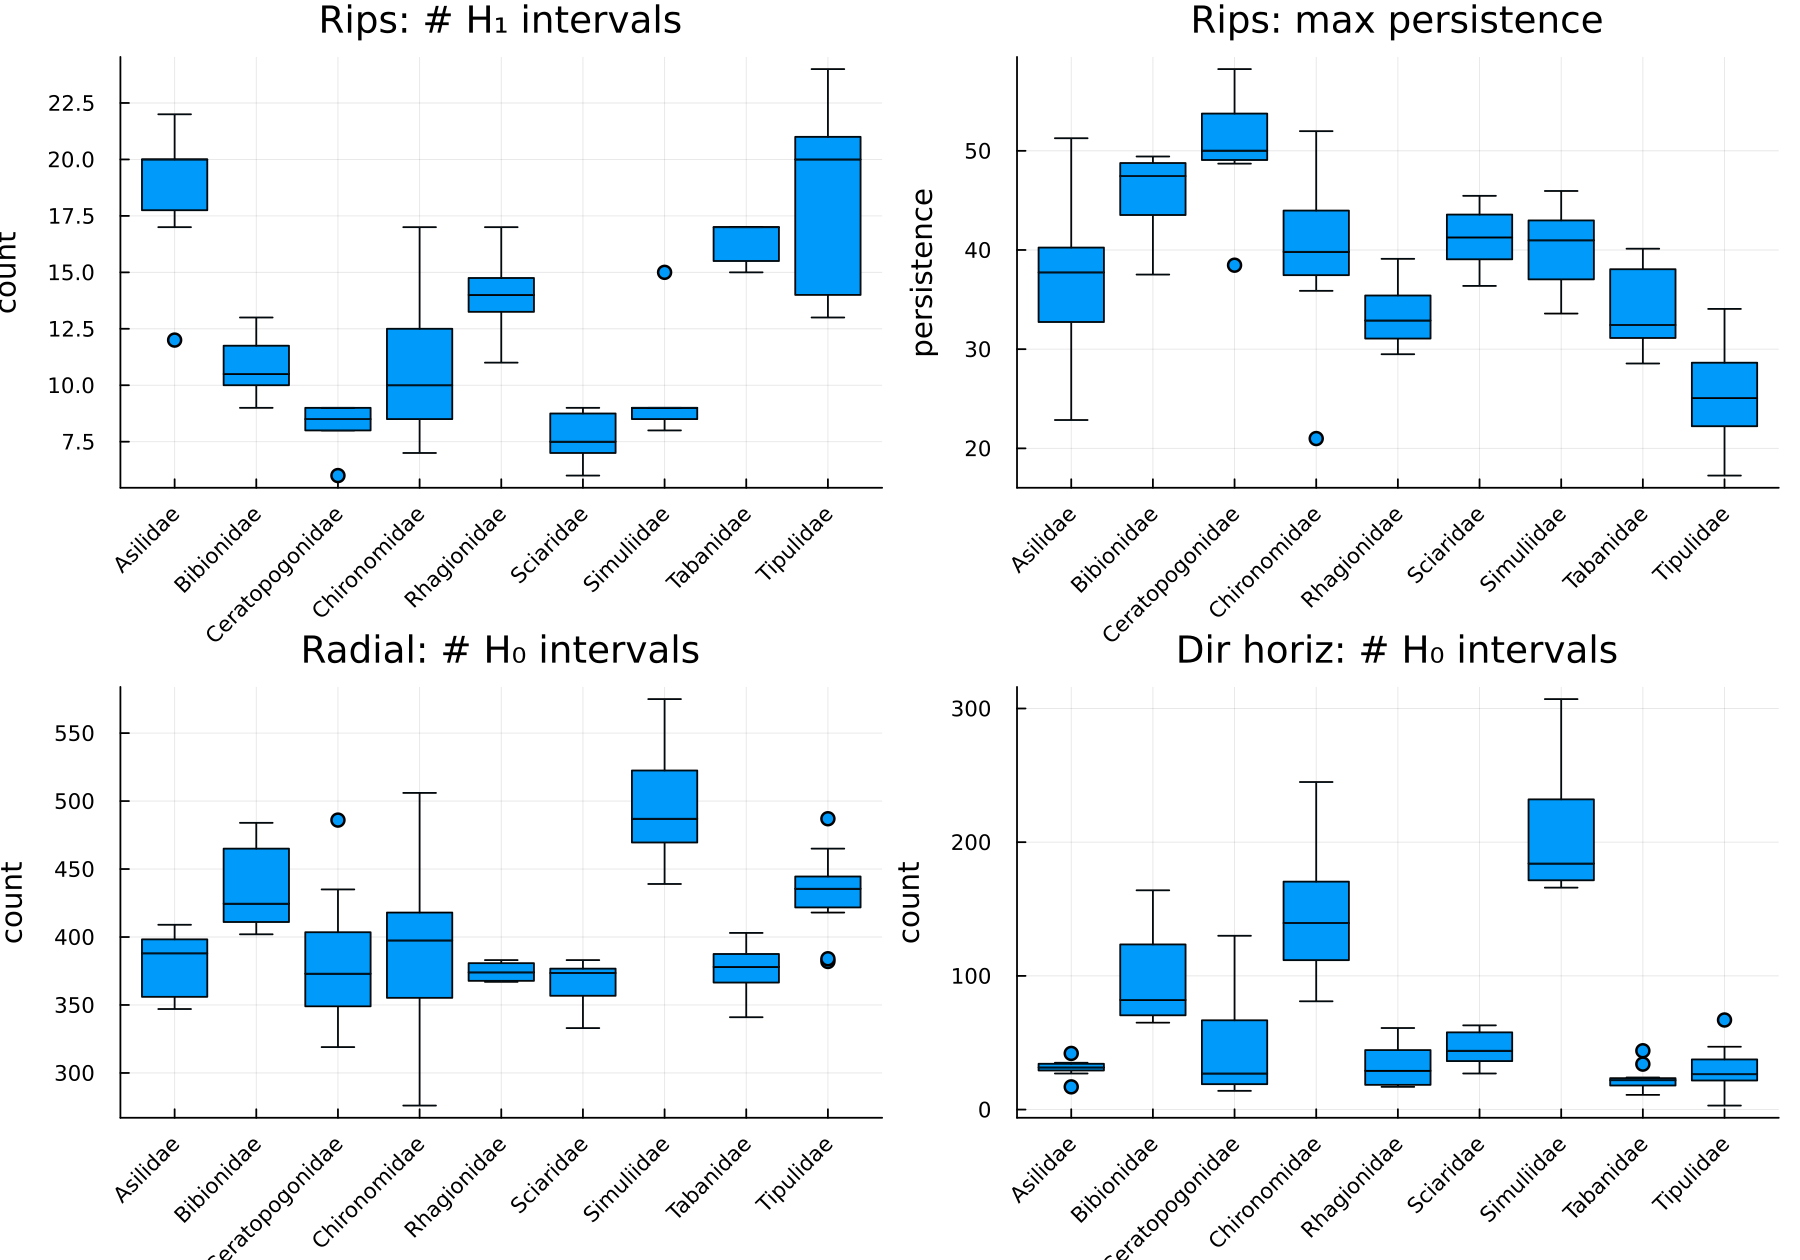

In [20]:
stats_df = DataFrame(
    sample = individuals,
    family = families,
    n_intervals_rips = stats_rips[:, 1],
    max_pers_rips = stats_rips[:, 2],
    entropy_rips = stats_rips[:, 10],
    n_intervals_rad_h0 = stats_radial_h0[:, 1],
    max_pers_rad_h0 = stats_radial_h0[:, 2],
    n_intervals_dir_horiz = stats_dir_h0["horiz"][:, 1],
    n_intervals_dir_vert = stats_dir_h0["vert"][:, 1],
)

p1 = boxplot(stats_df.family, stats_df.n_intervals_rips,
             title = "Rips: # H₁ intervals", legend = false, ylabel = "count", xrotation = 45)
p2 = boxplot(stats_df.family, stats_df.max_pers_rips,
             title = "Rips: max persistence", legend = false, ylabel = "persistence", xrotation = 45)
p3 = boxplot(stats_df.family, stats_df.n_intervals_rad_h0,
             title = "Radial: # H₀ intervals", legend = false, ylabel = "count", xrotation = 45)
p4 = boxplot(stats_df.family, stats_df.n_intervals_dir_horiz,
             title = "Dir horiz: # H₀ intervals", legend = false, ylabel = "count", xrotation = 45)
plot(p1, p2, p3, p4, layout = (2, 2), size = (1000, 700))

## 4 Classification

We build the feature matrix from the extended summary statistics of all filtrations:

In [21]:
labels = families

X_features = hcat(
    stats_rips,                 # 17 features: Rips H1
    stats_radial_h0,            # 17 features: Radial H0
    stats_dir_h0["horiz"],      # 17 features: Dir H0 horizontal
    stats_dir_h0["vert"],       # 17 features: Dir H0 vertical
    stats_dir_h0["diag1"],      # 17 features: Dir H0 diagonal 1
    stats_dir_h0["diag2"],      # 17 features: Dir H0 diagonal 2
) |> sanitize_feature_matrix

feature_blocks = ["Rips_H1", "Radial_H0", "Dir_H0_horiz", "Dir_H0_vert", "Dir_H0_diag1", "Dir_H0_diag2"]
feature_names = ["$(block)__$(stat)" for block in feature_blocks for stat in stat_names_ext]

println("Feature matrix: $(size(X_features))")
println("  Retained stats per diagram: $(length(stat_names_ext))")
println("  $(size(X_features, 2)) features × $(size(X_features, 1)) samples")
println("  Feature-to-sample ratio: $(round(size(X_features, 2) / size(X_features, 1), digits=2))")

Feature matrix: (70, 102)
  Retained stats per diagram: 17
  102 features × 70 samples
  Feature-to-sample ratio: 1.46

> **Leave-one-out cross-validation (LOOCV)**
>
> With only 72 samples, we use **leave-one-out cross-validation**: for each sample, the classifier is trained on all other samples and tested on the held-out one. LOOCV has low bias (nearly the entire dataset is used for training) and is the standard validation strategy for small datasets.

### 4.1 Decision tree

We use a single decision tree as our most interpretable classifier. The tree structure itself provides readable classification rules:

In [22]:
function loocv_decision_tree(X::Matrix, y::Vector{String};
                             max_depth::Int = 6,
                             min_samples_leaf::Int = 2,
                             min_samples_split::Int = 2,
                             rng_seed::Int = 20260223)
    Xclean = sanitize_feature_matrix(X)
    n = size(Xclean, 1)
    predictions = Vector{String}(undef, n)

    for i in 1:n
        train_idx = setdiff(1:n, i)
        X_train = Xclean[train_idx, :]
        y_train = y[train_idx]

        tree = DecisionTree.build_tree(
            y_train,
            X_train,
            size(X_train, 2),
            max_depth,
            min_samples_leaf,
            min_samples_split,
            0.0;
            loss = DecisionTree.util.gini,
            rng = MersenneTwister(rng_seed + i),
            impurity_importance = true
        )

        predictions[i] = DecisionTree.apply_tree(tree, Xclean[i, :])
    end

    (accuracy = mean(predictions .== y), predictions = predictions)
end

tree_results = DataFrame(
    max_depth = Int[],
    min_samples_leaf = Int[],
    n_correct = Int[],
    accuracy = Float64[],
    balanced_accuracy = Float64[],
    macro_f1 = Float64[],
)

for max_depth in [3, 4, 5, 6, 8]
    for min_leaf in [1, 2, 3]
        r = loocv_decision_tree(X_features, labels;
                                max_depth = max_depth, min_samples_leaf = min_leaf, min_samples_split = 2)
        m = classification_metrics(labels, r.predictions)
        push!(tree_results, (
            max_depth, min_leaf,
            sum(r.predictions .== labels),
            r.accuracy, m.balanced_accuracy, m.macro_f1
        ))
    end
end

sort!(tree_results, :accuracy, rev = true)
first(tree_results, 10)

In [23]:
best_tree = tree_results[1, :]

# Build on full data with the best hyperparameters.
# n_subfeatures = size(X_features, 2) means all retained features are candidates at every split.
tree_model = DecisionTree.build_tree(
    labels, X_features, size(X_features, 2),
    best_tree.max_depth, best_tree.min_samples_leaf, 2, 0.0;
    loss = DecisionTree.util.gini,
    rng = MersenneTwister(20260223),
    impurity_importance = true
)

tree_importance = DecisionTree.impurity_importance(tree_model; normalize = true)

tree_importance_df = DataFrame(
    feature = feature_names,
    importance = tree_importance
)
sort!(tree_importance_df, :importance, rev = true)

n_nonzero = count(>(0.0), tree_importance)
println("Best Decision Tree LOOCV: $(best_tree.n_correct)/$(length(labels)) ($(round(best_tree.accuracy * 100, digits = 1))%)")
println("  max_depth=$(best_tree.max_depth), min_samples_leaf=$(best_tree.min_samples_leaf)")
println("  Features considered at each split: $(size(X_features, 2)) (all)")
println("  Features with nonzero importance: $(n_nonzero) / $(size(X_features, 2))")
println("Balanced accuracy: $(round(best_tree.balanced_accuracy * 100, digits = 1))%")

first(filter(:importance => >(0.0), tree_importance_df), 15)

Best Decision Tree LOOCV: 45/70 (64.3%)
  max_depth=8, min_samples_leaf=2
  Features considered at each split: 102 (all)
  Features with nonzero importance: 12 / 102
Balanced accuracy: 64.2%


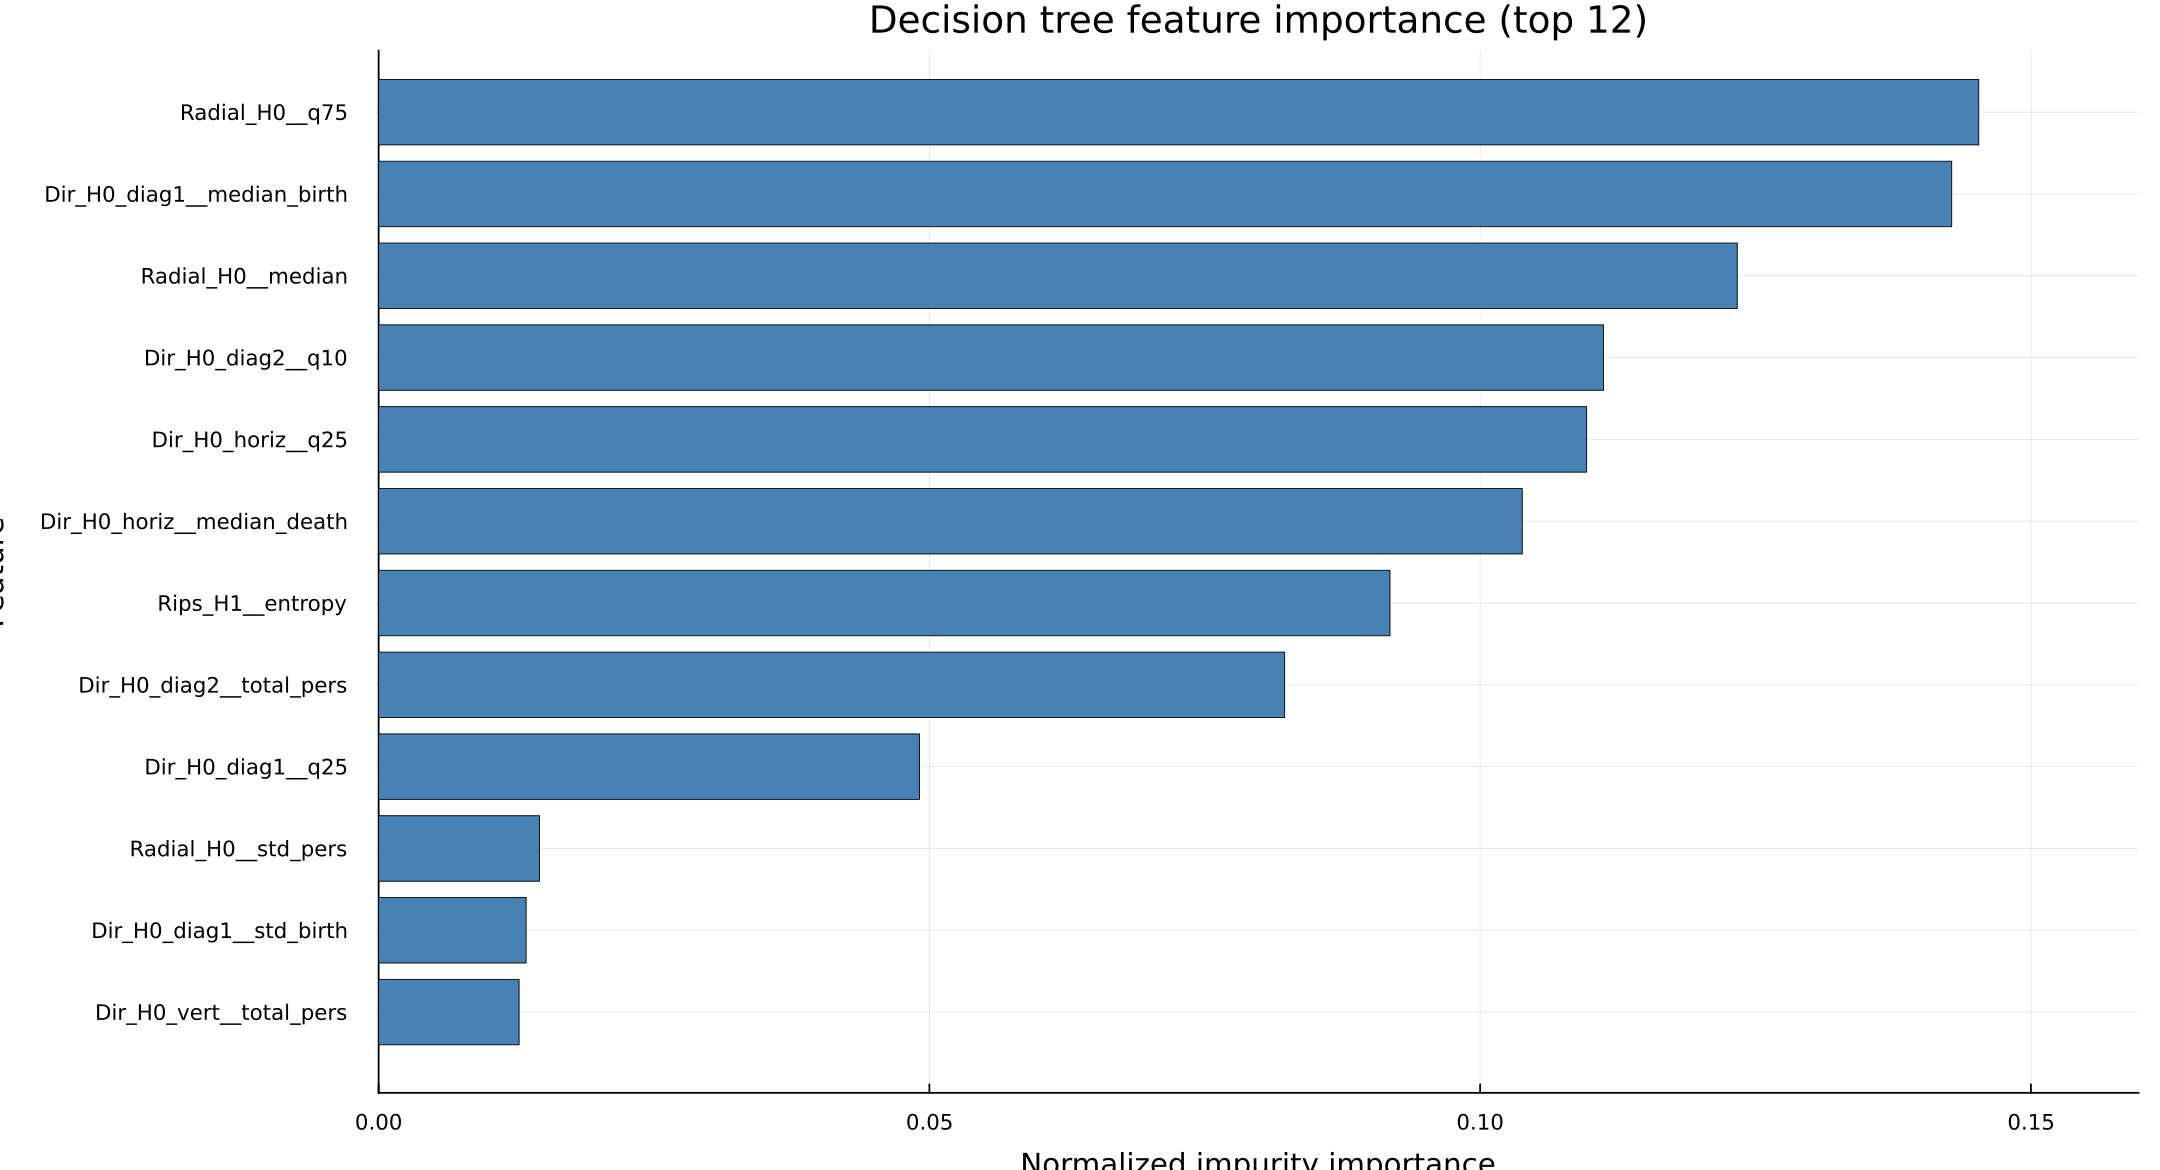


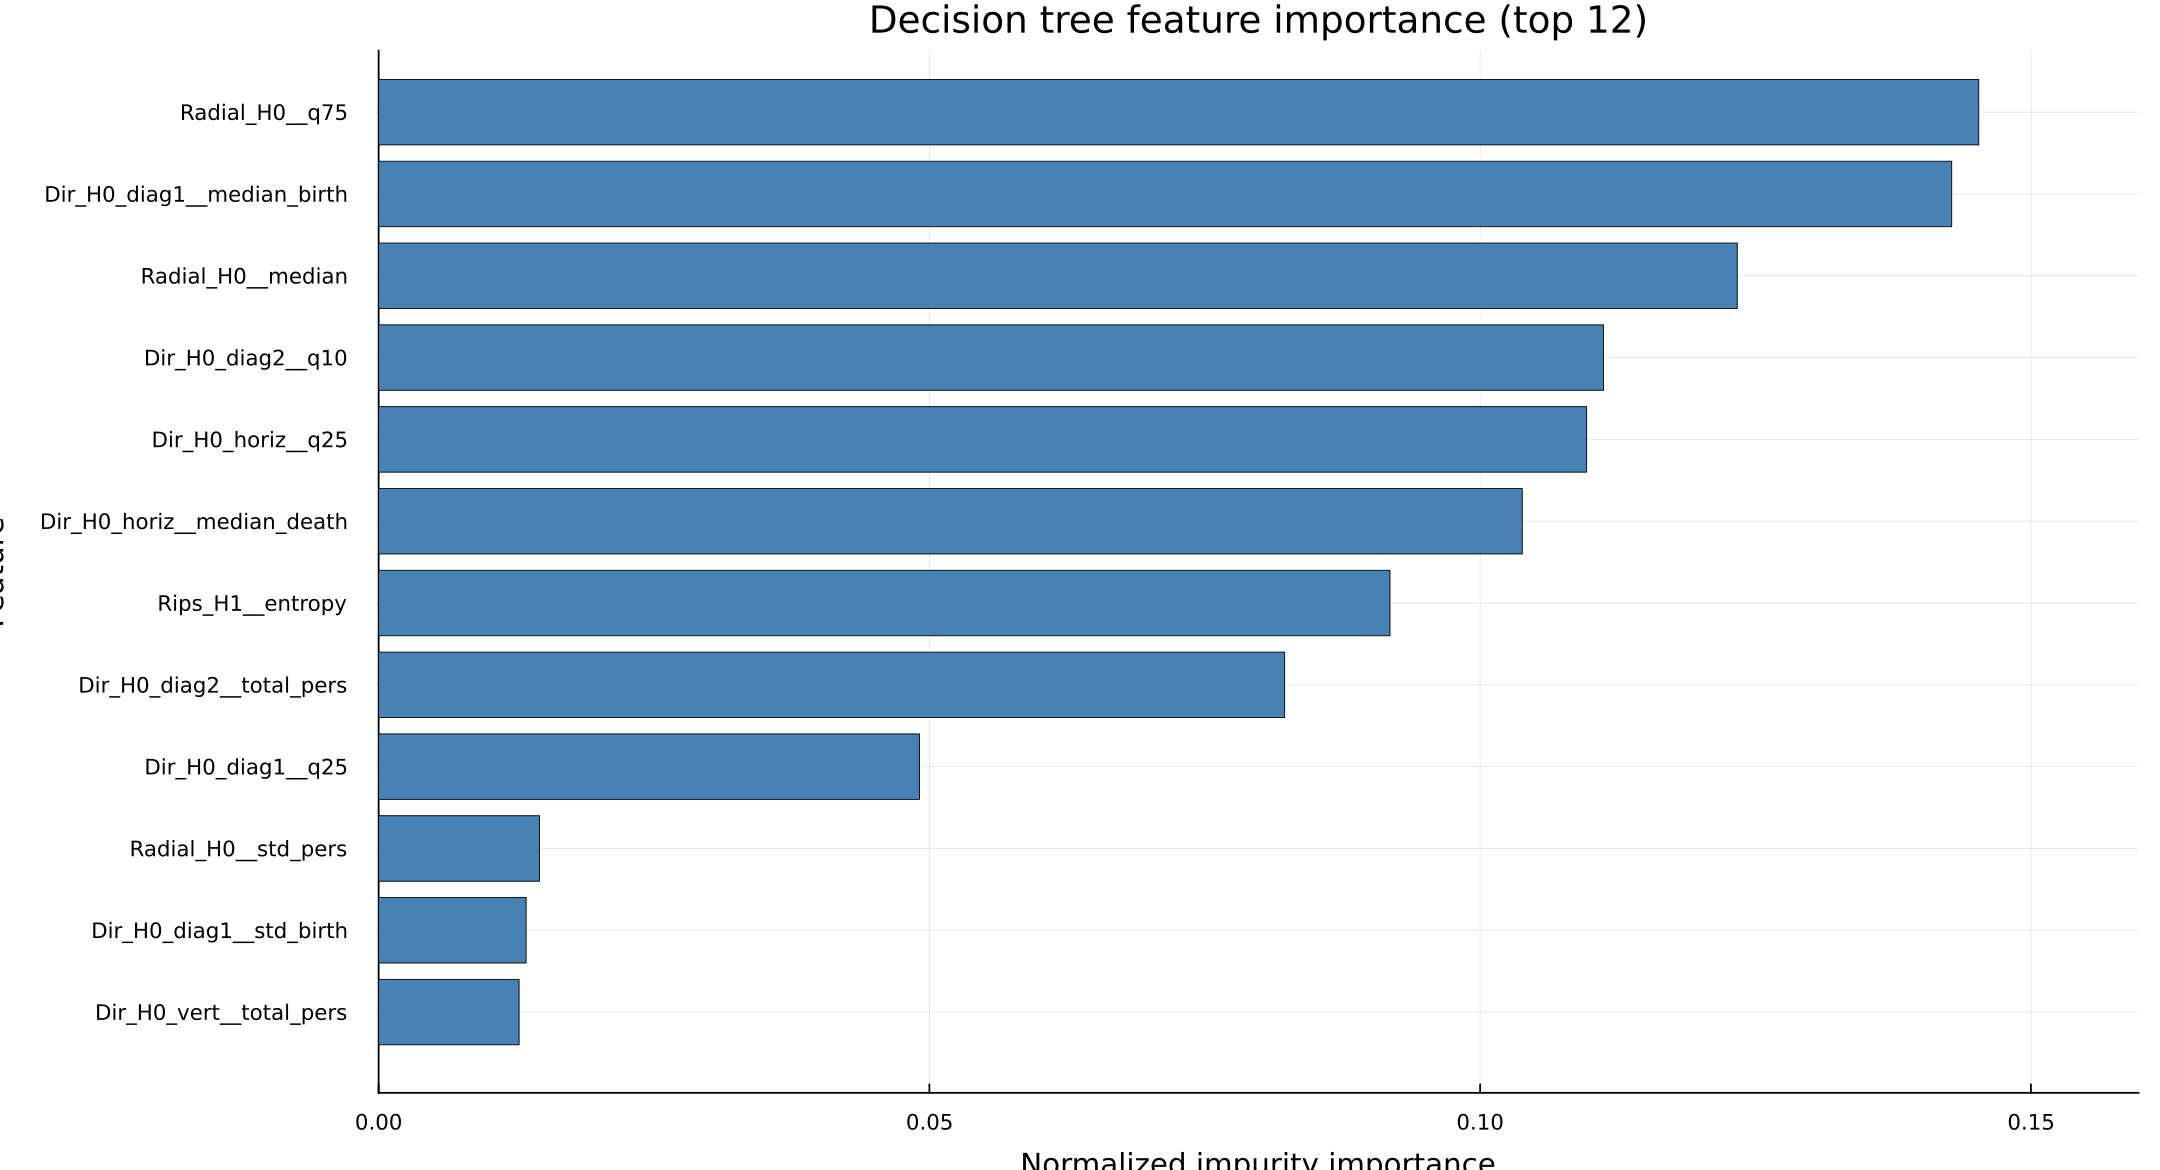

In [24]:
tree_nonzero = filter(:importance => >(0.0), tree_importance_df)
topk = min(12, nrow(tree_nonzero))
top_tree_imp = first(tree_nonzero, topk)

if topk == 0
    println("No nonzero decision-tree importances to plot.")
    p_tree_imp = plot(title = "Decision tree feature importance (no nonzero features)", legend = false)
else
    ord = sortperm(top_tree_imp.importance)
    feat_plot = top_tree_imp.feature[ord]
    imp_plot = top_tree_imp.importance[ord]
    xmax = 1.1 * max(1e-6, maximum(imp_plot))

    p_tree_imp = bar(
        1:topk,
        imp_plot,
        orientation = :horizontal,
        yticks = (1:topk, feat_plot),
        xlabel = "Normalized impurity importance",
        ylabel = "Feature",
        title = "Decision tree feature importance (top $(topk))",
        legend = false,
        fillcolor = :steelblue,
        linecolor = :black,
        linewidth = 0.5,
        xlims = (0.0, xmax),
        size = (1200, 650),
    )
end

display(p_tree_imp)
p_tree_imp

In [25]:
# Also build a deeper display tree (max_depth=10) on the full data so the full structure is visible.
# The LOOCV used best_tree.max_depth; here we go deeper to see which features actually get used.
display_tree = DecisionTree.build_tree(
    labels, X_features, size(X_features, 2),
    10, 1, 2, 0.0;
    loss = DecisionTree.util.gini,
    rng = MersenneTwister(20260223),
    impurity_importance = true
)
display_imp = DecisionTree.impurity_importance(display_tree; normalize = true)
println("Deep display tree (max_depth=10): features with nonzero importance = $(count(>(0.0), display_imp)) / $(length(display_imp))")
println("\nDecision tree structure (LOOCV best, max_depth=$(best_tree.max_depth)):")
print_tree(tree_model, feature_names = feature_names)

Deep display tree (max_depth=10): features with nonzero importance = 14 / 102

Decision tree structure (LOOCV best, max_depth=8):
Feature 25: "Radial_H0__q75" < 0.001729 ?
├─ Feature 28: "Radial_H0__std_pers" < 0.151 ?
    ├─ Tipulidae : 9/9
    └─ Ceratopogonidae : 1/2
└─ Feature 80: "Dir_H0_diag1__median_birth" < 0.6497 ?
    ├─ Feature 24: "Radial_H0__median" < 0.003027 ?
        ├─ Feature 47: "Dir_H0_horiz__median_death" < 0.104 ?
            ├─ Feature 82: "Dir_H0_diag1__std_birth" < 0.3258 ?
                ├─ Asilidae : 1/2
                └─ Asilidae : 6/6
            └─ Feature 90: "Dir_H0_diag2__q10" < 0.001965 ?
                ├─ Chironomidae : 7/7
                └─ Feature 10: "Rips_H1__entropy" < 2.005 ?
                    ├─ Feature 40: "Dir_H0_horiz__q25" < 0.006711 ?
                        ├─ Feature 54: "Dir_H0_vert__total_pers" < 38.16 ?
                            ├─ Sciaridae : 5/5
                            └─ Sciaridae : 1/2
                        └─ Cerato

### 4.2 LDA (Linear Discriminant Analysis)

> **Linear Discriminant Analysis (LDA)**
>
> **LDA** finds a linear projection of the feature space that maximizes the ratio of between-class variance to within-class variance. The projected data is then classified with a simple 1-NN rule. LDA is a classical method that works well when classes are approximately Gaussian and the number of features is not too large relative to the number of samples.

In [26]:
r_lda = loocv_lda(X_features, labels)
m_lda = classification_metrics(labels, r_lda.predictions)
println("LDA LOOCV: $(sum(r_lda.predictions .== labels))/$(length(labels)) ($(round(r_lda.accuracy * 100, digits=1))%)")
println("Balanced accuracy: $(round(m_lda.balanced_accuracy * 100, digits=1))%")
println("Macro-F1: $(round(m_lda.macro_f1 * 100, digits=1))%")

LDA LOOCV: 42/70 (60.0%)
Balanced accuracy: 55.9%
Macro-F1: 54.7%

### 4.3 Balanced Random Forest

> **Random Forest**
>
> A **Random Forest** is an ensemble of decision trees, each trained on a bootstrap sample of the data using a random subset of features. The final prediction is the majority vote across all trees. **Balanced** Random Forests oversample minority classes (or weight them inversely to their frequency) so that rare families are not drowned out by common ones — important here because Tipulidae has 12 samples while some families have only 2–3. Random Forests are robust to overfitting, handle high-dimensional features well, and provide built-in feature importance estimates.

In [27]:
rf_grid = []
for n_trees in [100, 200, 500, 1000]
    for max_depth in [-1, 8, 12]
        for min_leaf in [1, 2]
            r = loocv_random_forest_balanced(X_features, labels;
                    n_trees = n_trees, max_depth = max_depth,
                    min_samples_leaf = min_leaf, rng_seed = 20260223)
            m = classification_metrics(labels, r.predictions)
            push!(rf_grid, (
                n_trees = n_trees, max_depth = max_depth, min_leaf = min_leaf,
                n_correct = sum(r.predictions .== labels),
                accuracy = r.accuracy,
                balanced_accuracy = m.balanced_accuracy,
                macro_f1 = m.macro_f1,
            ))
        end
    end
end

rf_grid_df = DataFrame(rf_grid)
sort!(rf_grid_df, :accuracy, rev = true)
first(rf_grid_df, 8)

In [28]:
best_rf_row = rf_grid_df[1, :]
r_rf = loocv_random_forest_balanced(X_features, labels;
            n_trees = best_rf_row.n_trees, max_depth = best_rf_row.max_depth,
            min_samples_leaf = best_rf_row.min_leaf, rng_seed = 20260223)
m_rf = classification_metrics(labels, r_rf.predictions)
println("Best Balanced RF LOOCV: $(sum(r_rf.predictions .== labels))/$(length(labels)) ($(round(r_rf.accuracy * 100, digits=1))%)")
println("  n_trees=$(best_rf_row.n_trees), max_depth=$(best_rf_row.max_depth), min_leaf=$(best_rf_row.min_leaf)")
println("  n_features per split: $(max(1, round(Int, sqrt(size(X_features, 2))))) (√$(size(X_features, 2)))")
println("Balanced accuracy: $(round(m_rf.balanced_accuracy * 100, digits=1))%")
println("Macro-F1: $(round(m_rf.macro_f1 * 100, digits=1))%")

Best Balanced RF LOOCV: 55/70 (78.6%)
  n_trees=200, max_depth=-1, min_leaf=1
  n_features per split: 10 (√102)
Balanced accuracy: 77.7%
Macro-F1: 77.2%

### 4.4 SVM

> **Support Vector Machine (SVM)**
>
> An **SVM** finds the hyperplane that maximizes the margin between classes. The **RBF (Radial Basis Function) kernel** maps data into a high-dimensional space where linear separation becomes possible, controlled by a regularization parameter $C$ (penalty for misclassification): small $C$ allows wider margins with more misclassifications, large $C$ enforces tight boundaries. The **linear kernel** finds a separating hyperplane directly in the original feature space and is less prone to overfitting when $p \gg n$.

In [29]:
svm_results = []
for kernel in [LIBSVM.Kernel.RadialBasis, LIBSVM.Kernel.Linear]
    for cost in [0.01, 0.1, 1.0, 10.0, 100.0]
        kernel_name = kernel == LIBSVM.Kernel.RadialBasis ? "RBF" : "Linear"
        r = loocv_svm(X_features, labels; kernel = kernel, cost = cost)
        m = classification_metrics(labels, r.predictions)
        push!(svm_results, (
            method = "SVM ($kernel_name, C=$cost)",
            n_correct = sum(r.predictions .== labels),
            n_total = length(labels),
            accuracy = r.accuracy,
            balanced_accuracy = m.balanced_accuracy,
            macro_f1 = m.macro_f1,
        ))
    end
end

svm_df = DataFrame(svm_results)
sort!(svm_df, :accuracy, rev = true)
first(svm_df, 8)

In [30]:
best_svm_row = svm_df[1, :]
println("Best SVM (selected on the same LOOCV table; optimistic): $(best_svm_row.method)")
println("  $(best_svm_row.n_correct)/$(best_svm_row.n_total) ($(round(best_svm_row.accuracy * 100, digits=1))%)")
println("  Balanced accuracy: $(round(best_svm_row.balanced_accuracy * 100, digits=1))%")
println("  Macro-F1: $(round(best_svm_row.macro_f1 * 100, digits=1))%")

# Honest estimate: outer LOOCV, with kernel/C selected in inner CV only.
nested_svm = nested_loocv_svm(
    X_features, labels;
    kernels = [LIBSVM.Kernel.RadialBasis, LIBSVM.Kernel.Linear],
    costs = [0.01, 0.1, 1.0, 10.0, 100.0],
    use_pca = false,
    inner_folds = 5,
    rng_seed = 20260223
)
nested_svm_n_correct = sum(nested_svm.predictions .== labels)

println("\nSVM Nested LOOCV (honest estimate):")
println("  $(nested_svm_n_correct)/$(length(labels)) ($(round(nested_svm.accuracy * 100, digits=1))%)")
println("  Balanced accuracy: $(round(nested_svm.balanced_accuracy * 100, digits=1))%")
println("  Macro-F1: $(round(nested_svm.macro_f1 * 100, digits=1))%")

params_df = DataFrame(nested_svm.params)
param_usage = combine(groupby(params_df, [:kernel, :cost]), nrow => :n_outer_folds)
sort!(param_usage, :n_outer_folds, rev = true)
param_usage

Best SVM (selected on the same LOOCV table; optimistic): SVM (Linear, C=1.0)
  57/70 (81.4%)
  Balanced accuracy: 77.7%
  Macro-F1: 77.7%

SVM Nested LOOCV (honest estimate):
  56/70 (80.0%)
  Balanced accuracy: 76.3%
  Macro-F1: 76.3%

### 4.5 SVM with PCA dimensionality reduction

To reduce overfitting risk, we project features with PCA inside each LOOCV fold, then train SVM on the reduced space. We scan different variance-retention targets and kernels/costs to identify a good dimensionality.

In [31]:
svm_pca_results = []
for variance_ratio in [0.70, 0.80, 0.90, 0.95, 0.98]
    for kernel in [LIBSVM.Kernel.RadialBasis, LIBSVM.Kernel.Linear]
        for cost in [0.1, 1.0, 10.0]
            kernel_name = kernel == LIBSVM.Kernel.RadialBasis ? "RBF" : "Linear"
            r = loocv_svm_pca(
                X_features, labels;
                variance_ratio = variance_ratio,
                kernel = kernel,
                cost = cost
            )
            m = classification_metrics(labels, r.predictions)
            push!(svm_pca_results, (
                variance_ratio = variance_ratio,
                median_n_components = r.median_n_components,
                kernel = kernel_name,
                cost = cost,
                n_correct = sum(r.predictions .== labels),
                n_total = length(labels),
                accuracy = r.accuracy,
                balanced_accuracy = m.balanced_accuracy,
                macro_f1 = m.macro_f1,
            ))
        end
    end
end

svm_pca_df = DataFrame(svm_pca_results)
sort!(svm_pca_df, [:balanced_accuracy, :accuracy, :median_n_components], rev = [true, true, false])
first(svm_pca_df, 10)

In [32]:
best_svm_pca = svm_pca_df[1, :]

println("Selected SVM+PCA setting (LOOCV table):")
println("  kernel=$(best_svm_pca.kernel), C=$(best_svm_pca.cost)")
println("  variance ratio=$(round(best_svm_pca.variance_ratio * 100, digits=1))%")
println("  median retained dimensions=$(best_svm_pca.median_n_components)")
println("  accuracy=$(best_svm_pca.n_correct)/$(best_svm_pca.n_total) ($(round(best_svm_pca.accuracy * 100, digits=1))%)")
println("  balanced accuracy=$(round(best_svm_pca.balanced_accuracy * 100, digits=1))%")
println("  macro-F1=$(round(best_svm_pca.macro_f1 * 100, digits=1))%")

# Honest estimate with nested LOOCV, using the selected PCA variance ratio.
nested_svm_pca = nested_loocv_svm(
    X_features, labels;
    kernels = [LIBSVM.Kernel.RadialBasis, LIBSVM.Kernel.Linear],
    costs = [0.1, 1.0, 10.0],
    use_pca = true,
    variance_ratio = best_svm_pca.variance_ratio,
    inner_folds = 5,
    rng_seed = 20260223
)
nested_svm_pca_n_correct = sum(nested_svm_pca.predictions .== labels)

println("\nSVM+PCA Nested LOOCV:")
println("  $(nested_svm_pca_n_correct)/$(length(labels)) ($(round(nested_svm_pca.accuracy * 100, digits=1))%)")
println("  Balanced accuracy: $(round(nested_svm_pca.balanced_accuracy * 100, digits=1))%")
println("  Macro-F1: $(round(nested_svm_pca.macro_f1 * 100, digits=1))%")

Selected SVM+PCA setting (LOOCV table):
  kernel=Linear, C=1.0
  variance ratio=98.0%
  median retained dimensions=25
  accuracy=55/70 (78.6%)
  balanced accuracy=75.3%
  macro-F1=75.0%

SVM+PCA Nested LOOCV:
  54/70 (77.1%)
  Balanced accuracy: 73.9%
  Macro-F1: 73.6%

### 4.6 SVM using only Vietoris-Rips H1 statistics

This analysis keeps only features from the 1D Vietoris-Rips barcode (`stats_rips`) and tests whether loop-based global topology alone is sufficient for classification.

In [33]:
X_rips_only = sanitize_feature_matrix(stats_rips)

svm_rips_results = []
for kernel in [LIBSVM.Kernel.RadialBasis, LIBSVM.Kernel.Linear]
    for cost in [0.01, 0.1, 1.0, 10.0, 100.0]
        kernel_name = kernel == LIBSVM.Kernel.RadialBasis ? "RBF" : "Linear"
        r = loocv_svm(X_rips_only, labels; kernel = kernel, cost = cost)
        m = classification_metrics(labels, r.predictions)
        push!(svm_rips_results, (
            method = "SVM Rips H1 ($kernel_name, C=$cost)",
            n_correct = sum(r.predictions .== labels),
            n_total = length(labels),
            accuracy = r.accuracy,
            balanced_accuracy = m.balanced_accuracy,
            macro_f1 = m.macro_f1,
        ))
    end
end

svm_rips_df = DataFrame(svm_rips_results)
sort!(svm_rips_df, :accuracy, rev = true)
first(svm_rips_df, 8)

In [34]:
best_svm_rips = svm_rips_df[1, :]
println("Best SVM with Rips-only stats:")
println("  $(best_svm_rips.method)")
println("  $(best_svm_rips.n_correct)/$(best_svm_rips.n_total) ($(round(best_svm_rips.accuracy * 100, digits=1))%)")
println("  Balanced accuracy: $(round(best_svm_rips.balanced_accuracy * 100, digits=1))%")
println("  Macro-F1: $(round(best_svm_rips.macro_f1 * 100, digits=1))%")

nested_svm_rips = nested_loocv_svm(
    X_rips_only, labels;
    kernels = [LIBSVM.Kernel.RadialBasis, LIBSVM.Kernel.Linear],
    costs = [0.01, 0.1, 1.0, 10.0, 100.0],
    use_pca = false,
    inner_folds = 5,
    rng_seed = 20260223
)
nested_svm_rips_n_correct = sum(nested_svm_rips.predictions .== labels)

println("\nSVM Rips-only Nested LOOCV:")
println("  $(nested_svm_rips_n_correct)/$(length(labels)) ($(round(nested_svm_rips.accuracy * 100, digits=1))%)")
println("  Balanced accuracy: $(round(nested_svm_rips.balanced_accuracy * 100, digits=1))%")
println("  Macro-F1: $(round(nested_svm_rips.macro_f1 * 100, digits=1))%")

Best SVM with Rips-only stats:
  SVM Rips H1 (RBF, C=10.0)
  44/70 (62.9%)
  Balanced accuracy: 56.7%
  Macro-F1: 56.5%

SVM Rips-only Nested LOOCV:
  41/70 (58.6%)
  Balanced accuracy: 52.1%
  Macro-F1: 51.3%

### 4.7 k-NN on Rips Wasserstein distance

> **Wasserstein distance between persistence diagrams**
>
> The **Wasserstein distance** $W_q$ between two persistence diagrams is the cost of the optimal matching between their points (including matching points to the diagonal, representing trivial features). With $q=1$ it equals the Earth Mover’s Distance; with $q=2$ it penalizes large mismatches more heavily.
>
> **k-Nearest Neighbors (k-NN)** classifies a query by majority vote among its $k$ nearest neighbors in the distance matrix. With $k=1$, this is the simplest possible classifier — completely hyperparameter-free — and serves as a useful baseline.

As a complementary approach, we compute pairwise Wasserstein distances between the Rips H1 persistence diagrams and classify with k-NN. Unlike the feature-based classifiers above, this operates directly on the persistence diagrams without extracting summary statistics, and is therefore less susceptible to information loss during featurization.

In [35]:
D_wass1_rips_raw = wasserstein_distance_matrix(pds_rips, q = 1)
D_wass2_rips_raw = wasserstein_distance_matrix(pds_rips, q = 2)

D_wass1_rips = sanitize_distance_matrix(D_wass1_rips_raw)
D_wass2_rips = sanitize_distance_matrix(D_wass2_rips_raw)

println("Rips W1 non-finite entries (raw): $(count(!isfinite, D_wass1_rips_raw))")
println("Rips W2 non-finite entries (raw): $(count(!isfinite, D_wass2_rips_raw))")

knn_wass_results = []
for (name, D) in [("Wass-1", D_wass1_rips), ("Wass-2", D_wass2_rips)]
    for k in [1, 3, 5]
        r = loocv_knn(D, labels; k = k)
        m = classification_metrics(labels, r.predictions)
        push!(knn_wass_results, (
            method = "$(k)-NN Rips $name",
            n_correct = sum(r.predictions .== labels),
            n_total = length(labels),
            accuracy = r.accuracy,
            balanced_accuracy = m.balanced_accuracy,
            macro_f1 = m.macro_f1,
        ))
    end
end

knn_wass_df = DataFrame(knn_wass_results)
sort!(knn_wass_df, :accuracy, rev = true)
knn_wass_df

Rips W1 non-finite entries (raw): 0
Rips W2 non-finite entries (raw): 0


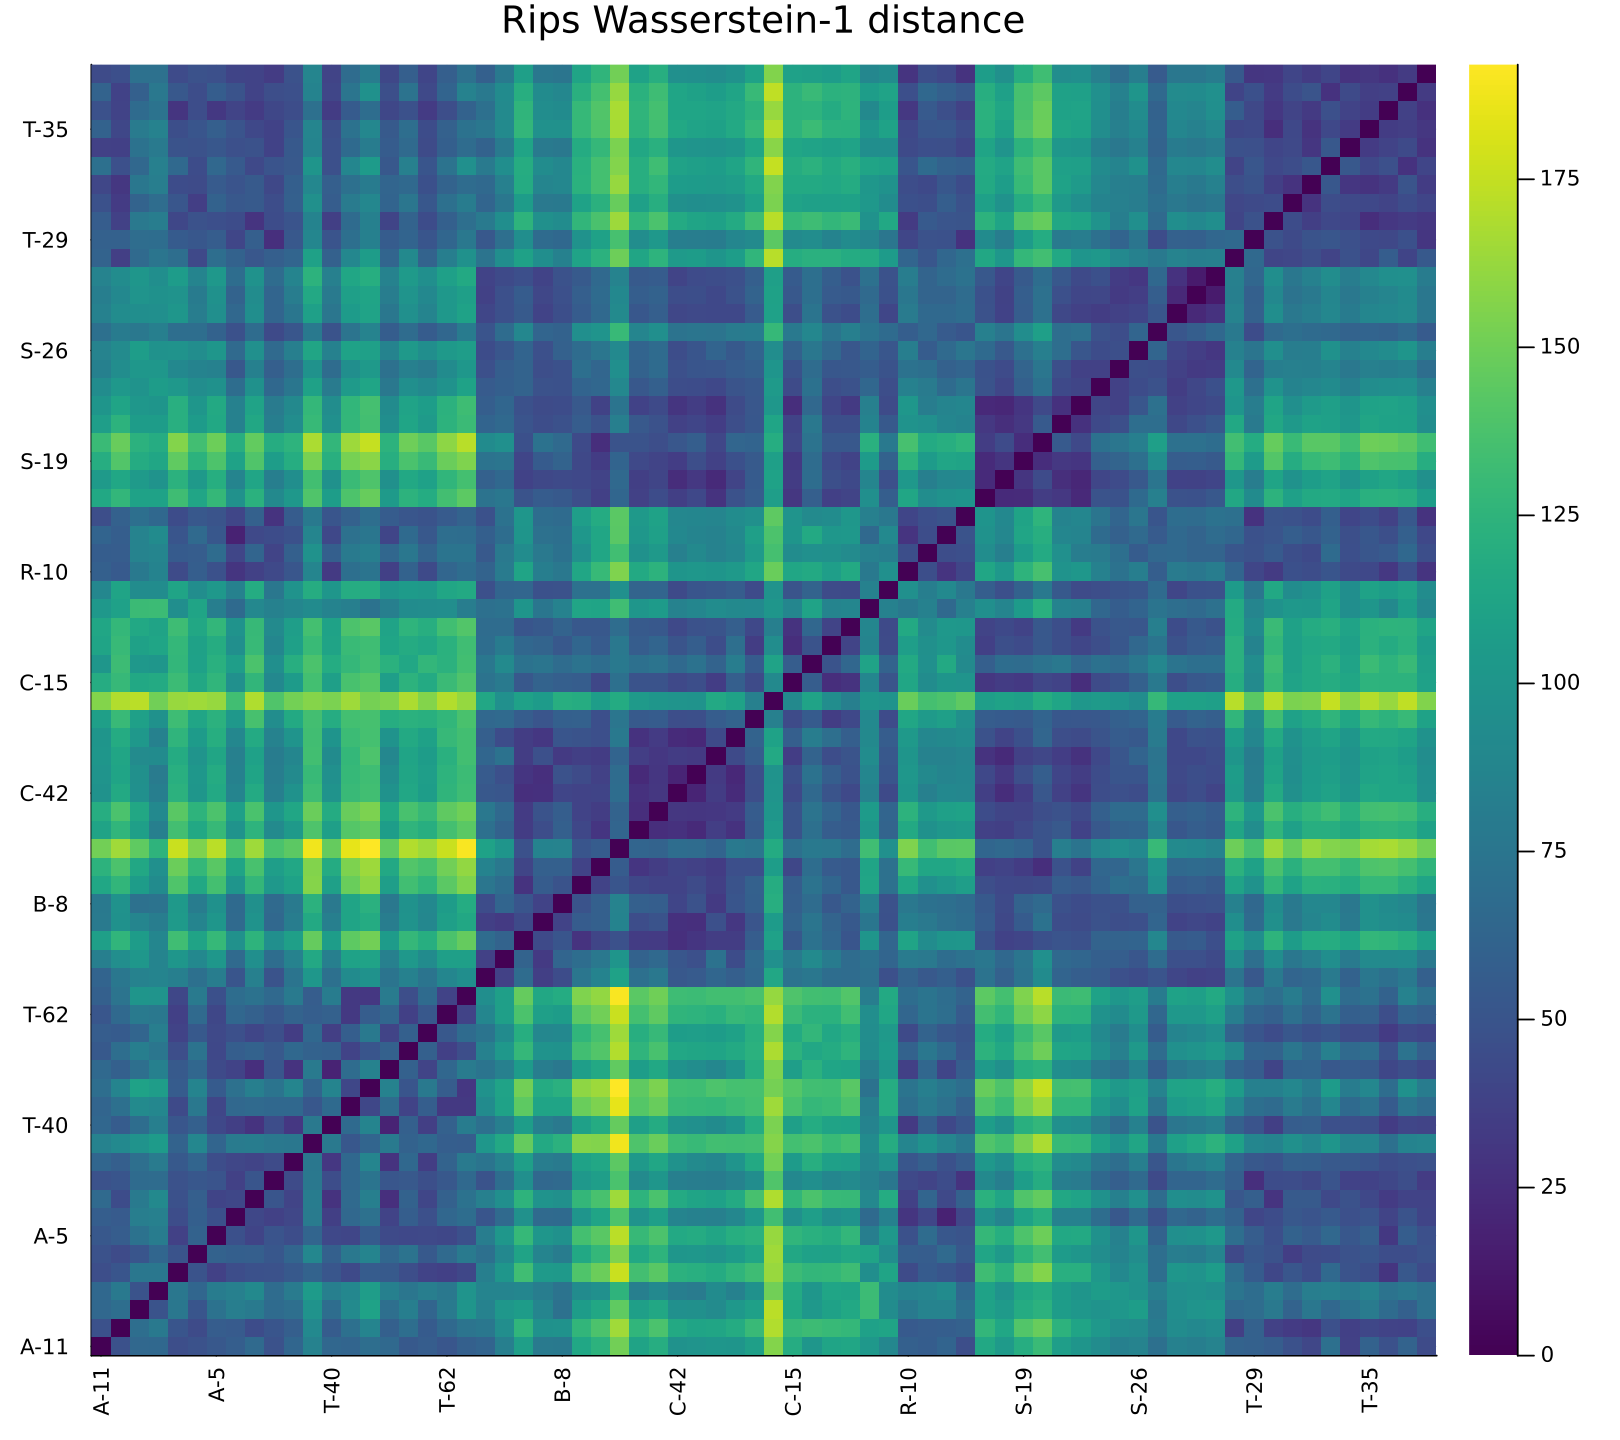

In [36]:
# Visualise one of the Wasserstein distance matrices
n_wass = size(D_wass1_rips, 1)
tick_step = max(1, ceil(Int, n_wass / 12))
tick_idx = collect(1:tick_step:n_wass)
tick_labels = length(individuals) == n_wass ? individuals[tick_idx] : string.(tick_idx)
finite_wass = D_wass1_rips[isfinite.(D_wass1_rips)]
zmin, zmax = extrema(finite_wass)
zmax = zmax <= zmin ? zmin + 1e-6 : zmax

p_wass = heatmap(
    D_wass1_rips,
    xticks = (tick_idx, tick_labels),
    yticks = (tick_idx, tick_labels),
    title = "Rips Wasserstein-1 distance",
    color = :viridis,
    clims = (zmin, zmax),
    xrotation = 90,
    size = (900, 800),
)
display(p_wass)

### 4.8 Summary of all classifiers

In [37]:
all_results = []

# Decision Tree
push!(all_results, (method = "Decision Tree (d=$(best_tree.max_depth))",
    n_correct = best_tree.n_correct, n_total = length(labels),
    accuracy = best_tree.accuracy, balanced_accuracy = best_tree.balanced_accuracy))

# LDA
push!(all_results, (method = "LDA",
    n_correct = sum(r_lda.predictions .== labels), n_total = length(labels),
    accuracy = r_lda.accuracy, balanced_accuracy = m_lda.balanced_accuracy))

# RF
push!(all_results, (method = "Balanced RF (T=$(best_rf_row.n_trees))",
    n_correct = sum(r_rf.predictions .== labels), n_total = length(labels),
    accuracy = r_rf.accuracy, balanced_accuracy = m_rf.balanced_accuracy))

# SVM (nested LOOCV honest estimate)
push!(all_results, (method = "SVM (Nested LOOCV)",
    n_correct = nested_svm_n_correct, n_total = length(labels),
    accuracy = nested_svm.accuracy, balanced_accuracy = nested_svm.balanced_accuracy))

# SVM + PCA (nested LOOCV)
push!(all_results, (method = "SVM + PCA (Nested LOOCV)",
    n_correct = nested_svm_pca_n_correct, n_total = length(labels),
    accuracy = nested_svm_pca.accuracy, balanced_accuracy = nested_svm_pca.balanced_accuracy))

# SVM with Rips-only stats (nested LOOCV)
push!(all_results, (method = "SVM Rips-only (Nested LOOCV)",
    n_correct = nested_svm_rips_n_correct, n_total = length(labels),
    accuracy = nested_svm_rips.accuracy, balanced_accuracy = nested_svm_rips.balanced_accuracy))

# k-NN on Wasserstein (best per distance)
for name in ["Wass-1", "Wass-2"]
    sub = filter(:method => m -> contains(m, name), knn_wass_df)
    best_knn = sub[1, :]  # already sorted by accuracy
    push!(all_results, (method = best_knn.method,
        n_correct = best_knn.n_correct, n_total = best_knn.n_total,
        accuracy = best_knn.accuracy, balanced_accuracy = best_knn.balanced_accuracy))
end

results_df = DataFrame(all_results)
sort!(results_df, :accuracy, rev = true)
results_df

## 5 Top-2 accuracy

A single-label classifier must pick exactly one family. Here we relax this to **top-2**: the model returns the two most probable families and the prediction is considered correct if the true family is among them. This is a useful diagnostic for borderline cases where two families look very similar.

We re-run LOOCV for the best balanced RF, collecting class probabilities via `apply_forest_proba`.

In [38]:
using DecisionTree: build_forest, apply_forest, apply_forest_proba
using Random: shuffle!

function loocv_rf_top2(X::Matrix, labels::Vector{String};
                       n_trees::Int = 500,
                       max_depth::Int = -1,
                       min_samples_leaf::Int = 1,
                       top_k::Int = 2,
                       rng_seed::Int = 20260223)
    # Inline balanced bootstrap (mirrors TDAfly.Analysis._balanced_bootstrap_indices)
    function _bal_boot(y; rng)
        classes  = sort(unique(y))
        target_n = maximum(count(==(c), y) for c in classes)
        idx = Int[]
        for cls in classes
            cls_idx = findall(==(cls), y)
            append!(idx, rand(rng, cls_idx, target_n))
        end
        shuffle!(rng, idx)
        idx
    end

    Xclean = sanitize_feature_matrix(X)
    n = size(Xclean, 1)
    top1_preds   = Vector{String}(undef, n)
    topk_correct = falses(n)

    for i in 1:n
        train_idx     = setdiff(1:n, i)
        X_train       = Xclean[train_idx, :]
        y_train       = labels[train_idx]
        train_classes = sort(unique(y_train))

        rng     = MersenneTwister(rng_seed + i)
        bal_idx = _bal_boot(y_train; rng = rng)
        X_bal   = X_train[bal_idx, :]
        y_bal   = y_train[bal_idx]

        n_features = max(1, round(Int, sqrt(size(X_bal, 2))))
        model = build_forest(y_bal, X_bal, n_features, n_trees, 0.7,
                              max_depth, min_samples_leaf; rng = rng)

        top1_preds[i] = apply_forest(model, Xclean[i, :])

        # Probability vector (one entry per train_classes)
        proba        = apply_forest_proba(model, Xclean[i, :], train_classes)
        topk_idx     = sortperm(proba, rev = true)[1:min(top_k, length(train_classes))]
        topk_classes = train_classes[topk_idx]
        topk_correct[i] = labels[i] in topk_classes
    end

    top1_acc = mean(top1_preds .== labels)
    topk_acc = mean(topk_correct)
    (; top1_accuracy = top1_acc, topk_accuracy = topk_acc,
       top1_predictions = top1_preds, topk_correct = topk_correct)
end

r_top2 = loocv_rf_top2(X_features, labels;
                        n_trees          = best_rf_row.n_trees,
                        max_depth        = best_rf_row.max_depth,
                        min_samples_leaf = best_rf_row.min_leaf)

n1 = sum(r_top2.top1_predictions .== labels)
n2 = sum(r_top2.topk_correct)
println("Top-1 accuracy : $(n1)/$(length(labels)) ($(round(r_top2.top1_accuracy*100, digits=1))%)")
println("Top-2 accuracy : $(n2)/$(length(labels)) ($(round(r_top2.topk_accuracy*100, digits=1))%)")
println("Gain from top-2: +$(n2 - n1) correctly recovered")

Top-1 accuracy : 55/70 (78.6%)
Top-2 accuracy : 62/70 (88.6%)
Gain from top-2: +7 correctly recovered

In [39]:
# Per-family breakdown: top-1 vs top-2
top2_family_df = DataFrame(
    family        = String[],
    n_total       = Int[],
    top1_correct  = Int[],
    top2_correct  = Int[],
    top1_acc_pct  = Float64[],
    top2_acc_pct  = Float64[],
)

for f in sort(unique(labels))
    idx   = findall(==(f), labels)
    n_f   = length(idx)
    c1    = count(i -> r_top2.top1_predictions[i] == labels[i], idx)
    c2    = count(i -> r_top2.topk_correct[i], idx)
    push!(top2_family_df, (f, n_f, c1, c2,
          round(c1 / n_f * 100, digits=1),
          round(c2 / n_f * 100, digits=1)))
end

sort!(top2_family_df, :top1_acc_pct)
top2_family_df


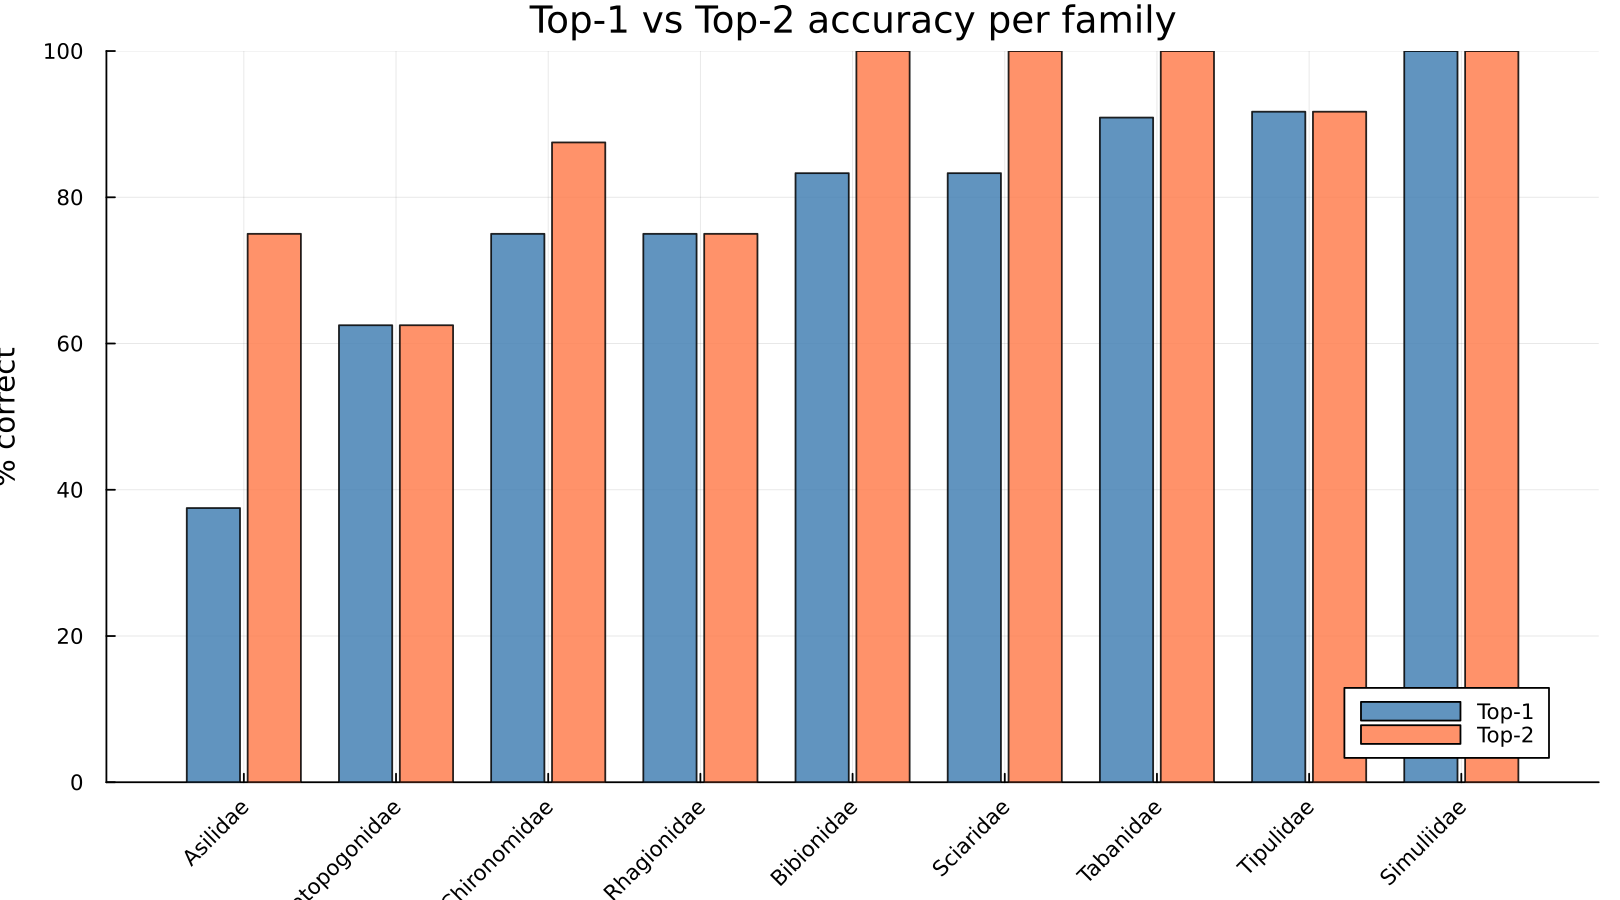

In [40]:
# Bar chart comparing top-1 vs top-2 per family
families_sorted = top2_family_df.family
x = 1:length(families_sorted)
bar(x .- 0.2, top2_family_df.top1_acc_pct, bar_width = 0.35,
    label = "Top-1", color = :steelblue, alpha = 0.85)
bar!(x .+ 0.2, top2_family_df.top2_acc_pct, bar_width = 0.35,
     label = "Top-2", color = :coral, alpha = 0.85,
     xticks = (x, families_sorted), xrotation = 45,
     ylabel = "% correct", title = "Top-1 vs Top-2 accuracy per family",
     legend = :bottomright, size = (900, 500))

## 6 Which features drive the classification?

In [41]:
# ── Feature importance from full-data RF ────────────────────────────────────
# Build individual trees with impurity_importance tracking enabled,
# then aggregate importances across the forest.
rng_imp = MersenneTwister(20260223)
n_feat_imp = max(1, round(Int, sqrt(size(X_features, 2))))
n_trees_imp = 1000

tree_importances = zeros(size(X_features, 2))
for t in 1:n_trees_imp
    # Bootstrap sample (with replacement)
    n = size(X_features, 1)
    idx = rand(rng_imp, 1:n, n)
    X_boot = X_features[idx, :]
    y_boot = labels[idx]

    tree = DecisionTree.build_tree(
        y_boot, X_boot, n_feat_imp, -1, 1, 2, 0.0;
        loss = DecisionTree.util.gini,
        rng = rng_imp,
        impurity_importance = true
    )
    tree_importances .+= DecisionTree.impurity_importance(tree; normalize = false)
end

# Normalize
rf_imp = tree_importances ./ maximum(tree_importances)

imp_df = DataFrame(
    feature = feature_names,
    importance = rf_imp
)
sort!(imp_df, :importance, rev = true)
top_imp = first(filter(:importance => >(0.0), imp_df), 20)
top_imp


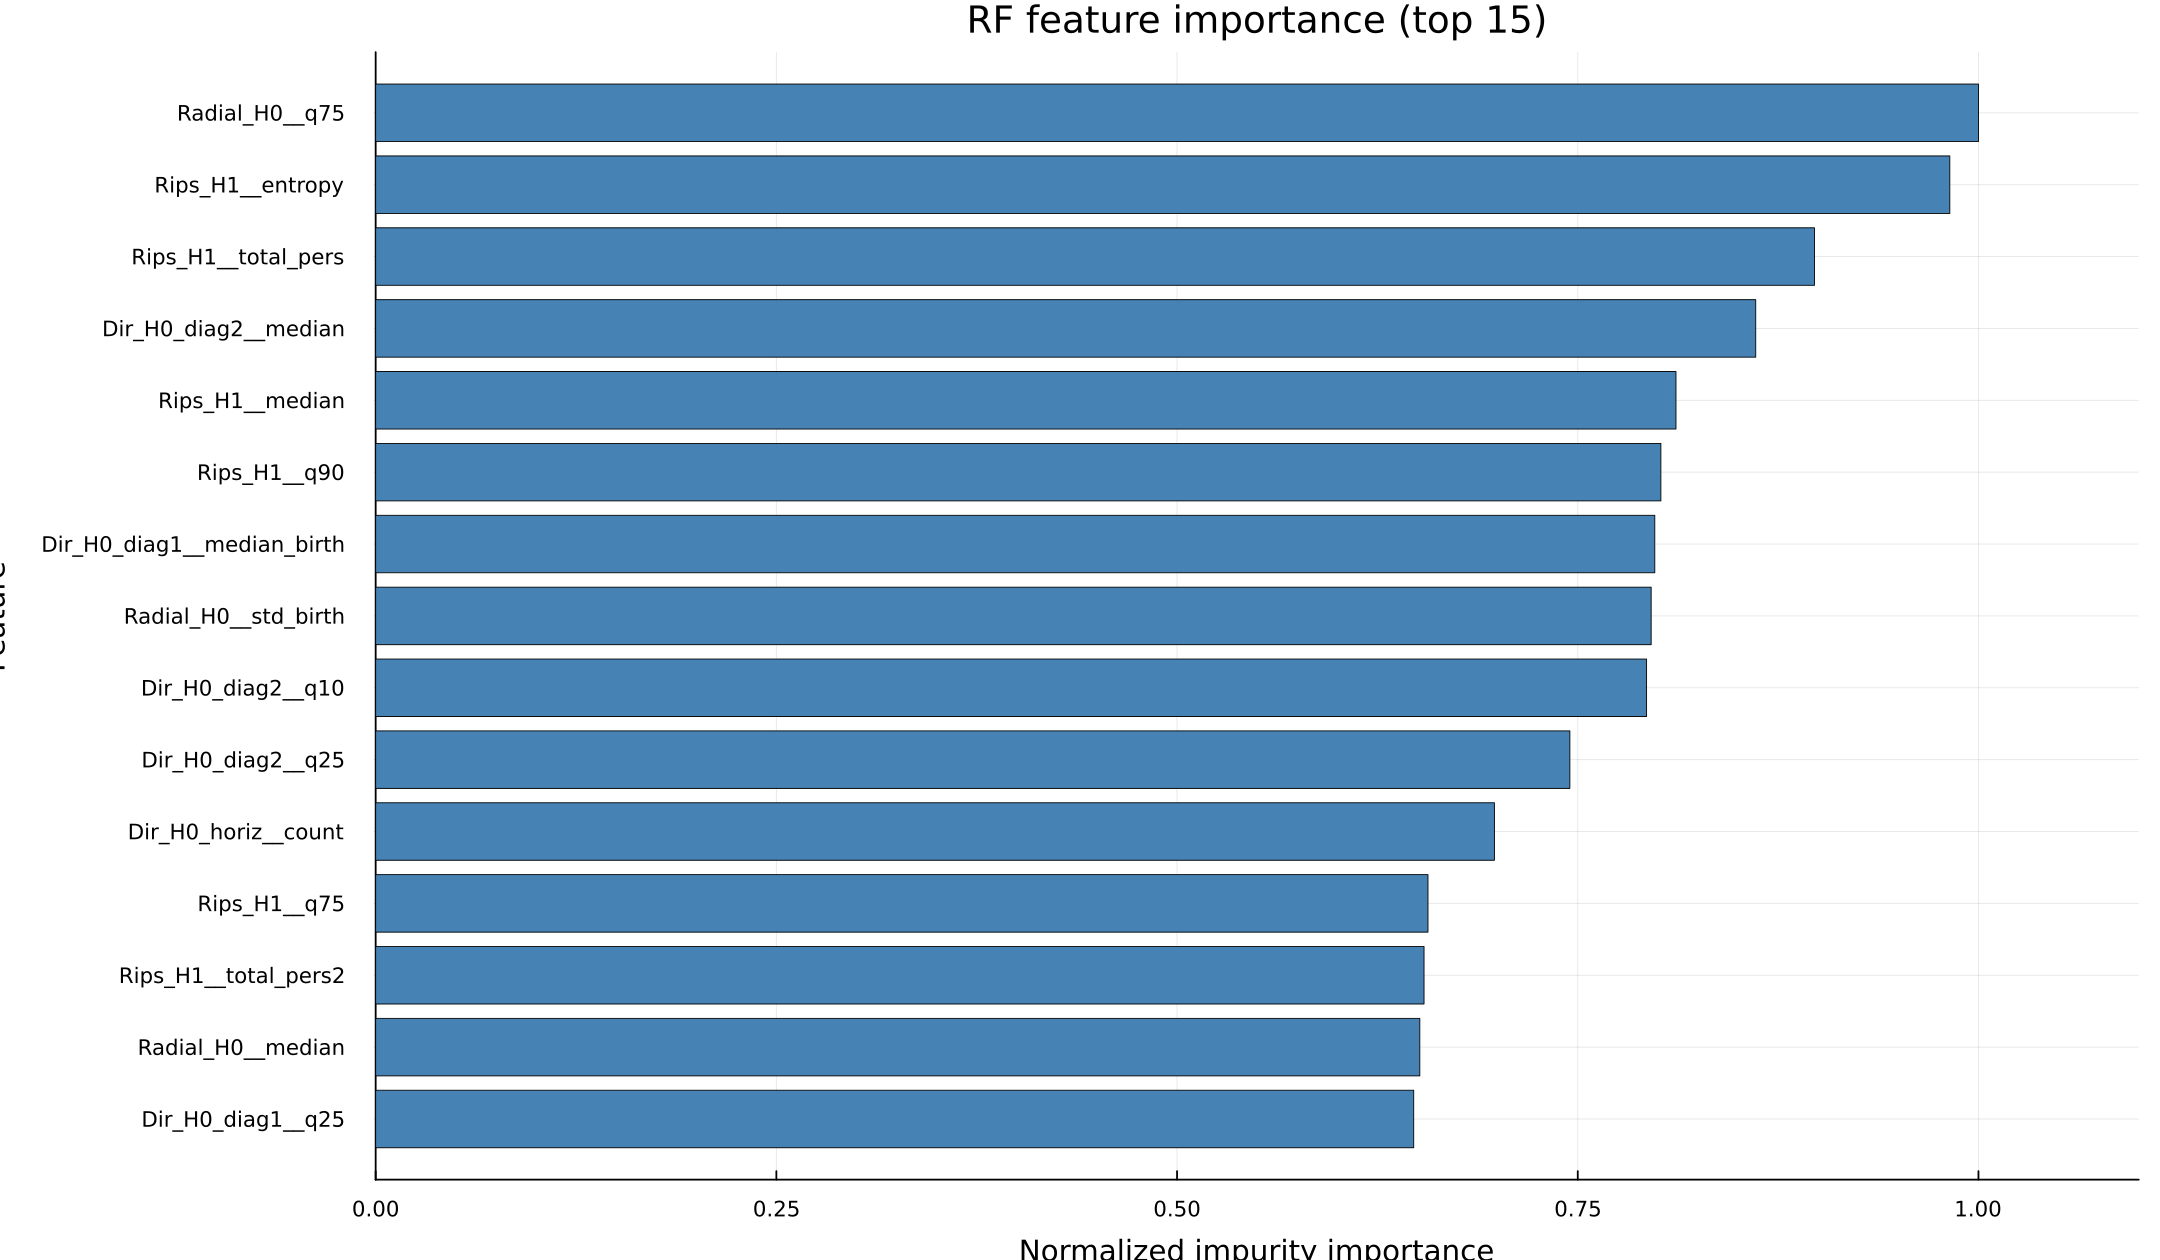


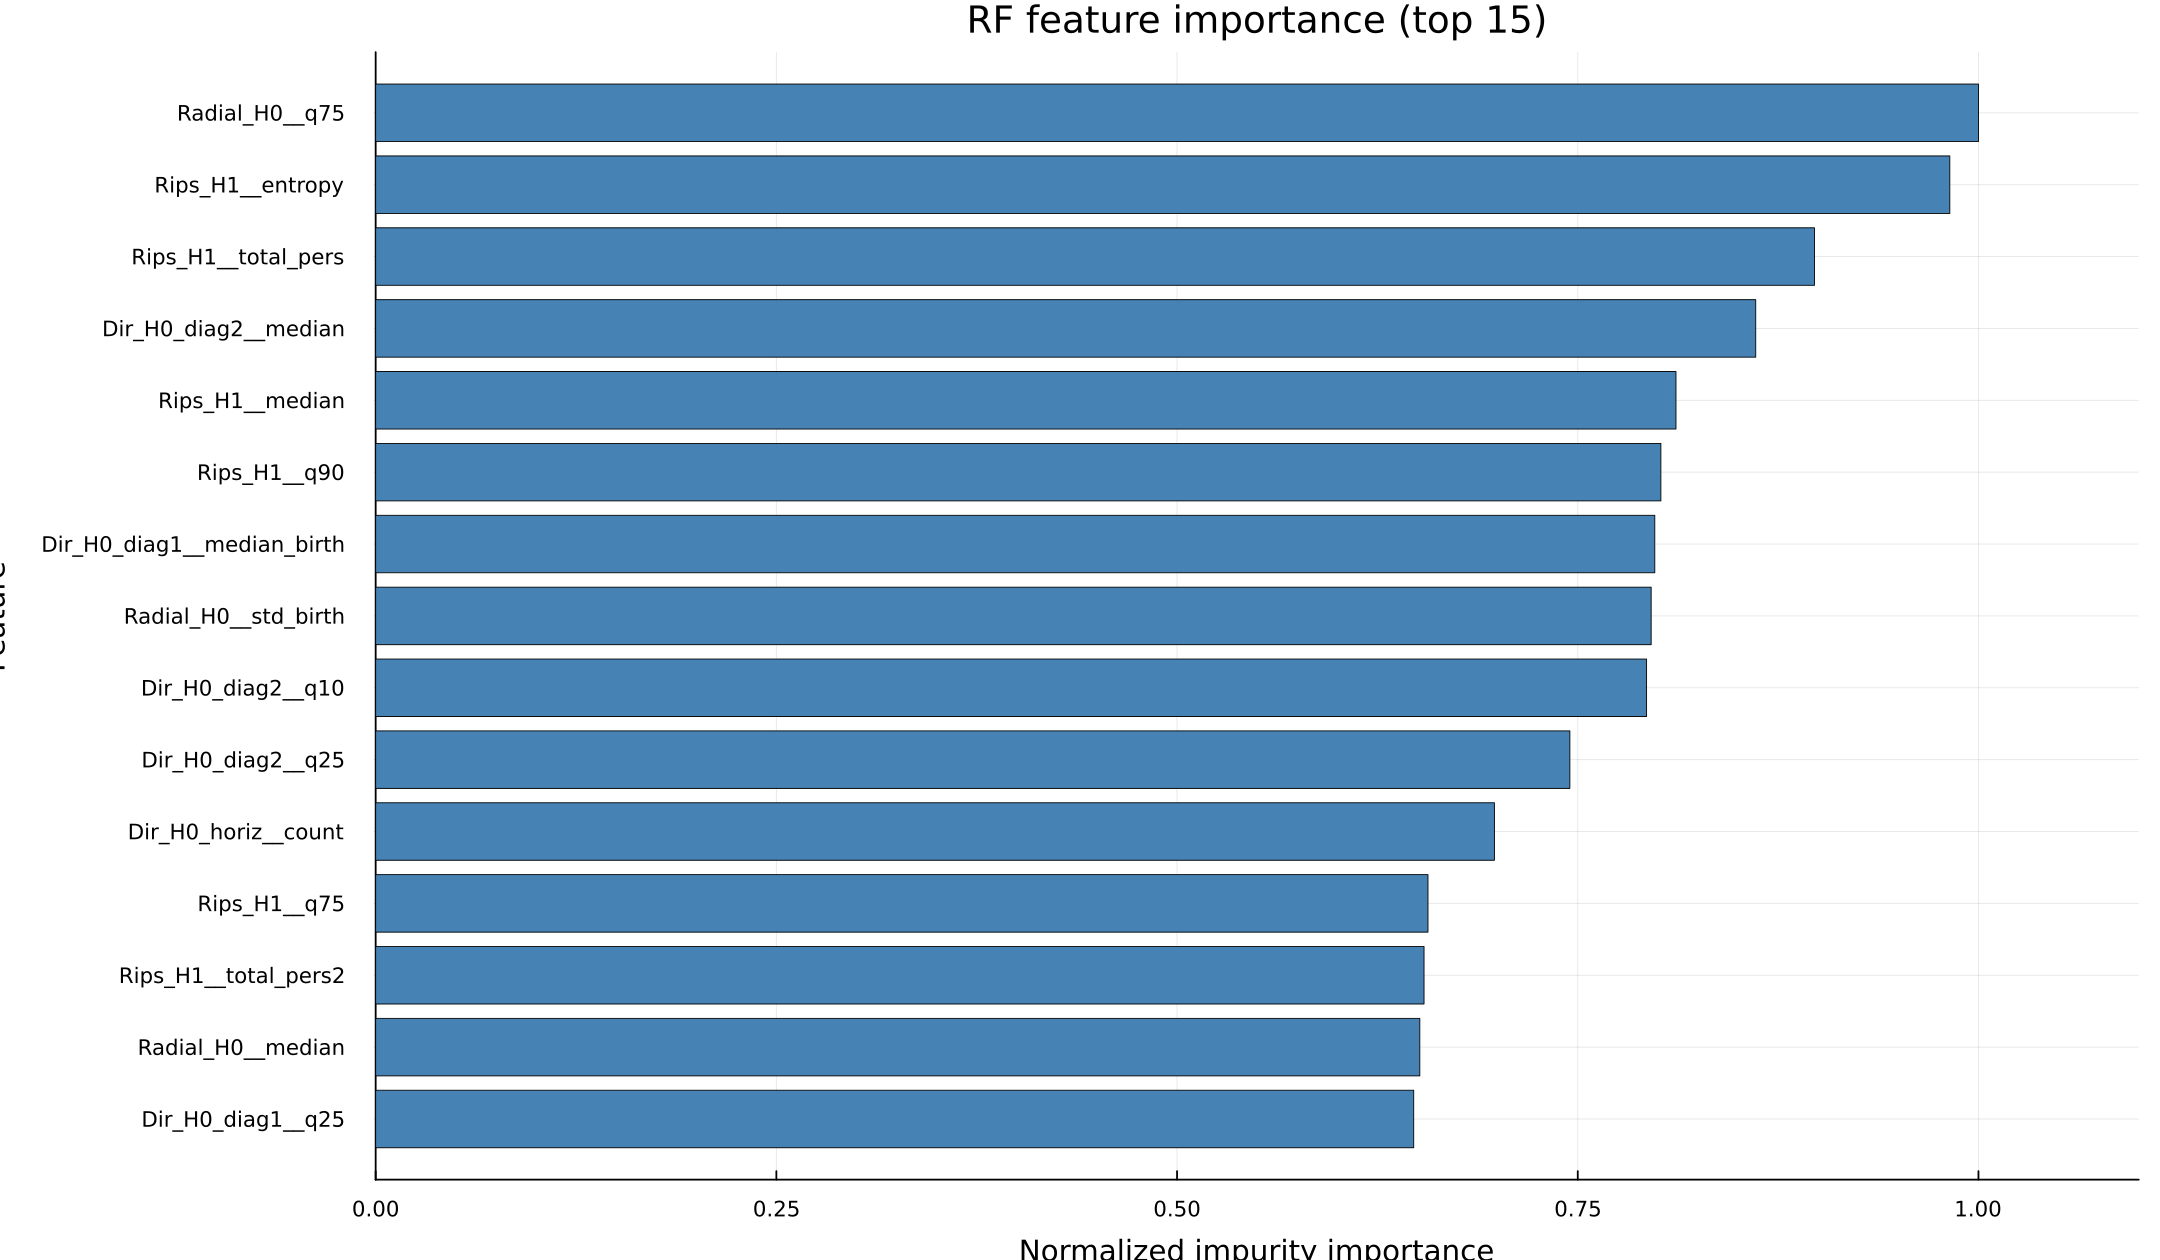

In [42]:
topk_imp = min(15, nrow(top_imp))

if topk_imp == 0
    println("No nonzero RF importances to plot.")
    p_rf_imp = plot(title = "RF feature importance (no nonzero features)", legend = false)
else
    rf_ord = sortperm(top_imp.importance[1:topk_imp])
    rf_feat_plot = top_imp.feature[1:topk_imp][rf_ord]
    rf_imp_plot = top_imp.importance[1:topk_imp][rf_ord]
    rf_xmax = 1.1 * max(1e-6, maximum(rf_imp_plot))

    p_rf_imp = bar(
        1:topk_imp,
        rf_imp_plot,
        orientation = :horizontal,
        yticks = (1:topk_imp, rf_feat_plot),
        xlabel = "Normalized impurity importance",
        ylabel = "Feature",
        title = "RF feature importance (top $(topk_imp))",
        legend = false,
        fillcolor = :steelblue,
        linecolor = :black,
        linewidth = 0.5,
        xlims = (0.0, rf_xmax),
        size = (1200, 700),
    )
end

display(p_rf_imp)
p_rf_imp

## 7 Feature ablation

In [43]:
# ── Test each filtration alone and combined ─────────────────────────────────
stats_dir_all = hcat([stats_dir_h0[n] for n in direction_names]...)

ablation_sets = [
    ("Rips H1 only",                  hcat(stats_rips)),
    ("Radial H0 only",                hcat(stats_radial_h0)),
    ("Dir H0 only (4 dirs)",          stats_dir_all),
    ("Rips + Radial H0",              hcat(stats_rips, stats_radial_h0)),
    ("Rips + Dir H0",                 hcat(stats_rips, stats_dir_all)),
    ("Radial H0 + Dir H0",            hcat(stats_radial_h0, stats_dir_all)),
    ("All (Rips + Radial H0 + Dir H0)", X_features),
]

ablation_results = []
for (name, X_abl) in ablation_sets
    X_abl_clean = sanitize_feature_matrix(X_abl)

    r_lda_abl = loocv_lda(X_abl_clean, labels)
    r_rf_abl = loocv_random_forest_balanced(X_abl_clean, labels; n_trees=500, rng_seed=20260223)

    push!(ablation_results, (
        filtrations = name,
        n_features = size(X_abl_clean, 2),
        lda_correct = sum(r_lda_abl.predictions .== labels),
        lda_accuracy = round(r_lda_abl.accuracy * 100, digits=1),
        rf_correct = sum(r_rf_abl.predictions .== labels),
        rf_accuracy = round(r_rf_abl.accuracy * 100, digits=1),
    ))
end

ablation_df = DataFrame(ablation_results)
sort!(ablation_df, :lda_accuracy, rev = true)
ablation_df

## 8 Honest evaluation (Nested LOOCV)

> **Nested cross-validation**
>
> Standard LOOCV can give optimistically biased estimates when hyperparameters are tuned on the same data. **Nested LOOCV** adds an inner cross-validation loop: for each held-out test sample, the best hyperparameters are selected using only the training fold. This provides an unbiased estimate of generalization performance.

In [44]:
nested_rf = nested_loocv_random_forest(
    X_features, labels;
    n_trees_grid = [200, 500],
    max_depth_grid = [-1],
    min_samples_leaf_grid = [1, 2],
    inner_folds = 4,
    balanced = true,
    rng_seed = 20260223
)
n_correct_nested = sum(nested_rf.predictions .== labels)

println("=== Nested LOOCV: Balanced RF ===")
println("Features: $(size(X_features, 2)) (Rips + Radial stats)")
println("Accuracy: $(n_correct_nested)/$(length(labels)) ($(round(nested_rf.accuracy * 100, digits=1))%)")
println("Balanced accuracy: $(round(nested_rf.balanced_accuracy * 100, digits=1))%")
println("Macro-F1: $(round(nested_rf.macro_f1 * 100, digits=1))%")

ci_nested = wilson_ci(n_correct_nested, length(labels))
println("95% Wilson CI: [$(round(ci_nested.lower * 100, digits=1))%, $(round(ci_nested.upper * 100, digits=1))%]")

=== Nested LOOCV: Balanced RF ===
Features: 102 (Rips + Radial stats)
Accuracy: 53/70 (75.7%)
Balanced accuracy: 74.4%
Macro-F1: 74.0%
95% Wilson CI: [64.5%, 84.2%]

### 8.1 Confusion matrix

In [45]:
cm_nested = confusion_matrix(labels, nested_rf.predictions)
classes_nested = cm_nested.classes


println("Per-class accuracy (Nested LOOCV):")
for (i, cls) in enumerate(classes_nested)
    correct = cm_nested.matrix[i, i]
    total = sum(cm_nested.matrix[i, :])
    println("  $(cls): $(correct)/$(total) ($(round(correct / total * 100, digits=1))%)")
end

Per-class accuracy (Nested LOOCV):
  Asilidae: 2/8 (25.0%)
  Bibionidae: 5/6 (83.3%)
  Ceratopogonidae: 7/8 (87.5%)
  Chironomidae: 4/8 (50.0%)
  Rhagionidae: 2/4 (50.0%)
  Sciaridae: 6/6 (100.0%)
  Simuliidae: 7/7 (100.0%)
  Tabanidae: 9/11 (81.8%)
  Tipulidae: 11/12 (91.7%)


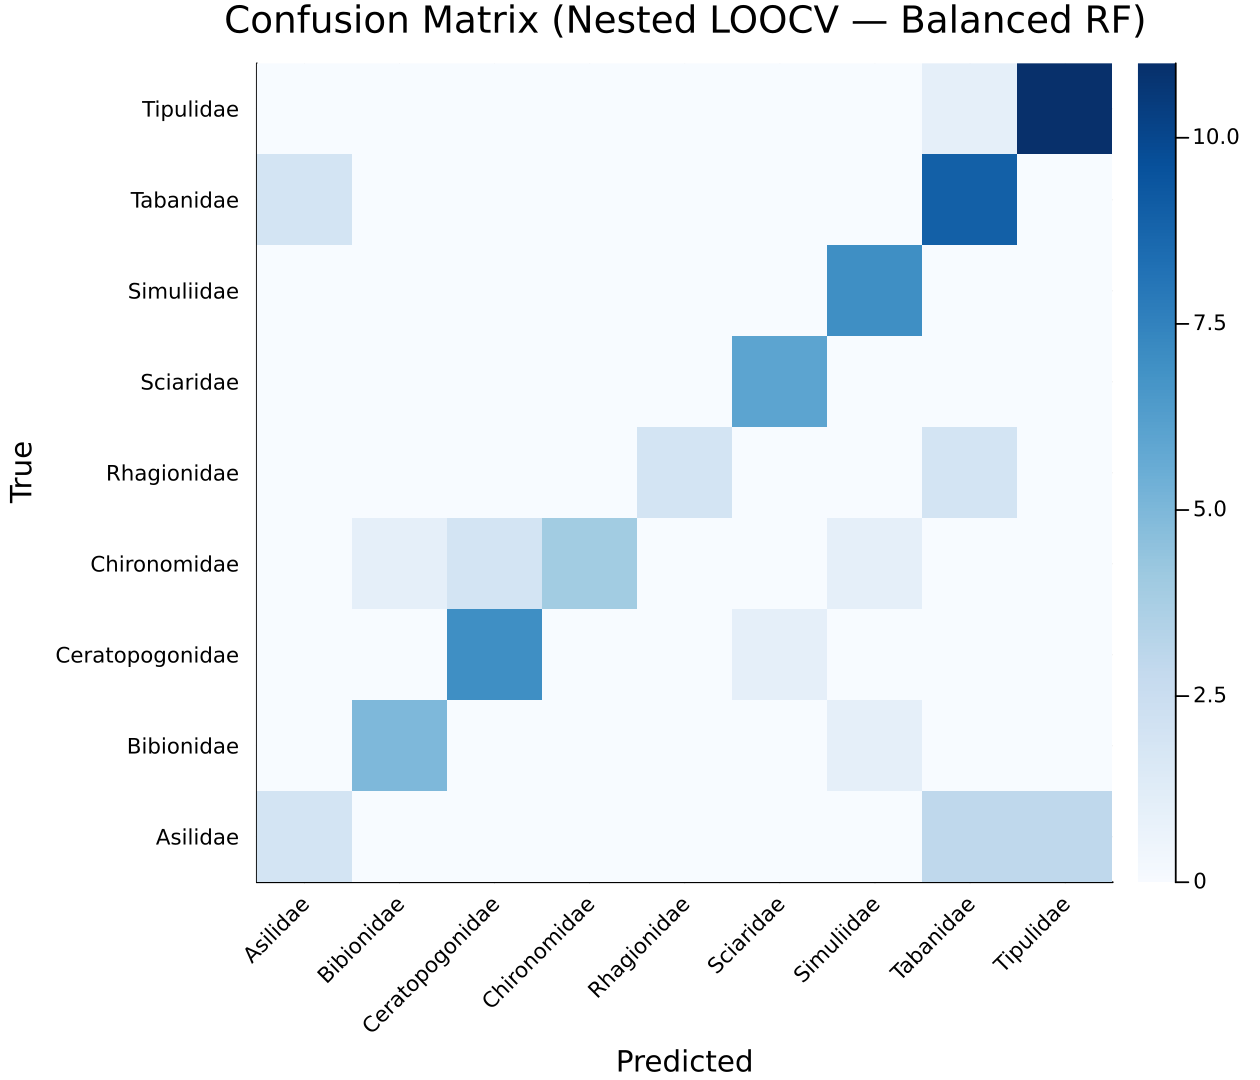

In [46]:
heatmap(cm_nested.matrix,
        xticks = (1:length(classes_nested), classes_nested),
        yticks = (1:length(classes_nested), classes_nested),
        xlabel = "Predicted", ylabel = "True",
        title = "Confusion Matrix (Nested LOOCV — Balanced RF)",
        color = :Blues,
        clims = (0, maximum(cm_nested.matrix)),
        xrotation = 45, size = (700, 600))

### 8.2 Misclassified wings: visual inspection

For each misclassified specimen we show the wing image and radial filtration alongside the 4 nearest neighbours (by Euclidean distance in the z-scored feature space). This helps understand whether errors are due to genuine visual ambiguity or artefacts of segmentation.

In [47]:
# z-score the feature matrix so all features have equal weight
X_z = zscore_normalize(X_features)

# Pairwise Euclidean distances between all specimens
n_all = size(X_z, 1)
D_feat = zeros(n_all, n_all)
for i in 1:n_all, j in i+1:n_all
    d = sqrt(sum((X_z[i, :] .- X_z[j, :]).^2))
    D_feat[i, j] = D_feat[j, i] = d
end

misclassified_idx = findall(nested_rf.predictions .!= labels)
println("Misclassified samples ($(length(misclassified_idx)) / $(length(labels))):")
for i in misclassified_idx
    println("  [$(i)] $(individuals[i])  true=$(labels[i])  predicted=$(nested_rf.predictions[i])")
end

Misclassified samples (17 / 70):
  [1] A-11  true=Asilidae  predicted=Tabanidae
  [2] A-13  true=Asilidae  predicted=Tabanidae
  [3] A-17  true=Asilidae  predicted=Tipulidae
  [4] A-19  true=Asilidae  predicted=Tipulidae
  [6] A-3  true=Asilidae  predicted=Tabanidae
  [7] A-5  true=Asilidae  predicted=Tipulidae
  [9] T-19  true=Tipulidae  predicted=Tabanidae
  [26] B-9  true=Bibionidae  predicted=Simuliidae
  [34] C-45  true=Ceratopogonidae  predicted=Sciaridae
  [36] C-14  true=Chironomidae  predicted=Simuliidae
  [37] C-15  true=Chironomidae  predicted=Ceratopogonidae
  [40] C-18  true=Chironomidae  predicted=Ceratopogonidae
  [41] C-19  true=Chironomidae  predicted=Bibionidae
  [44] R-11  true=Rhagionidae  predicted=Tabanidae
  [46] R-9  true=Rhagionidae  predicted=Tabanidae
  [65] T-33  true=Tabanidae  predicted=Asilidae
  [69] T-37  true=Tabanidae  predicted=Asilidae


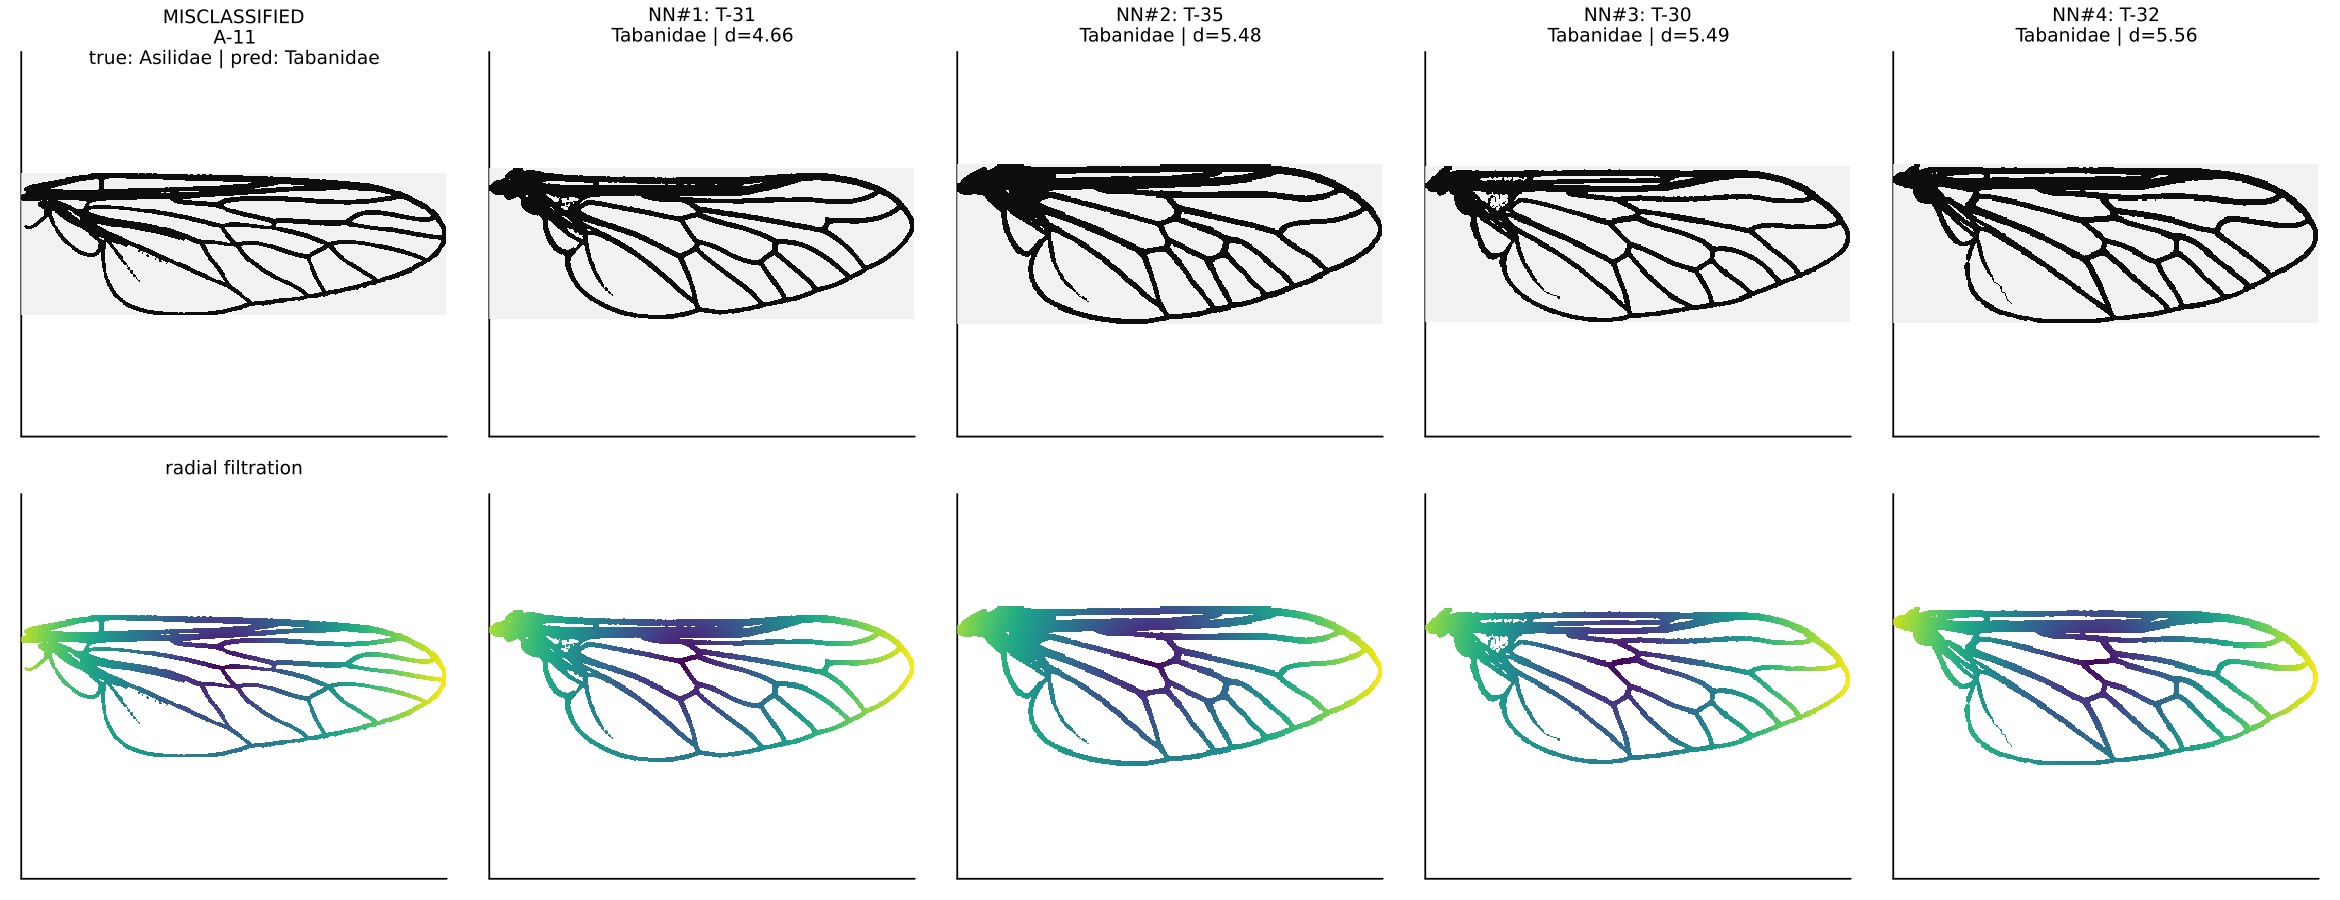


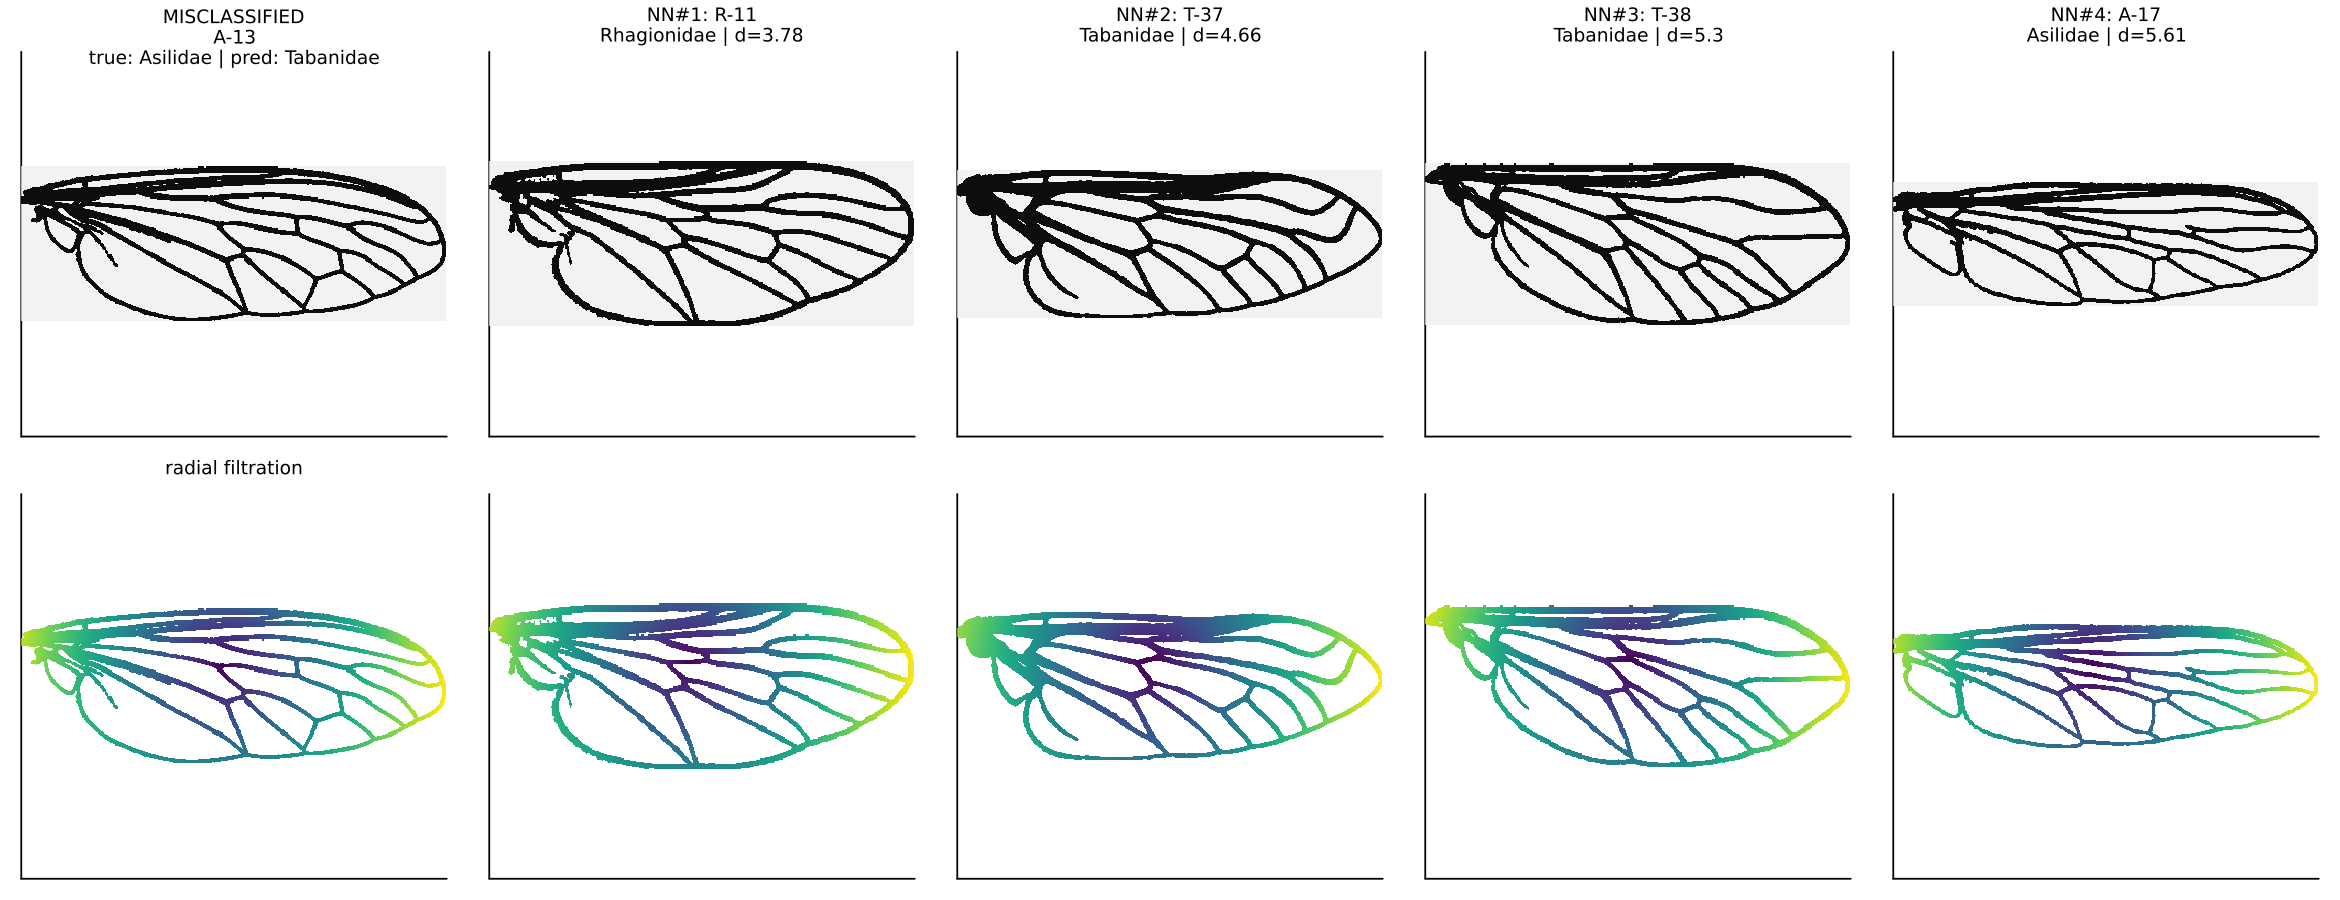


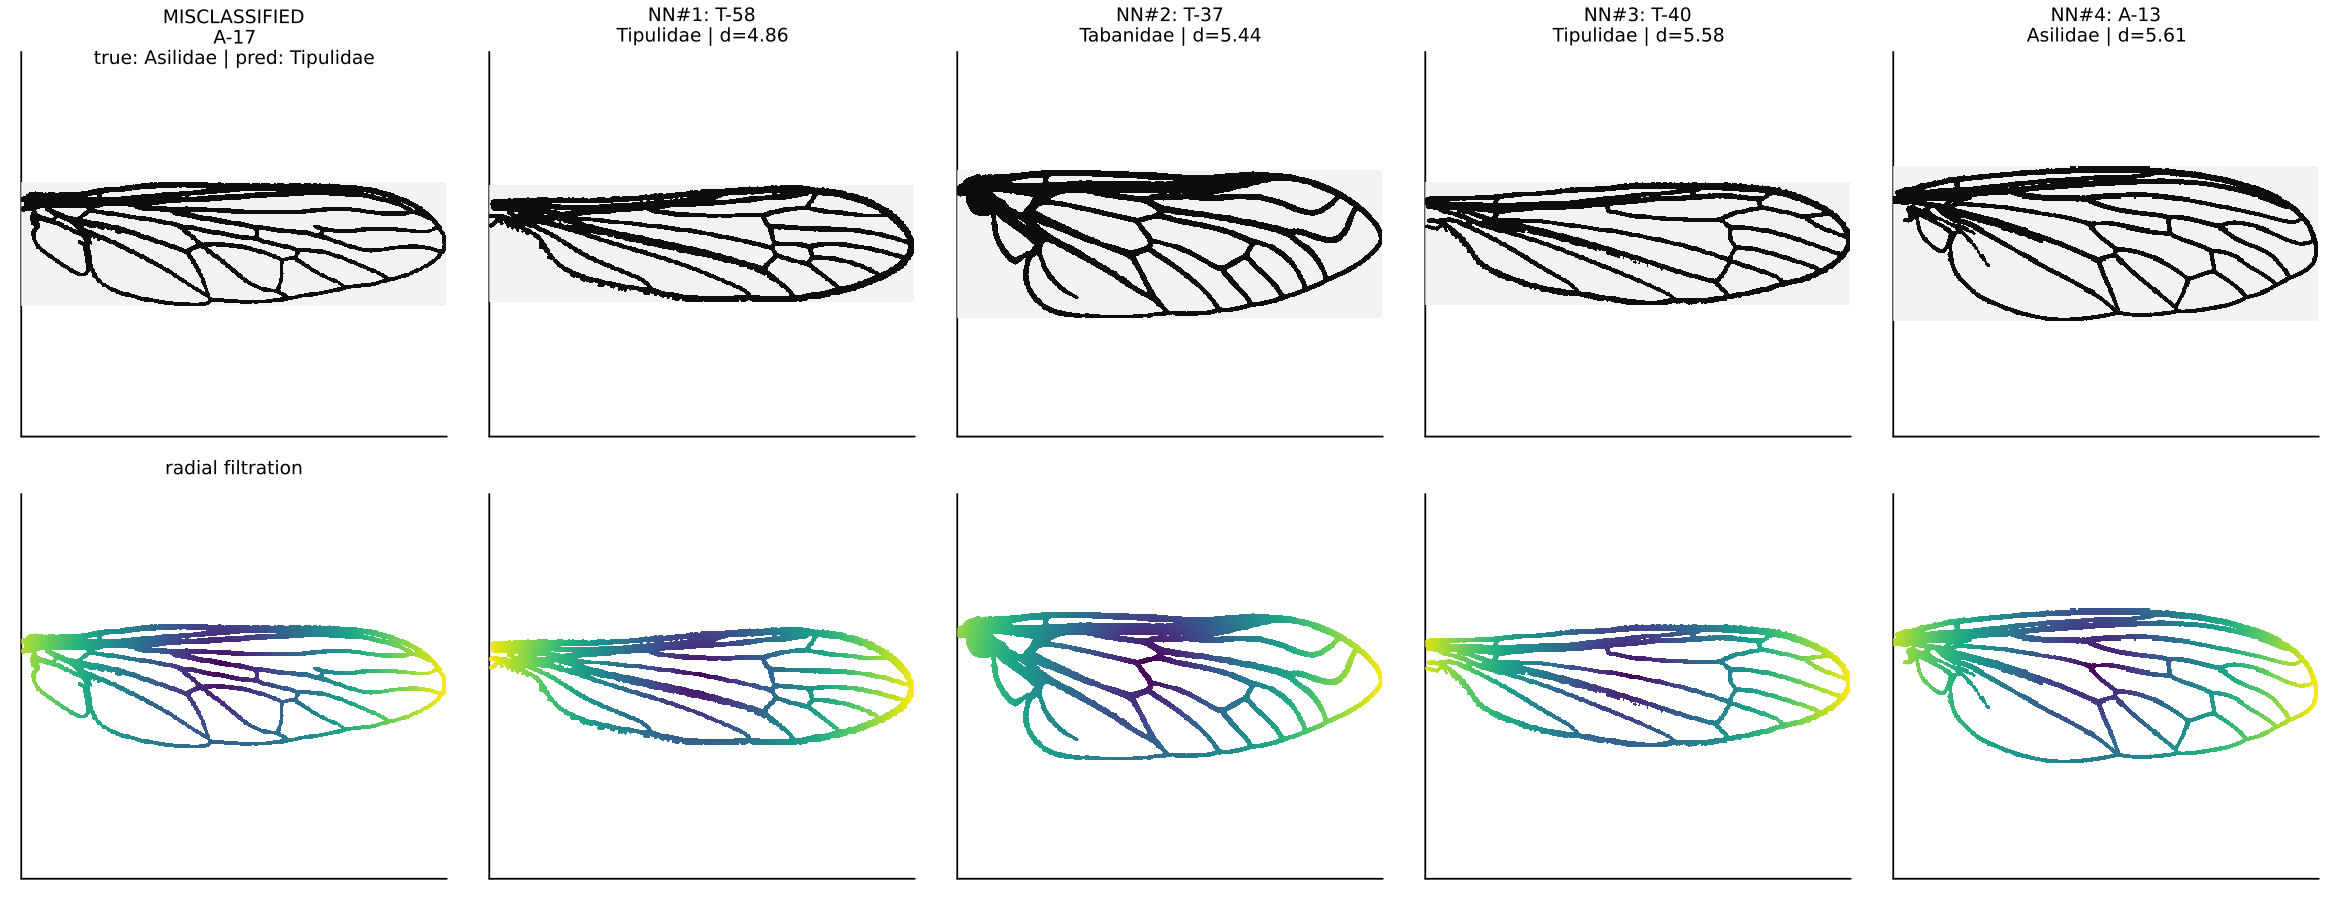


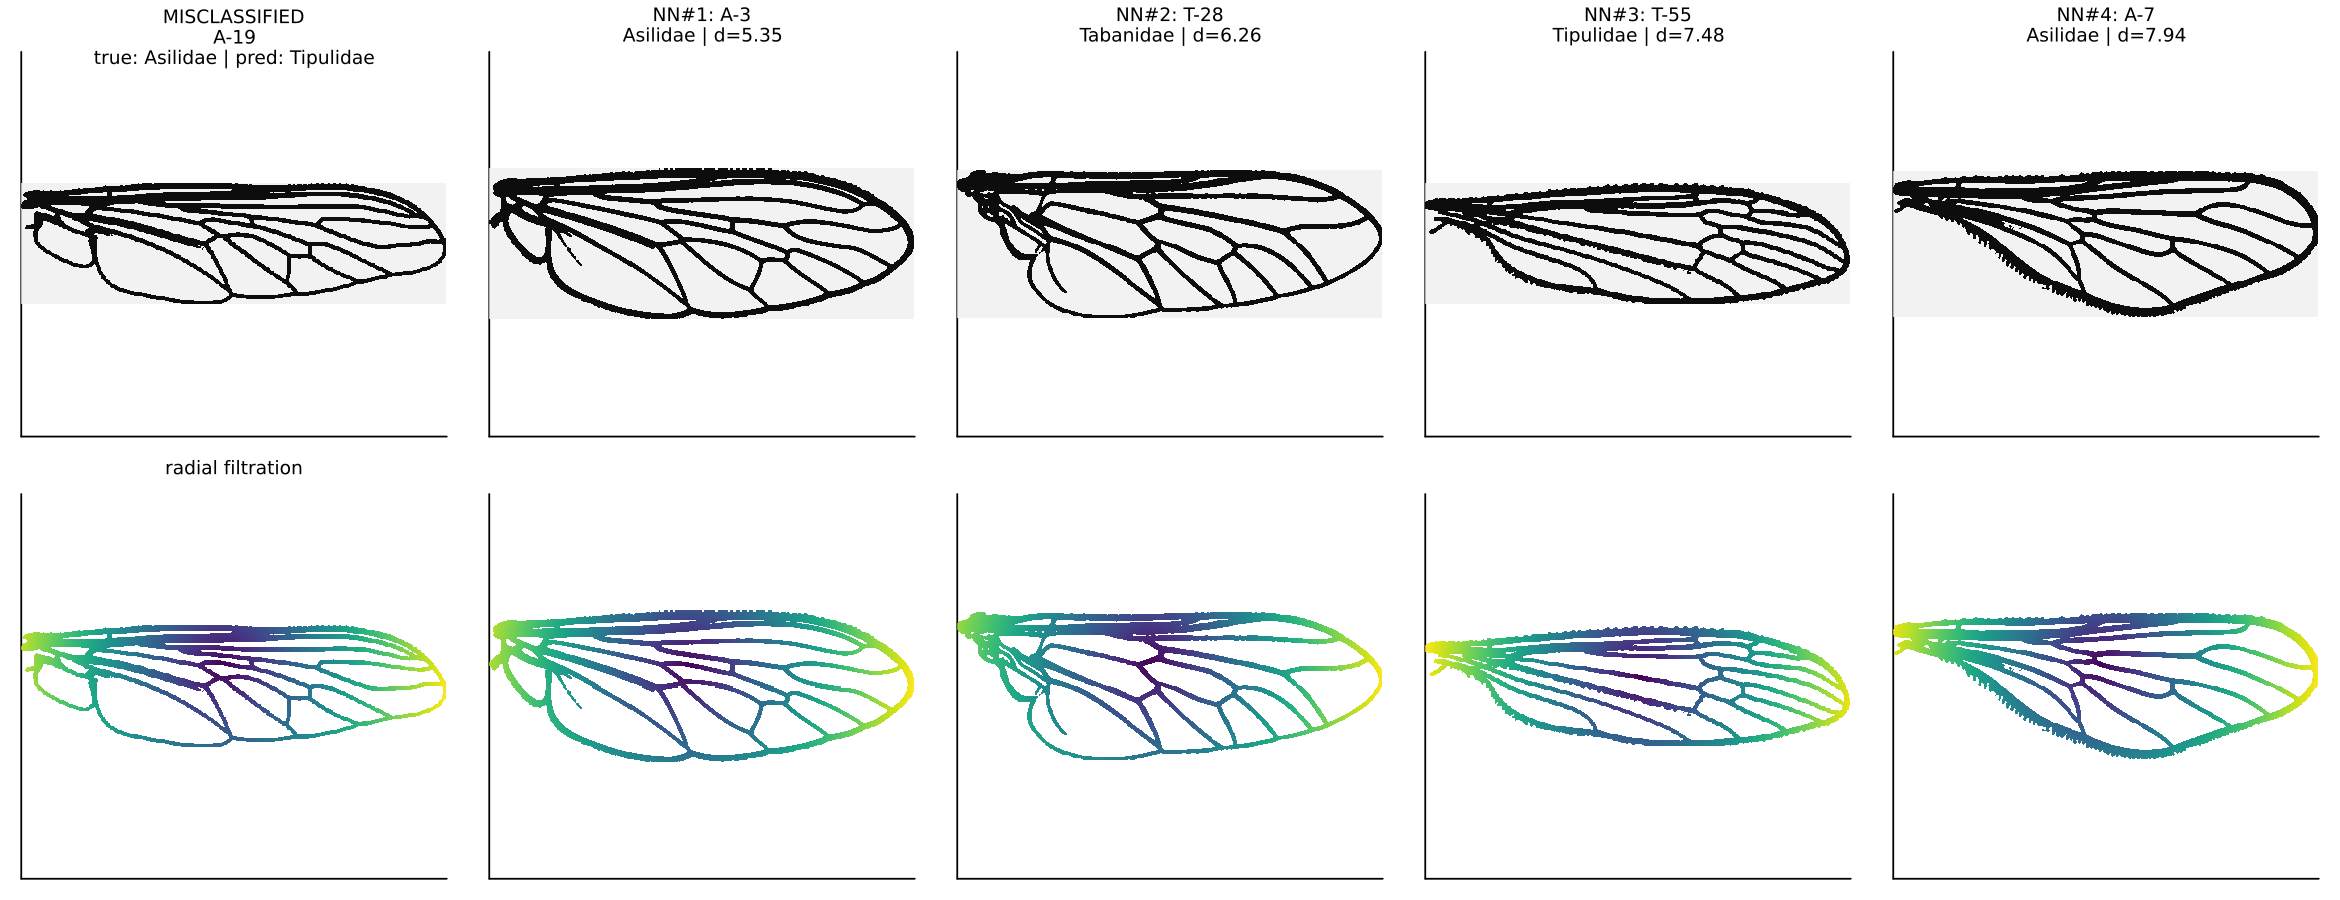


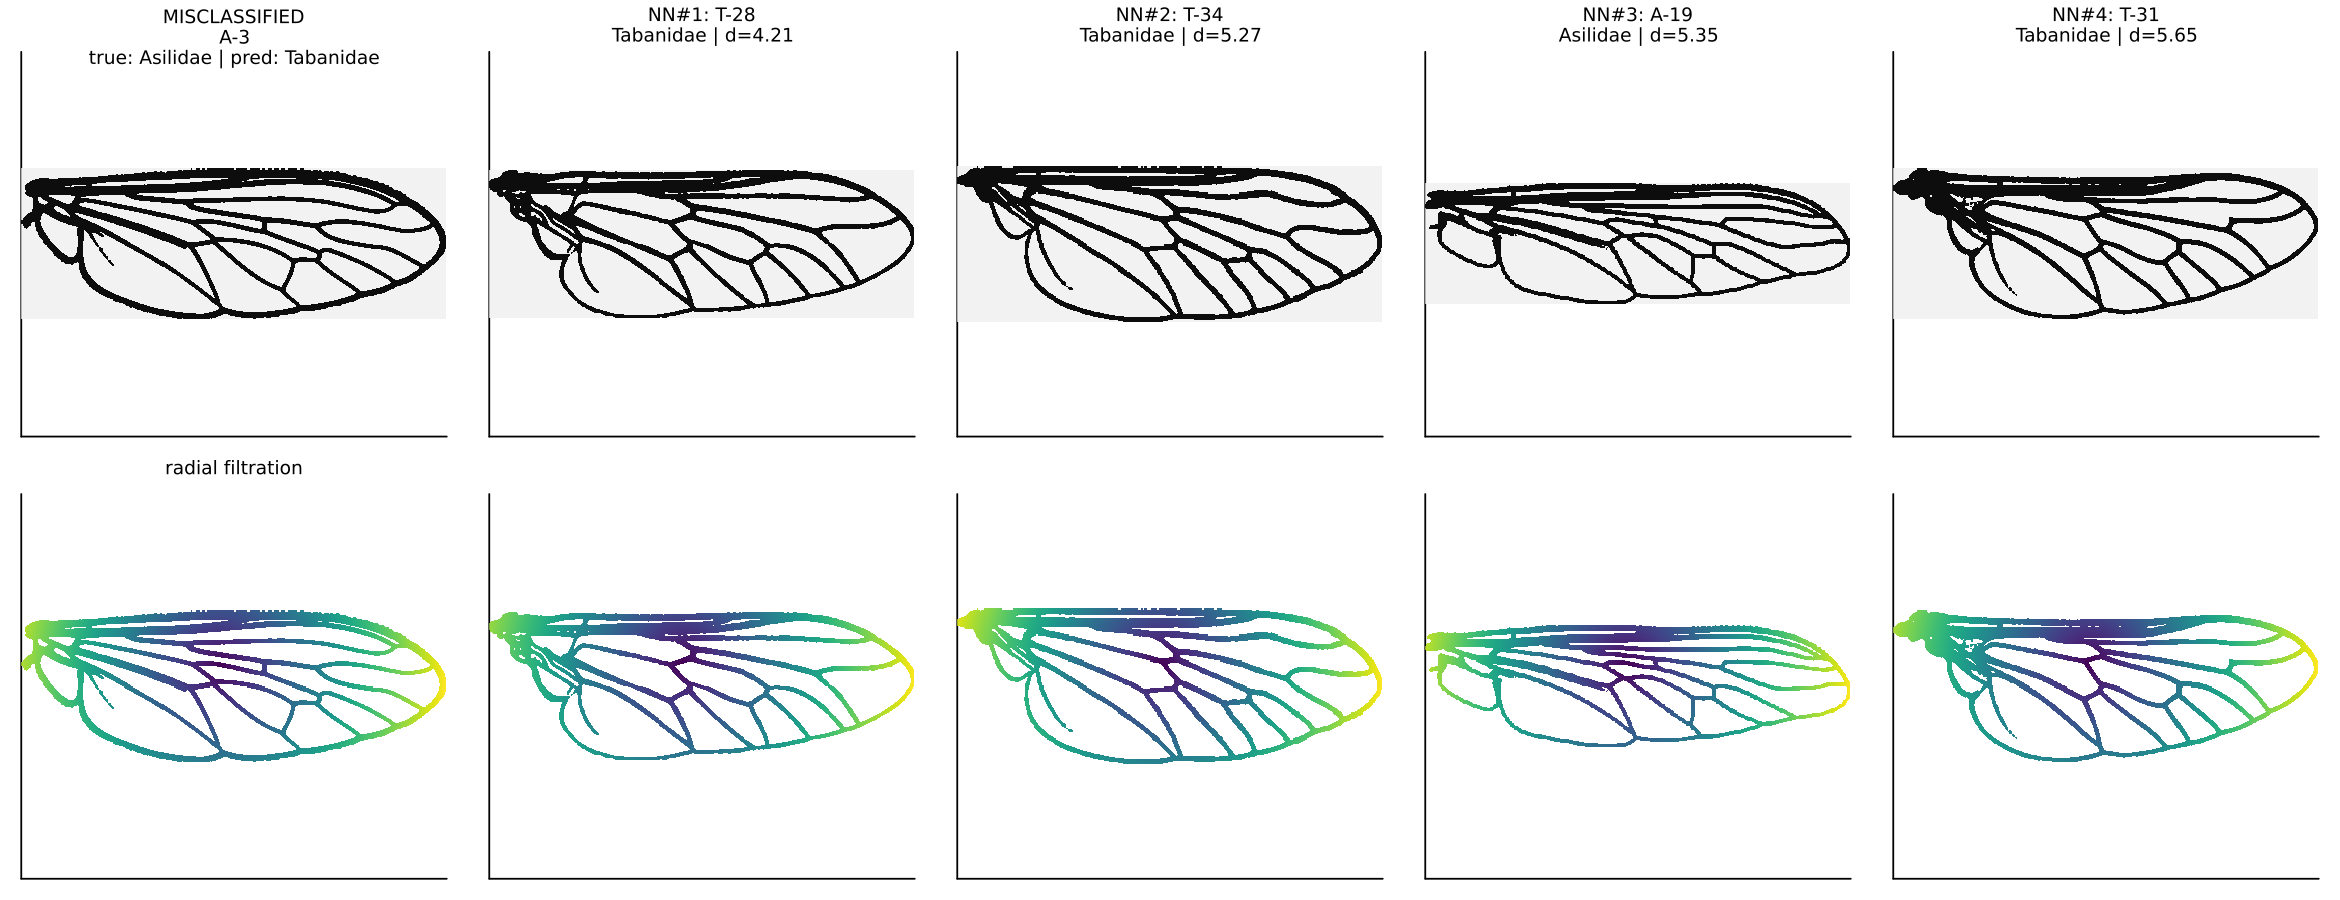


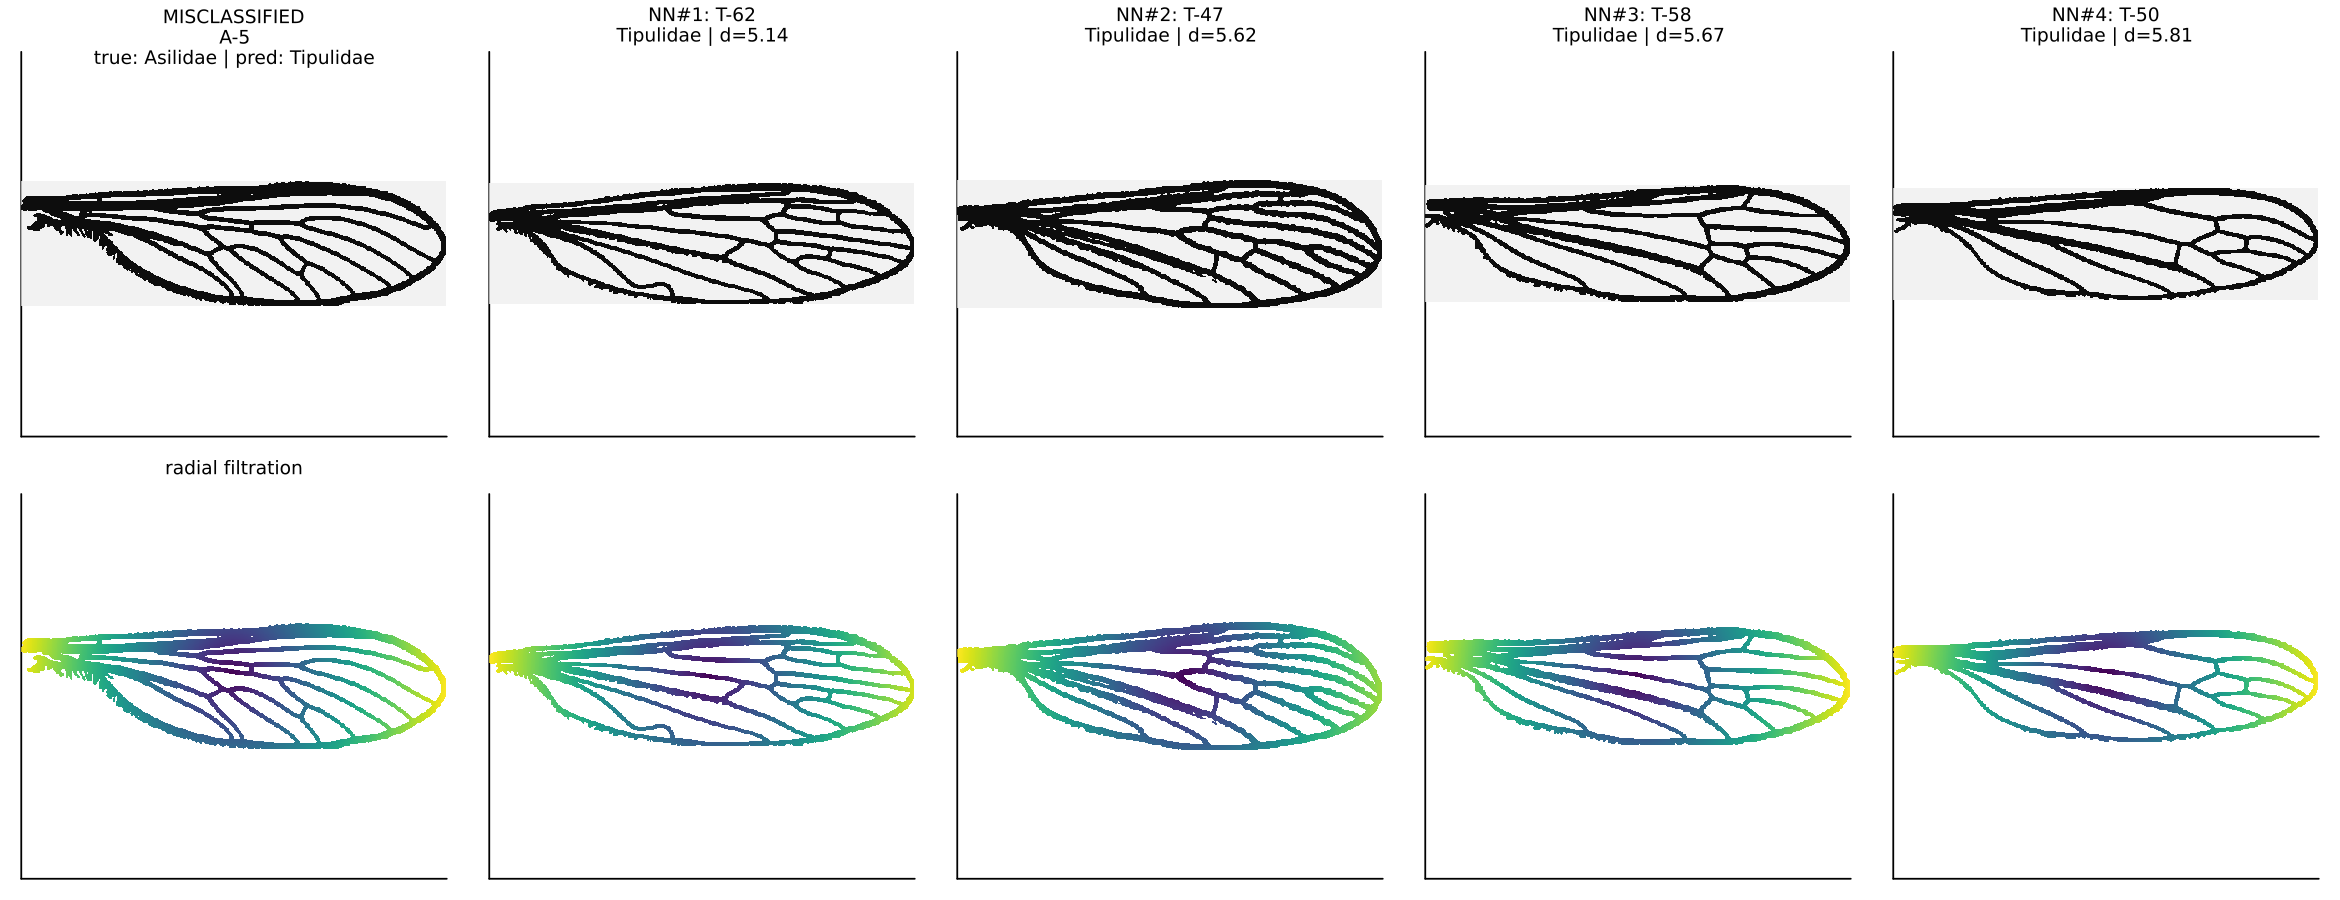


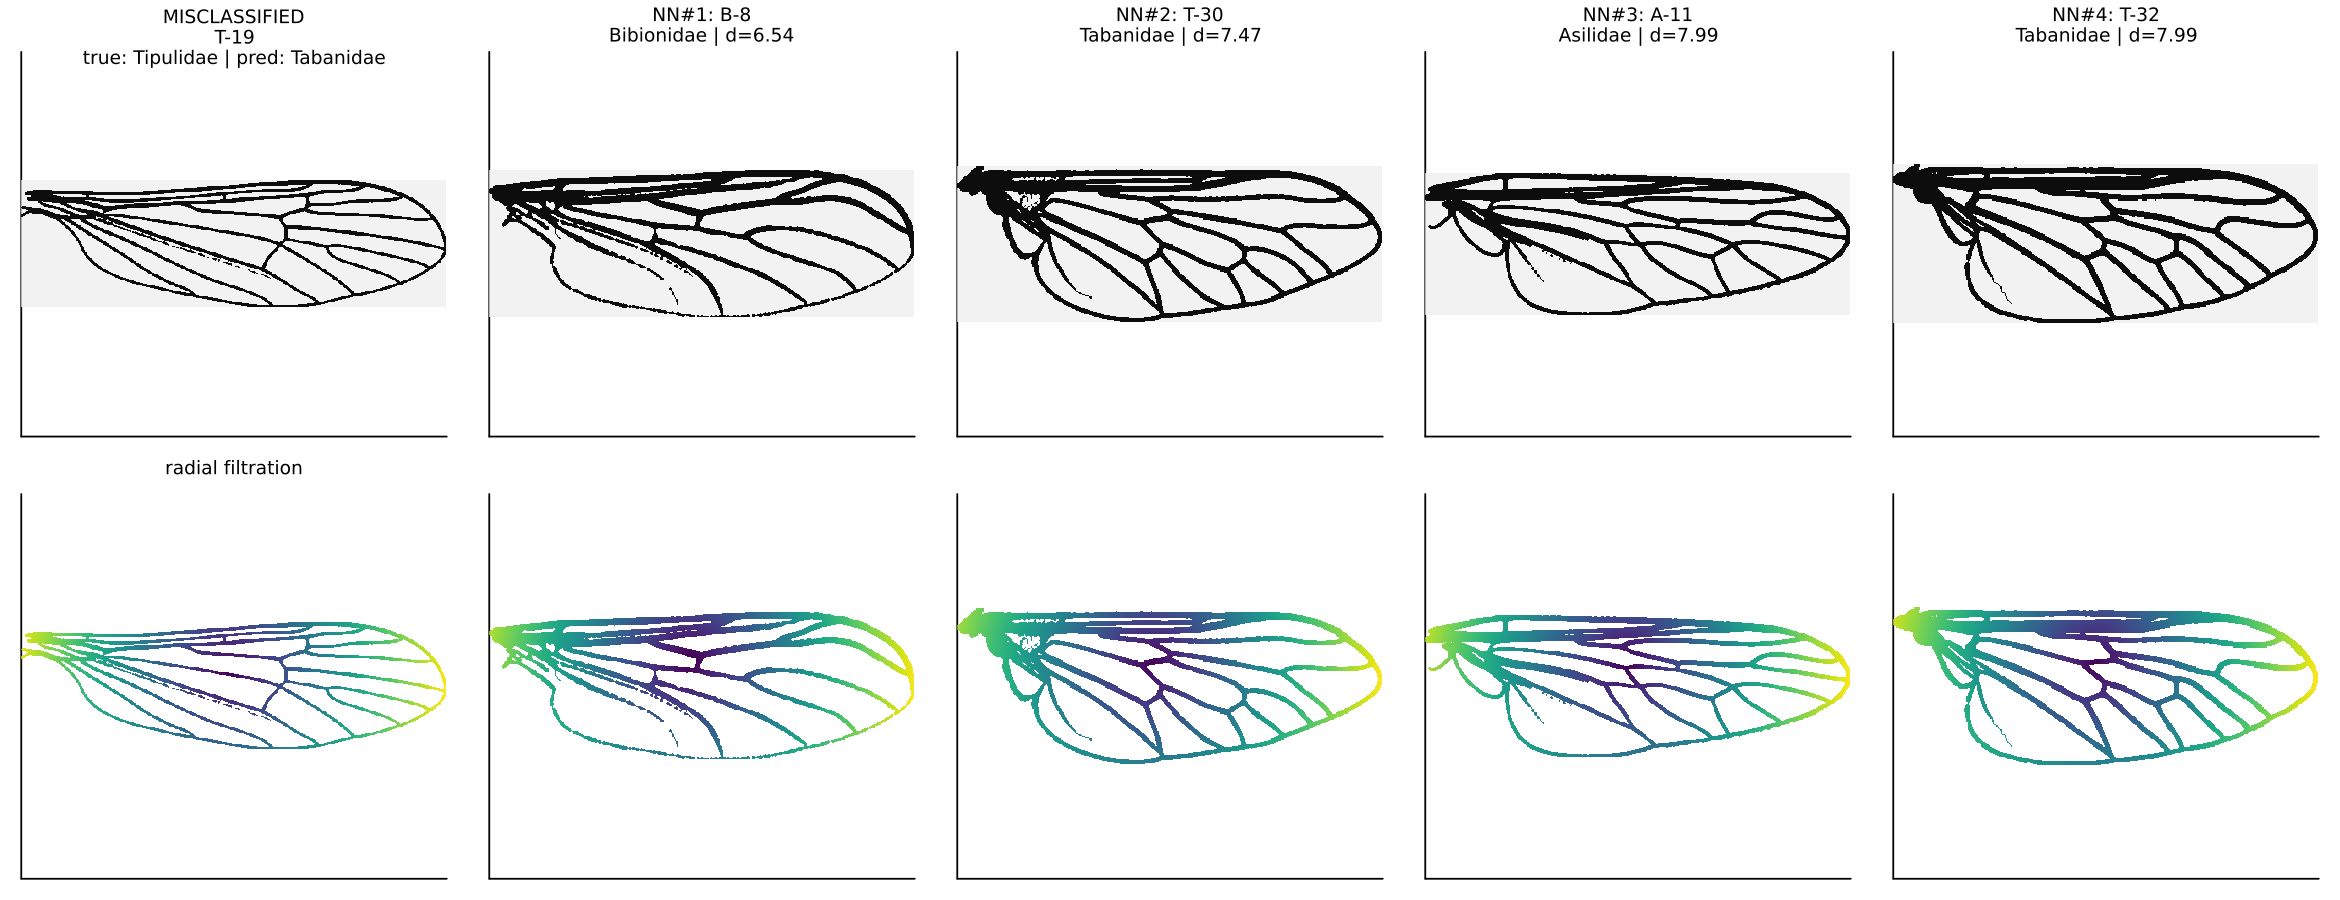


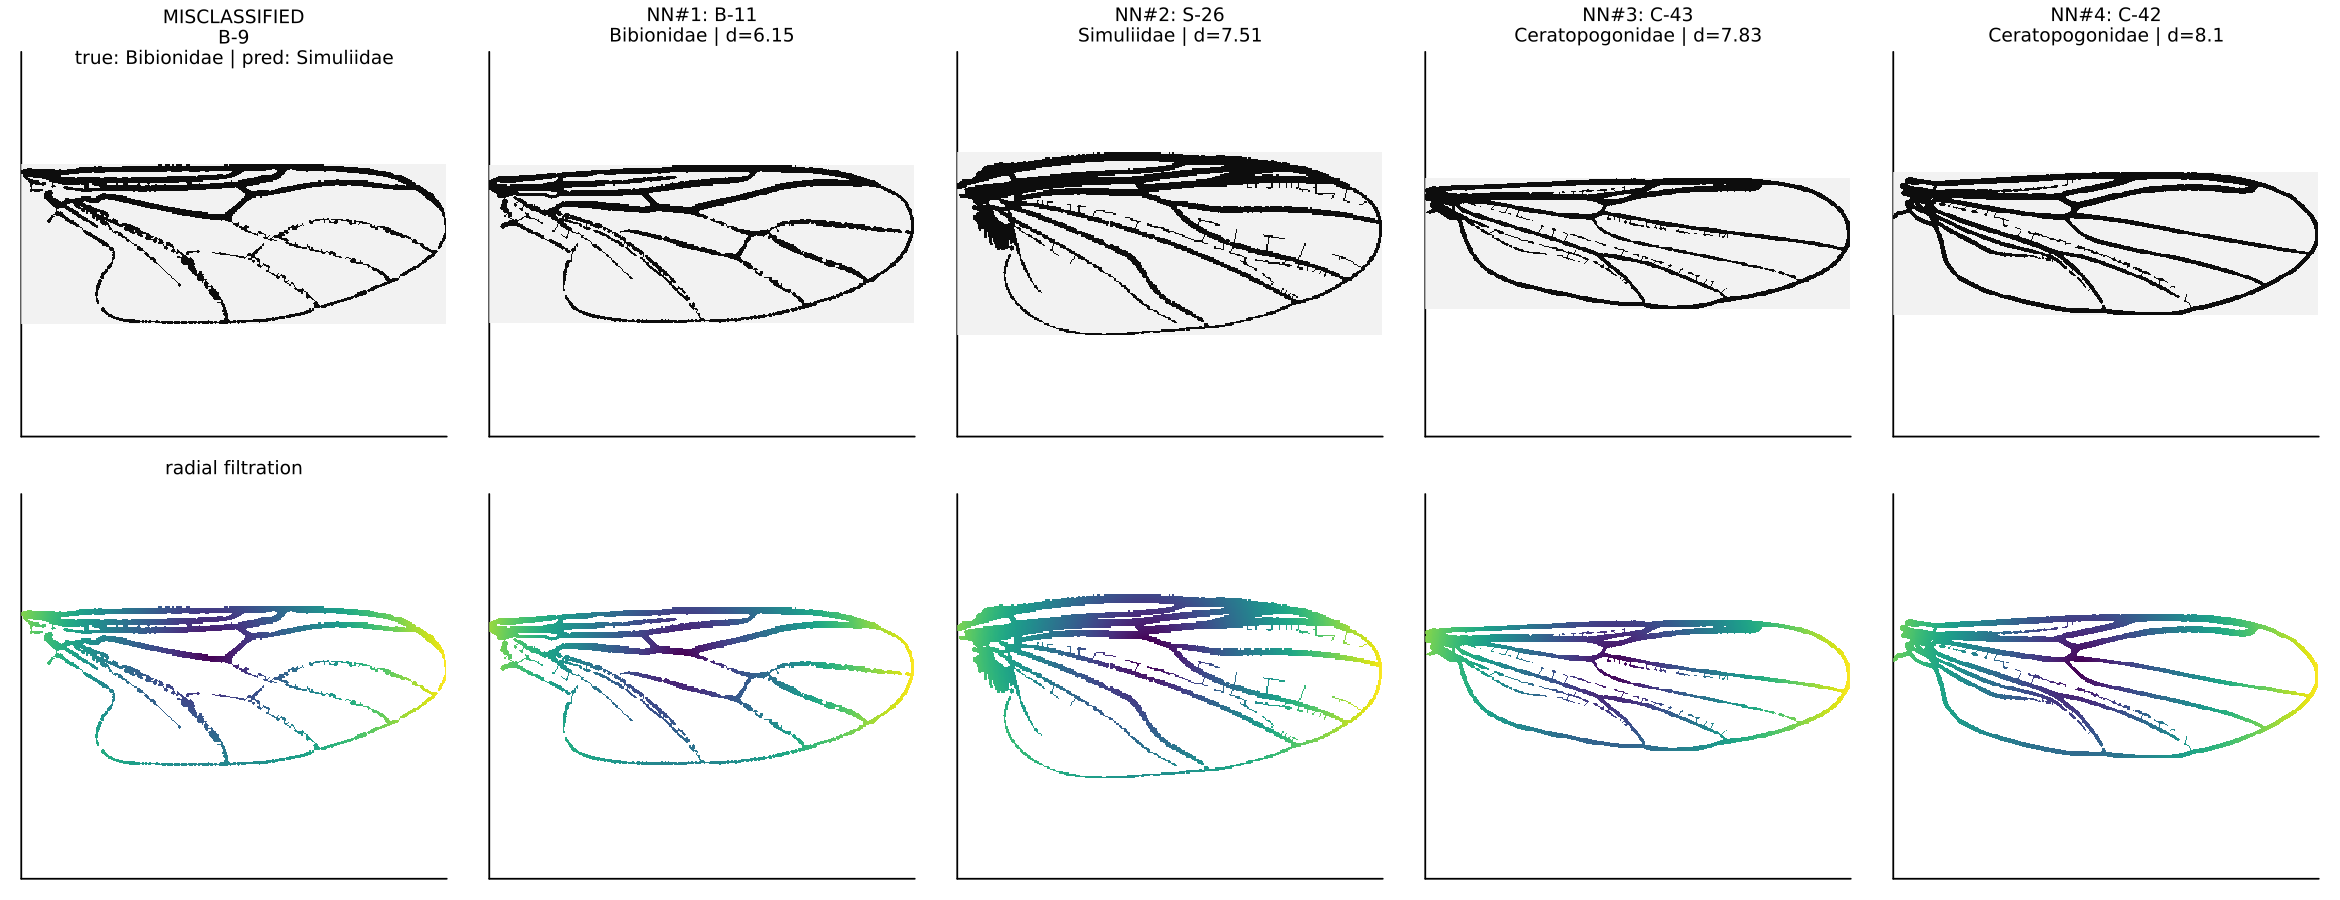


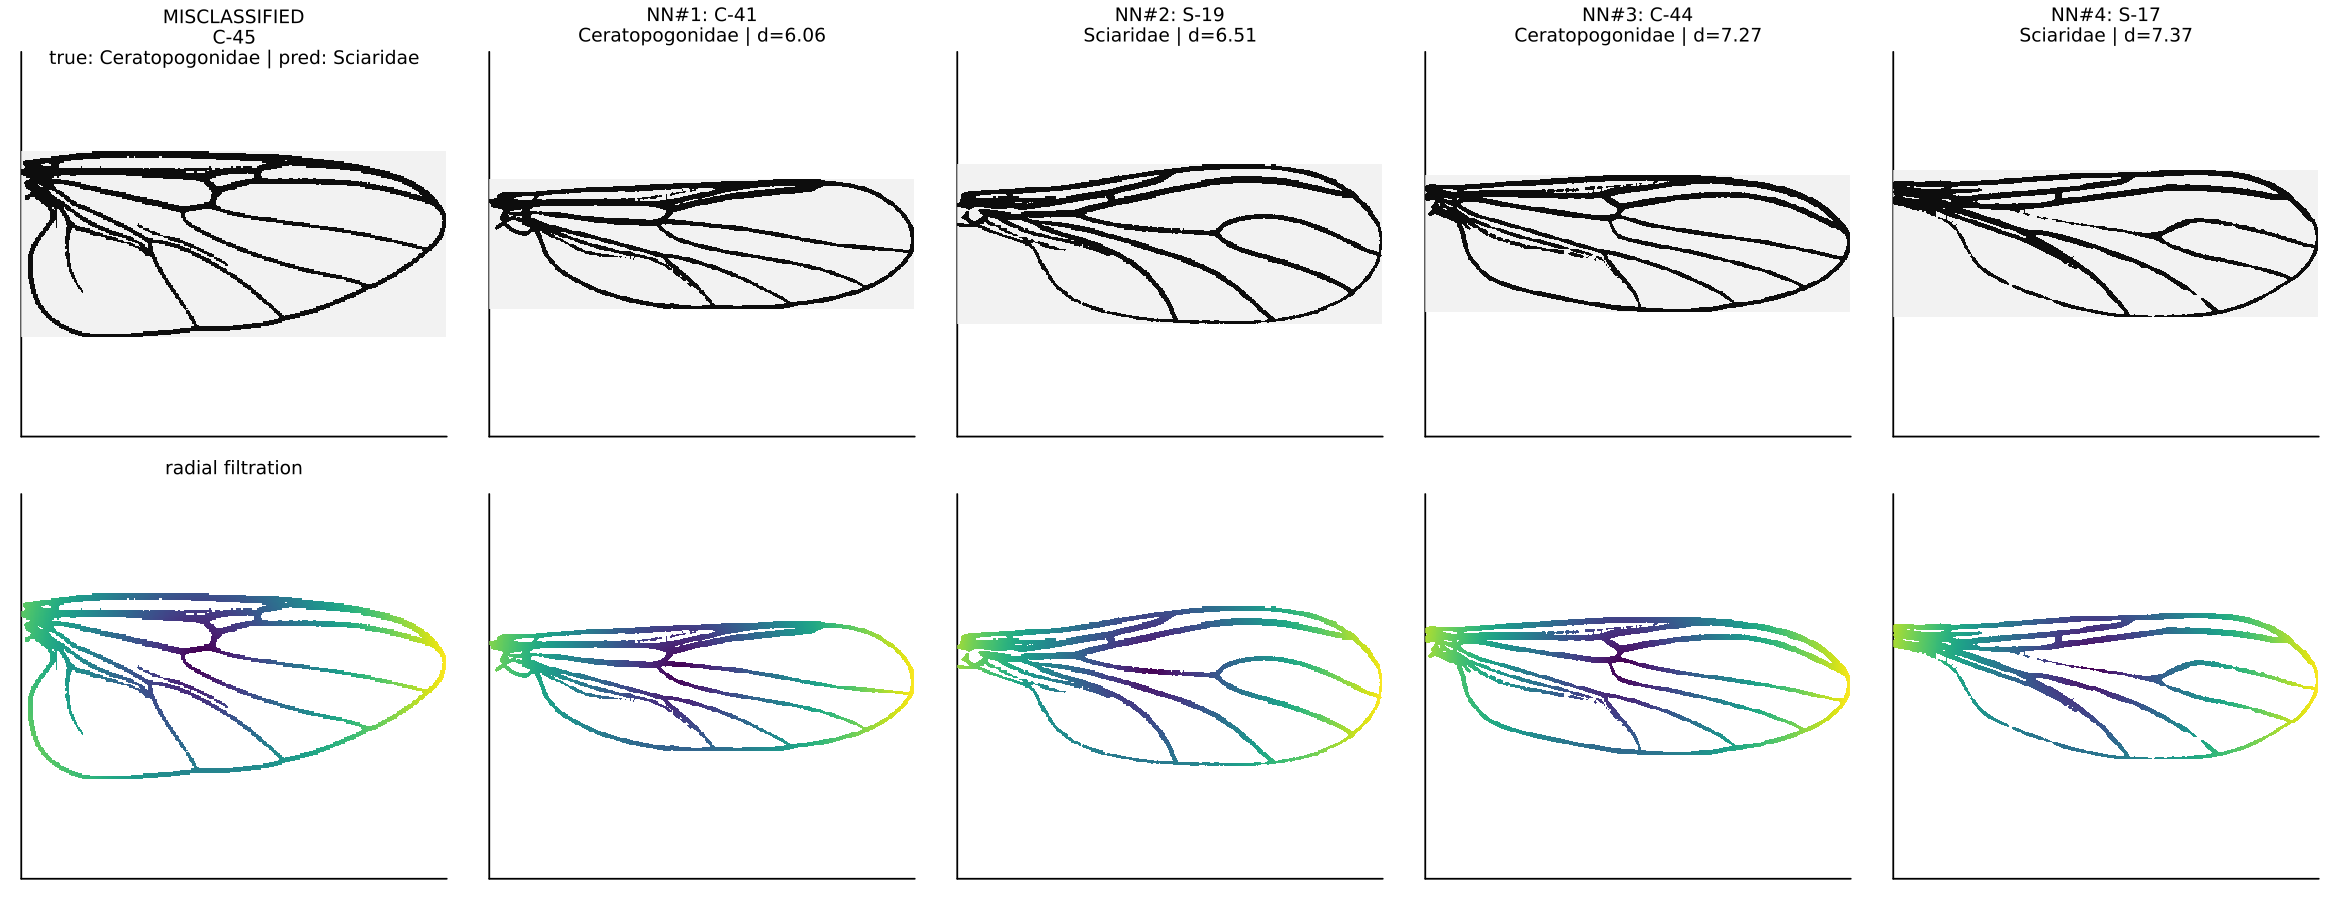


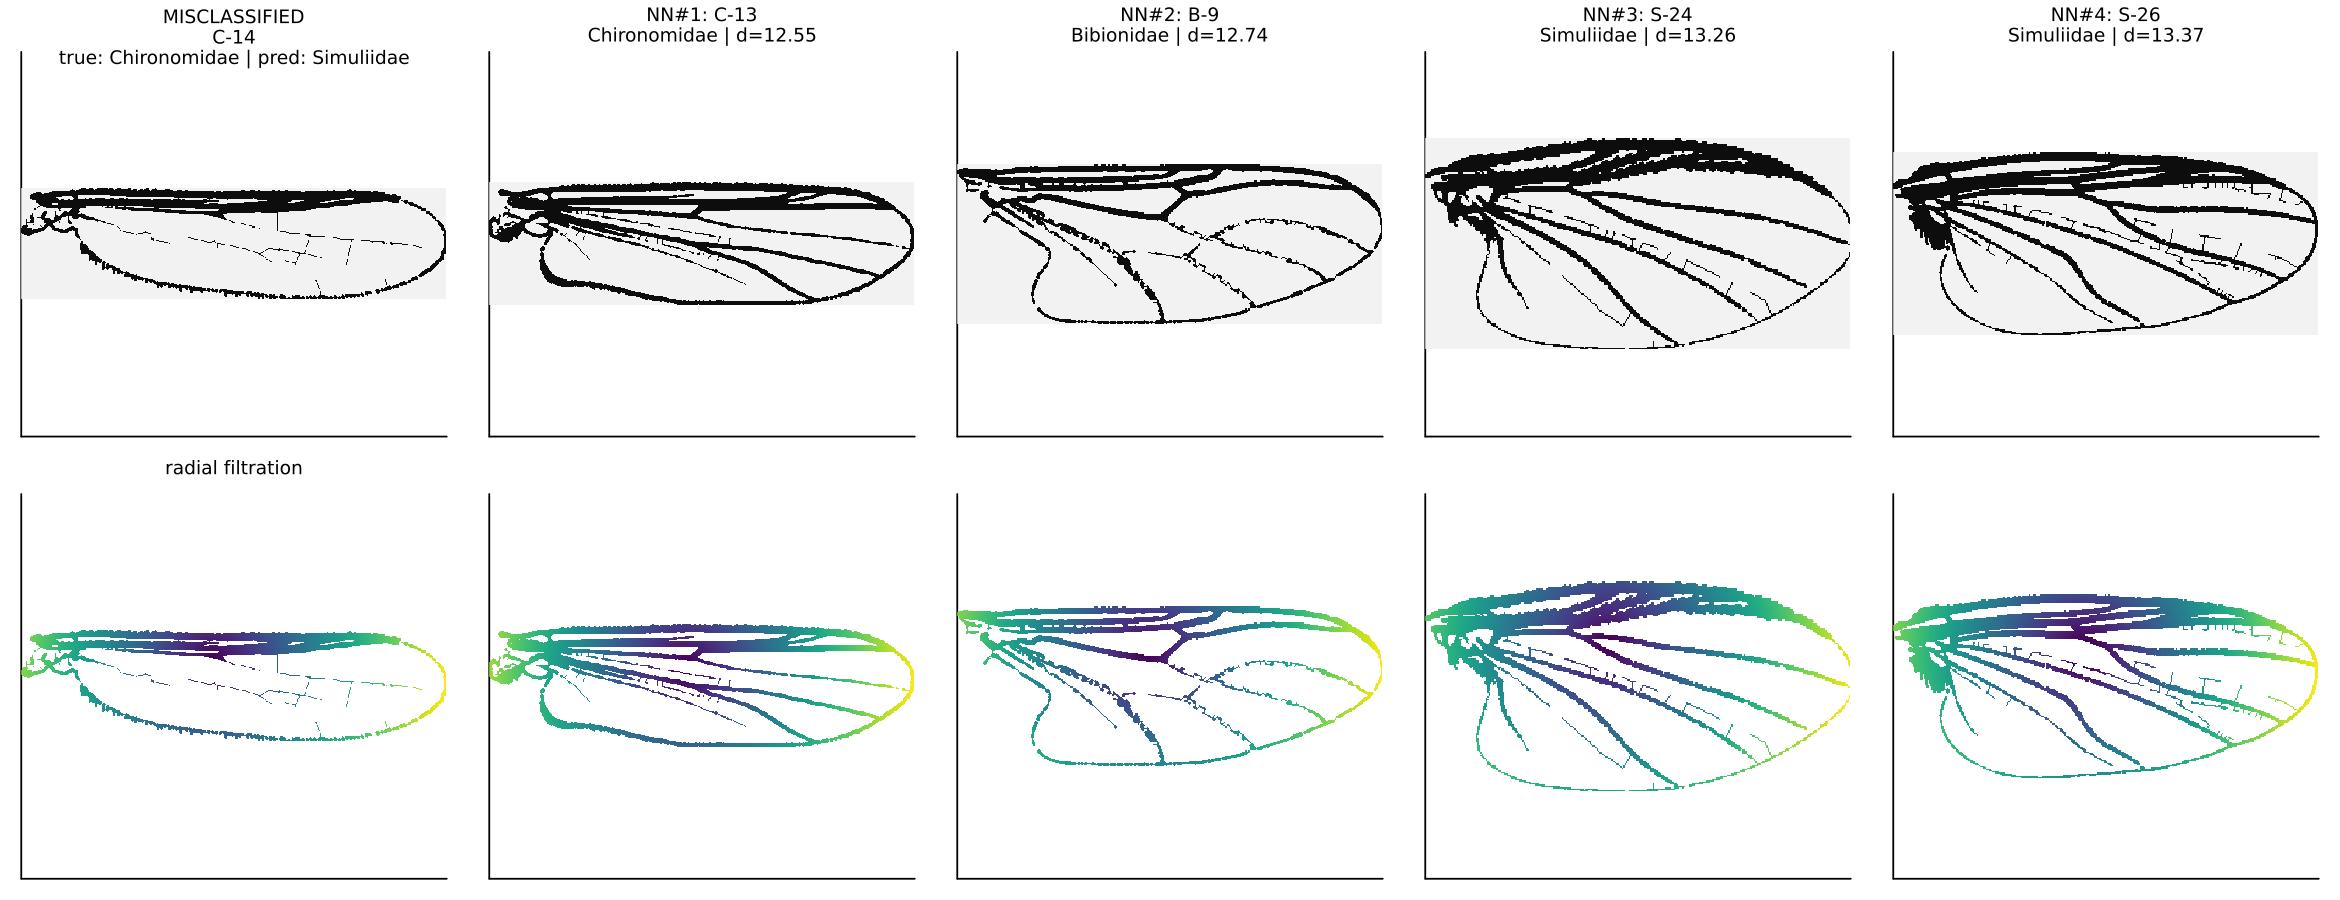


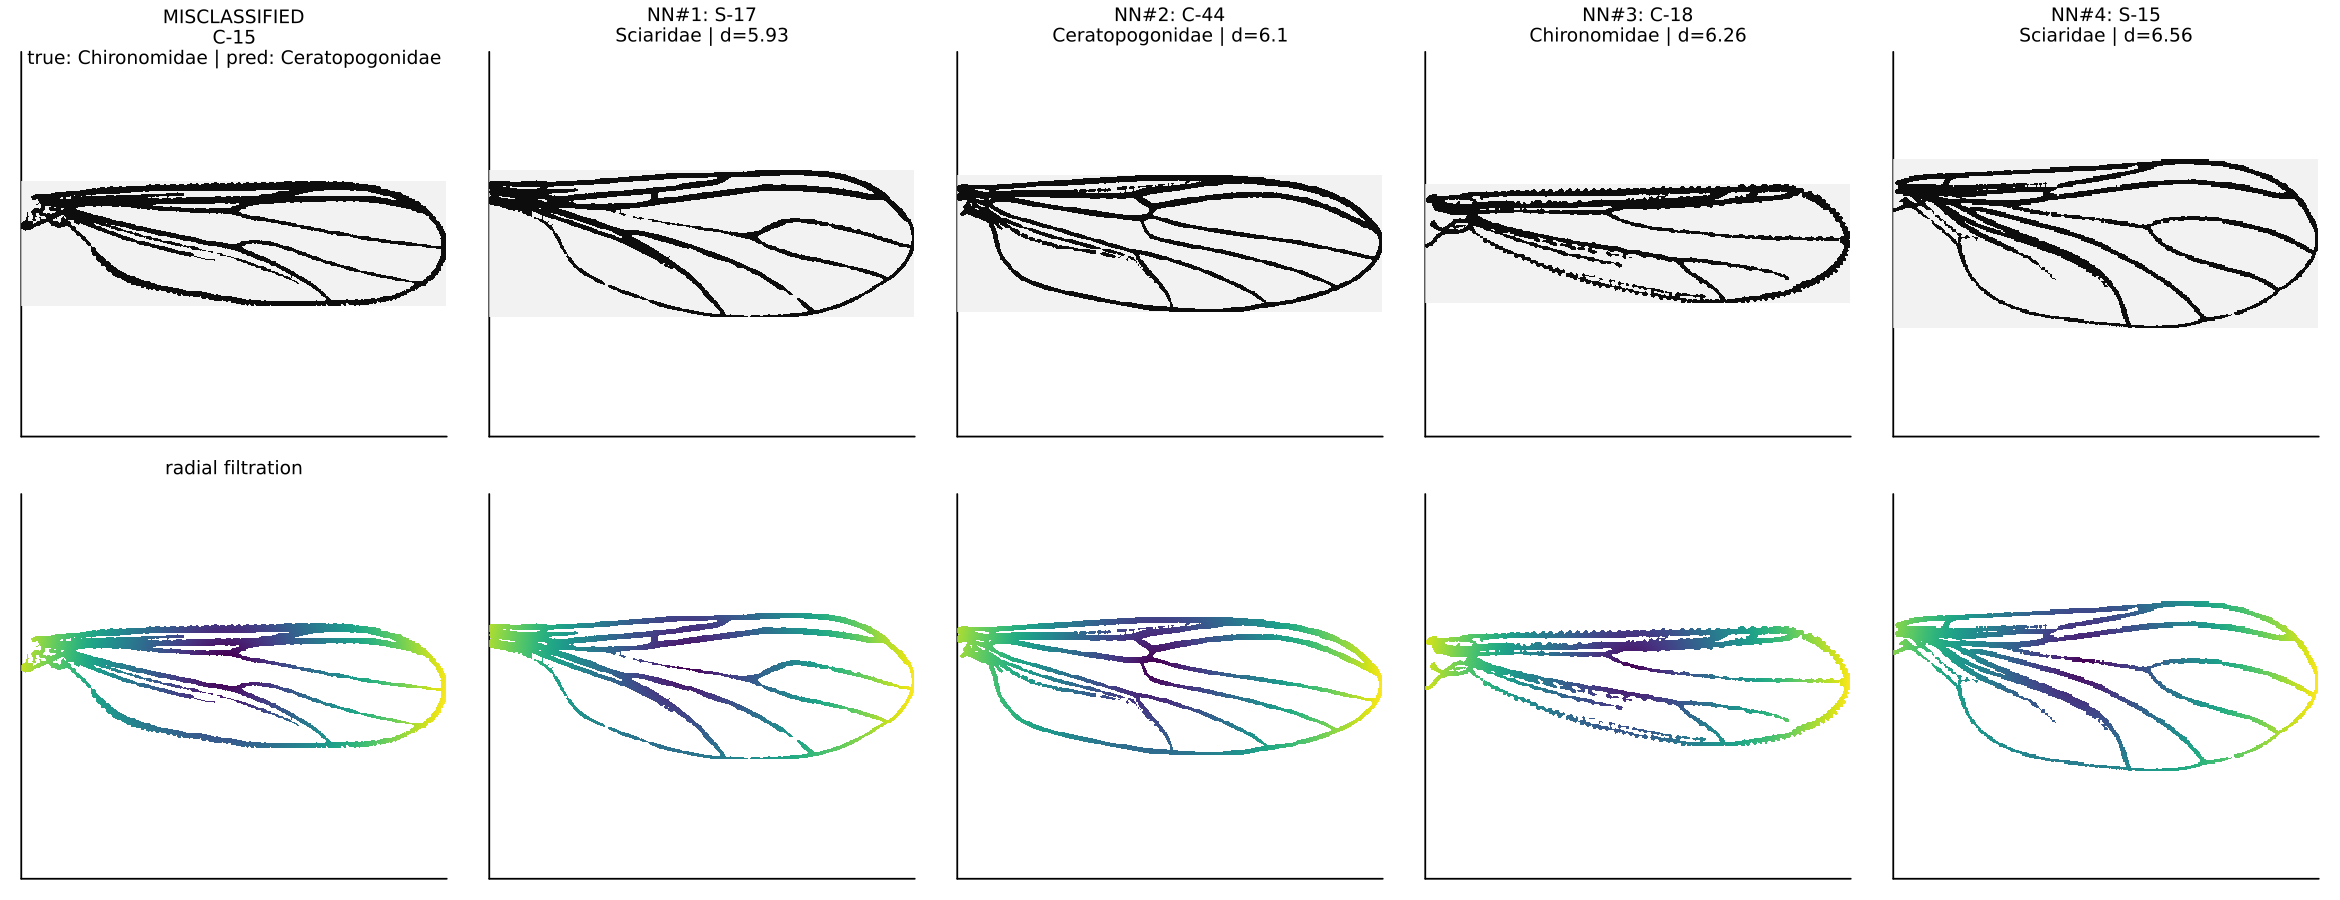


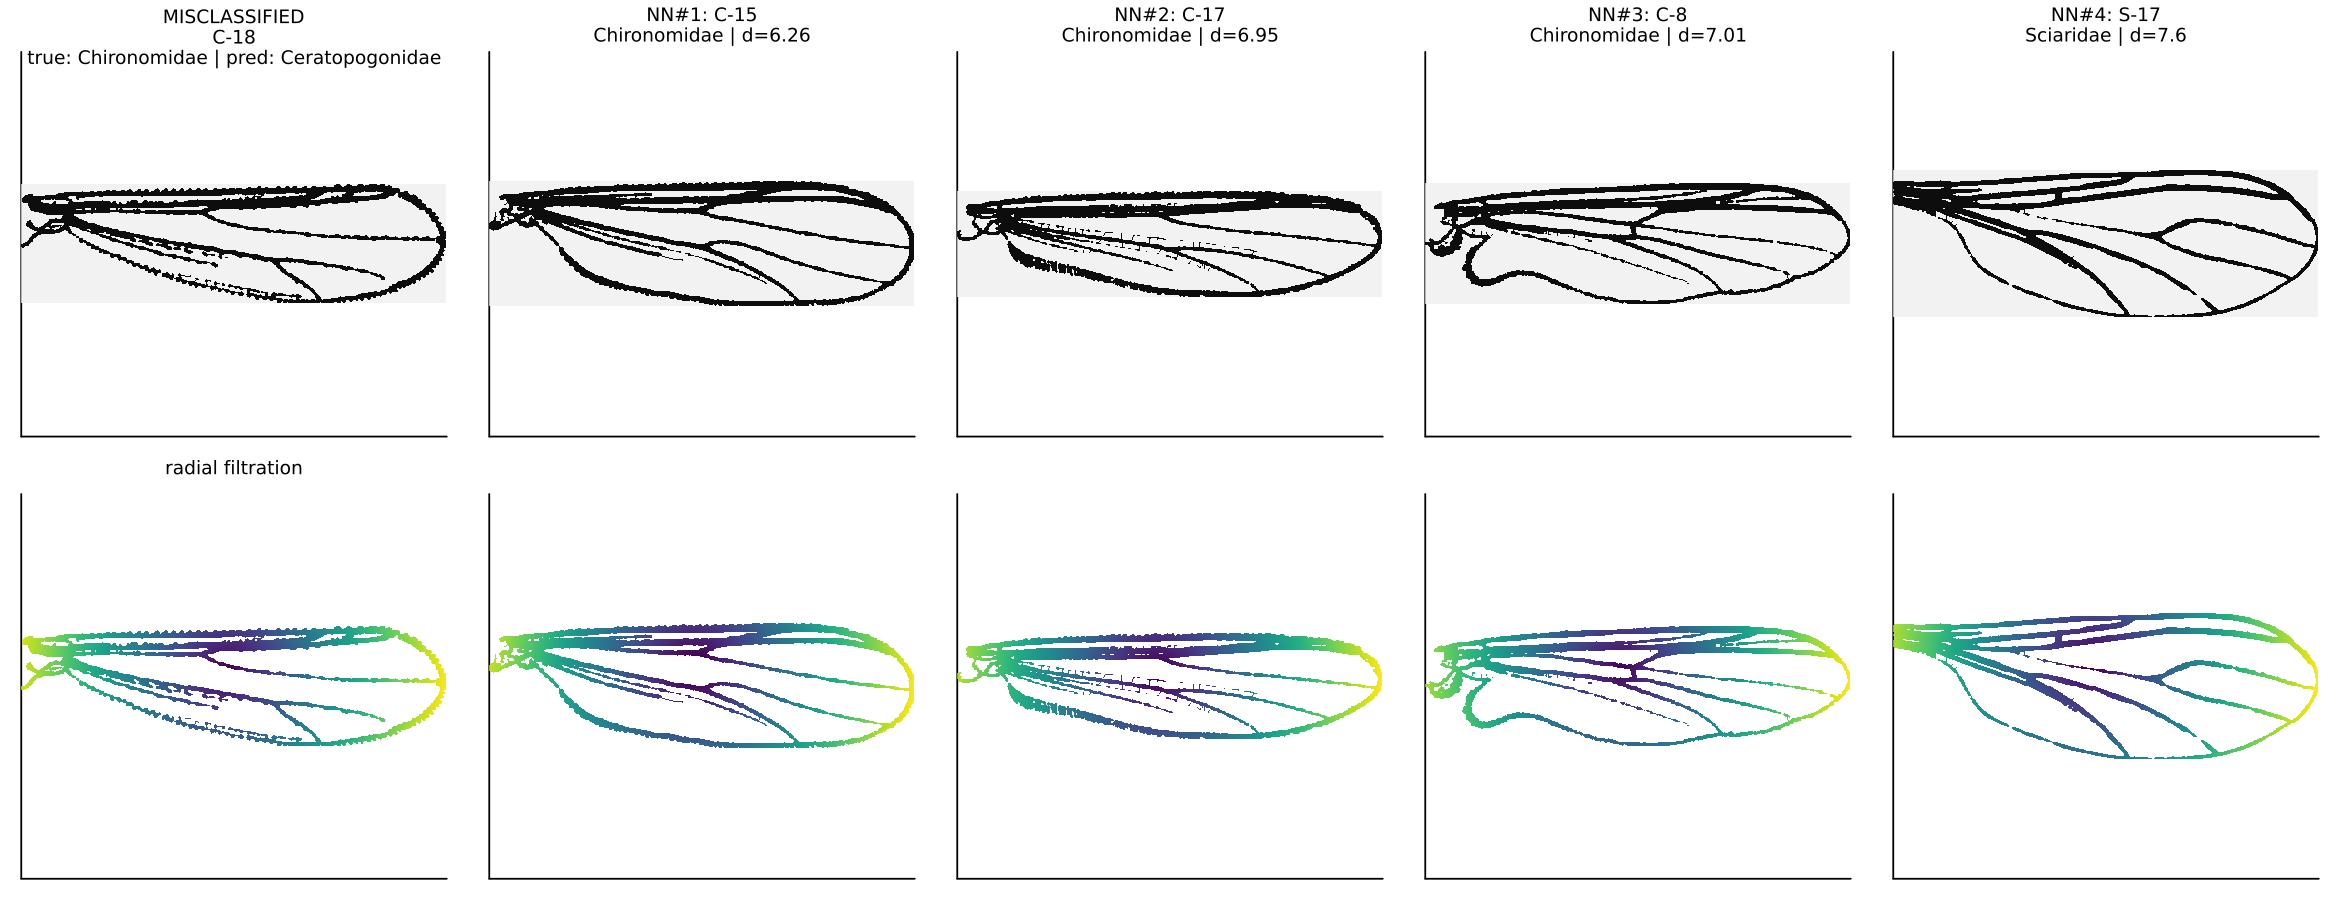


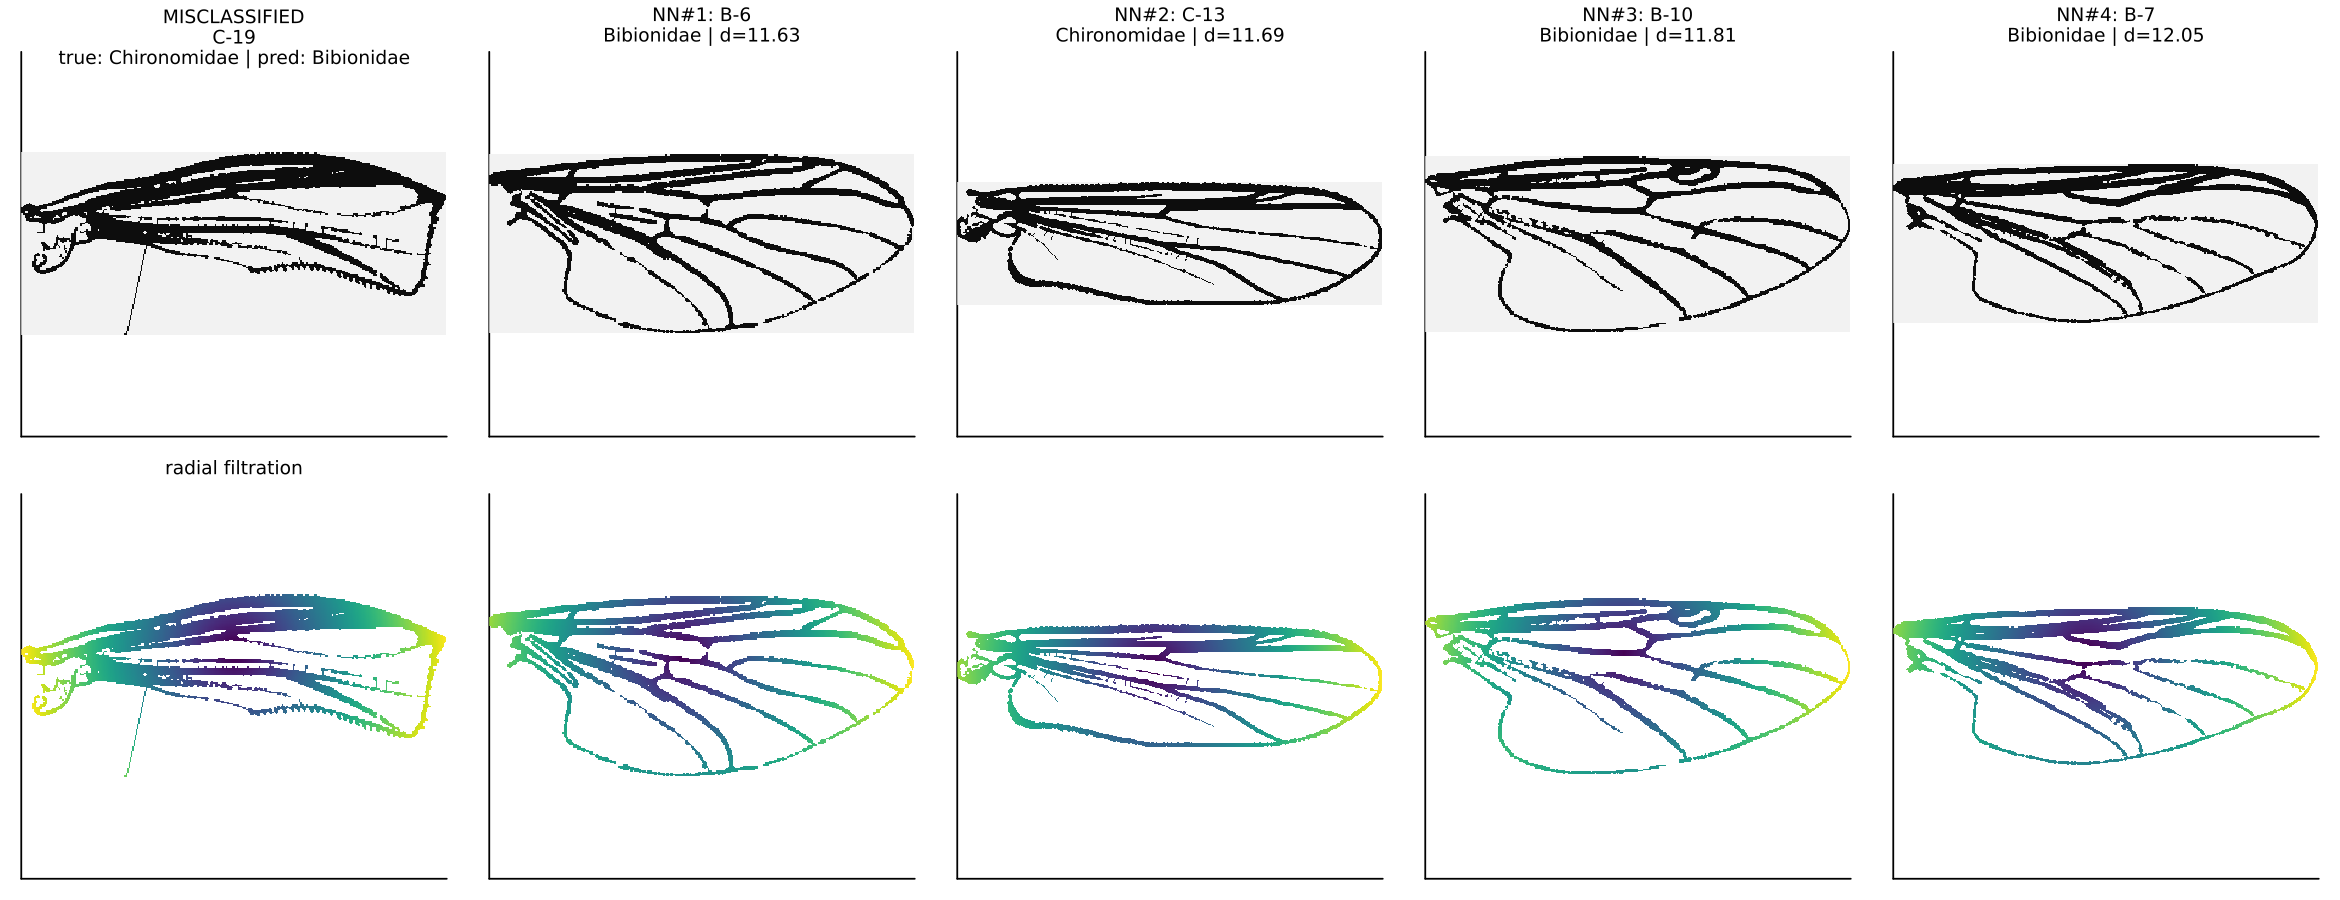


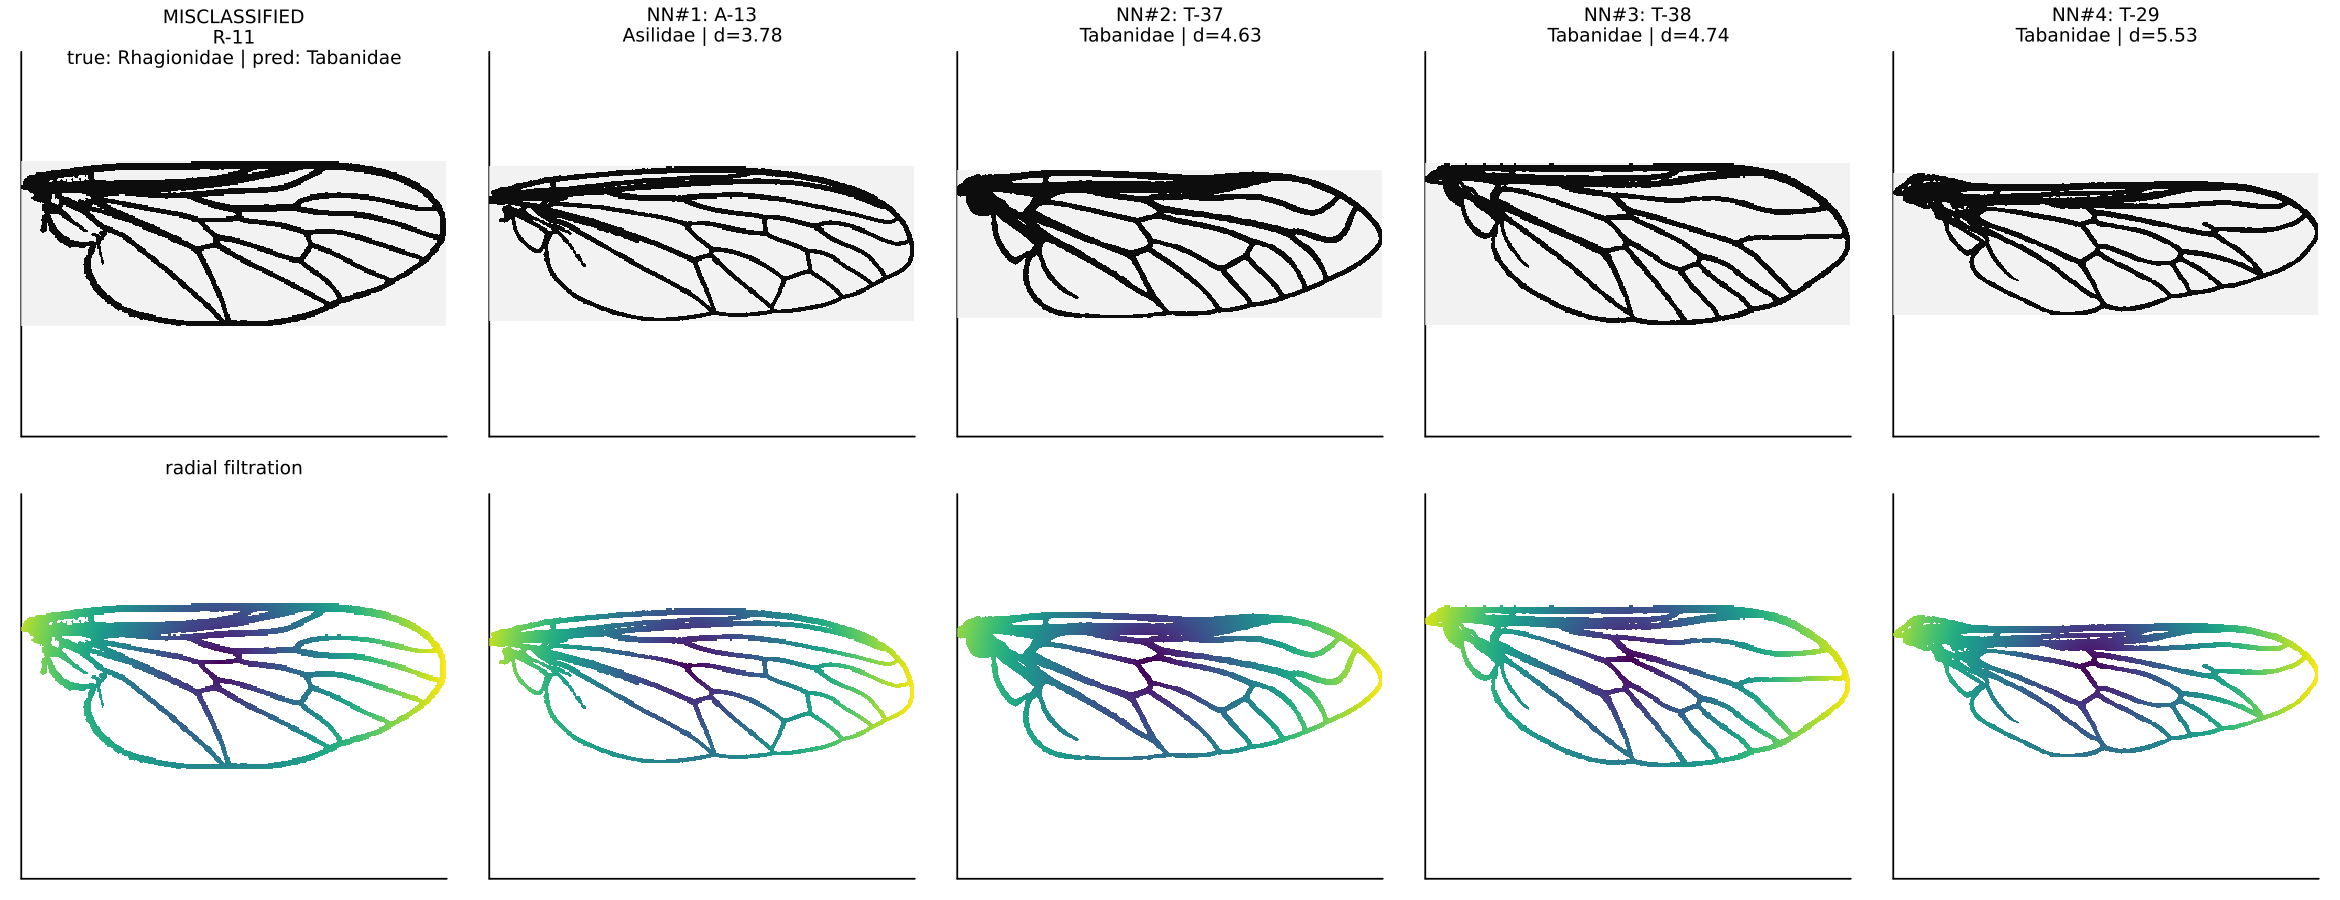


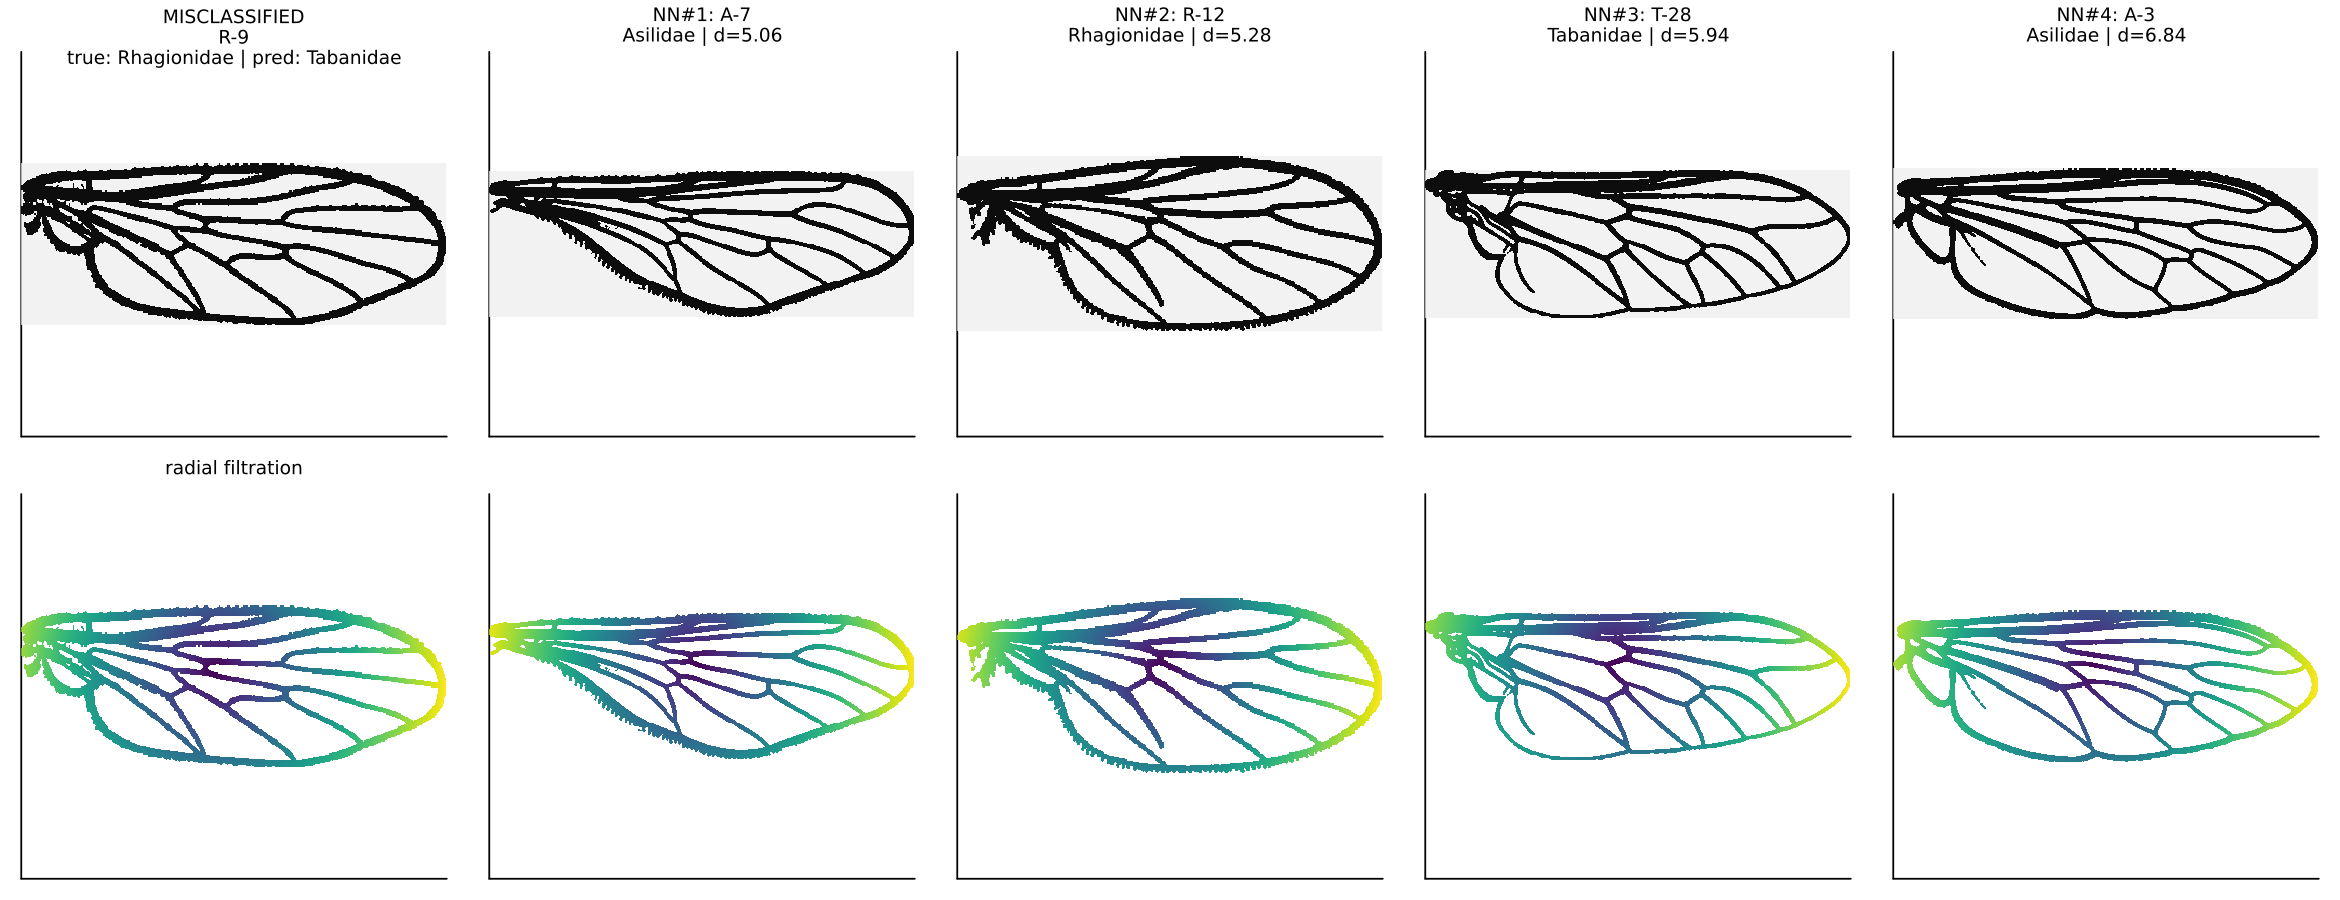


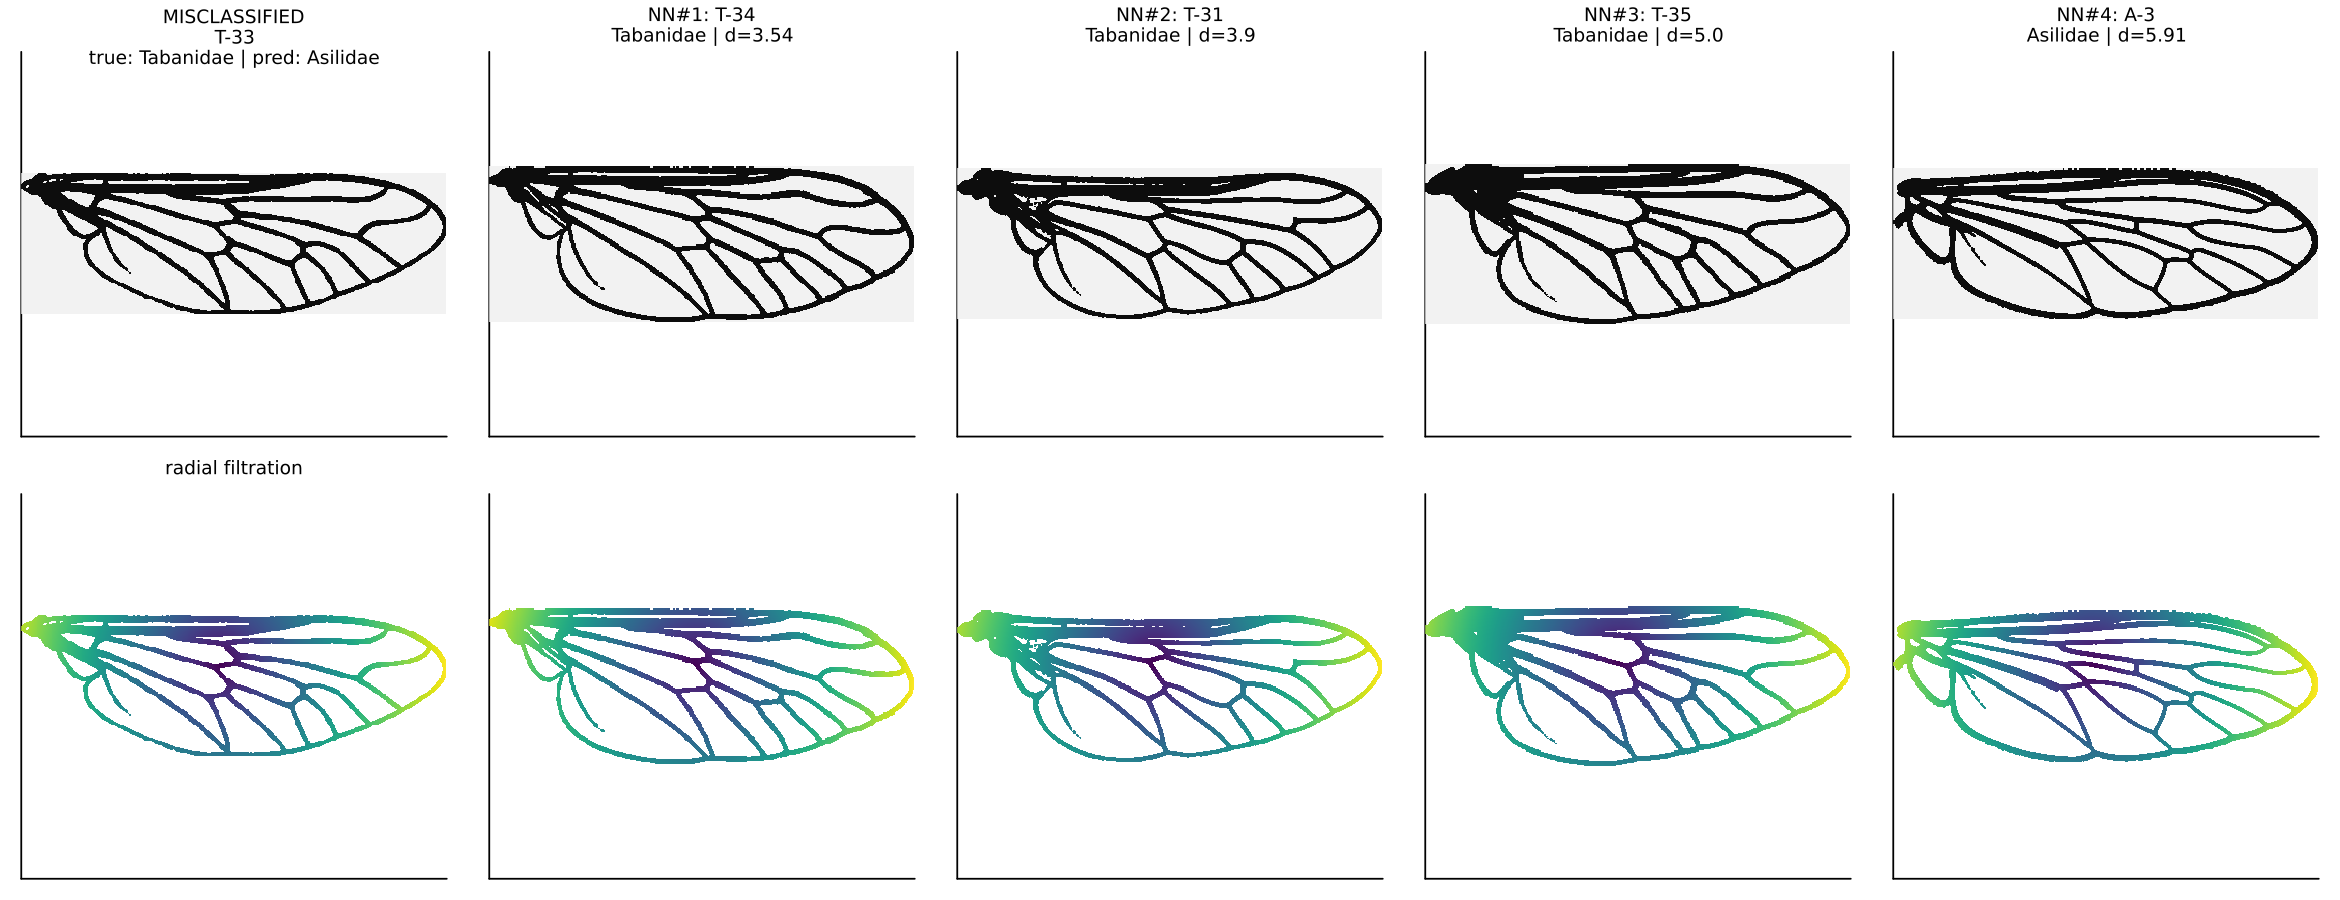


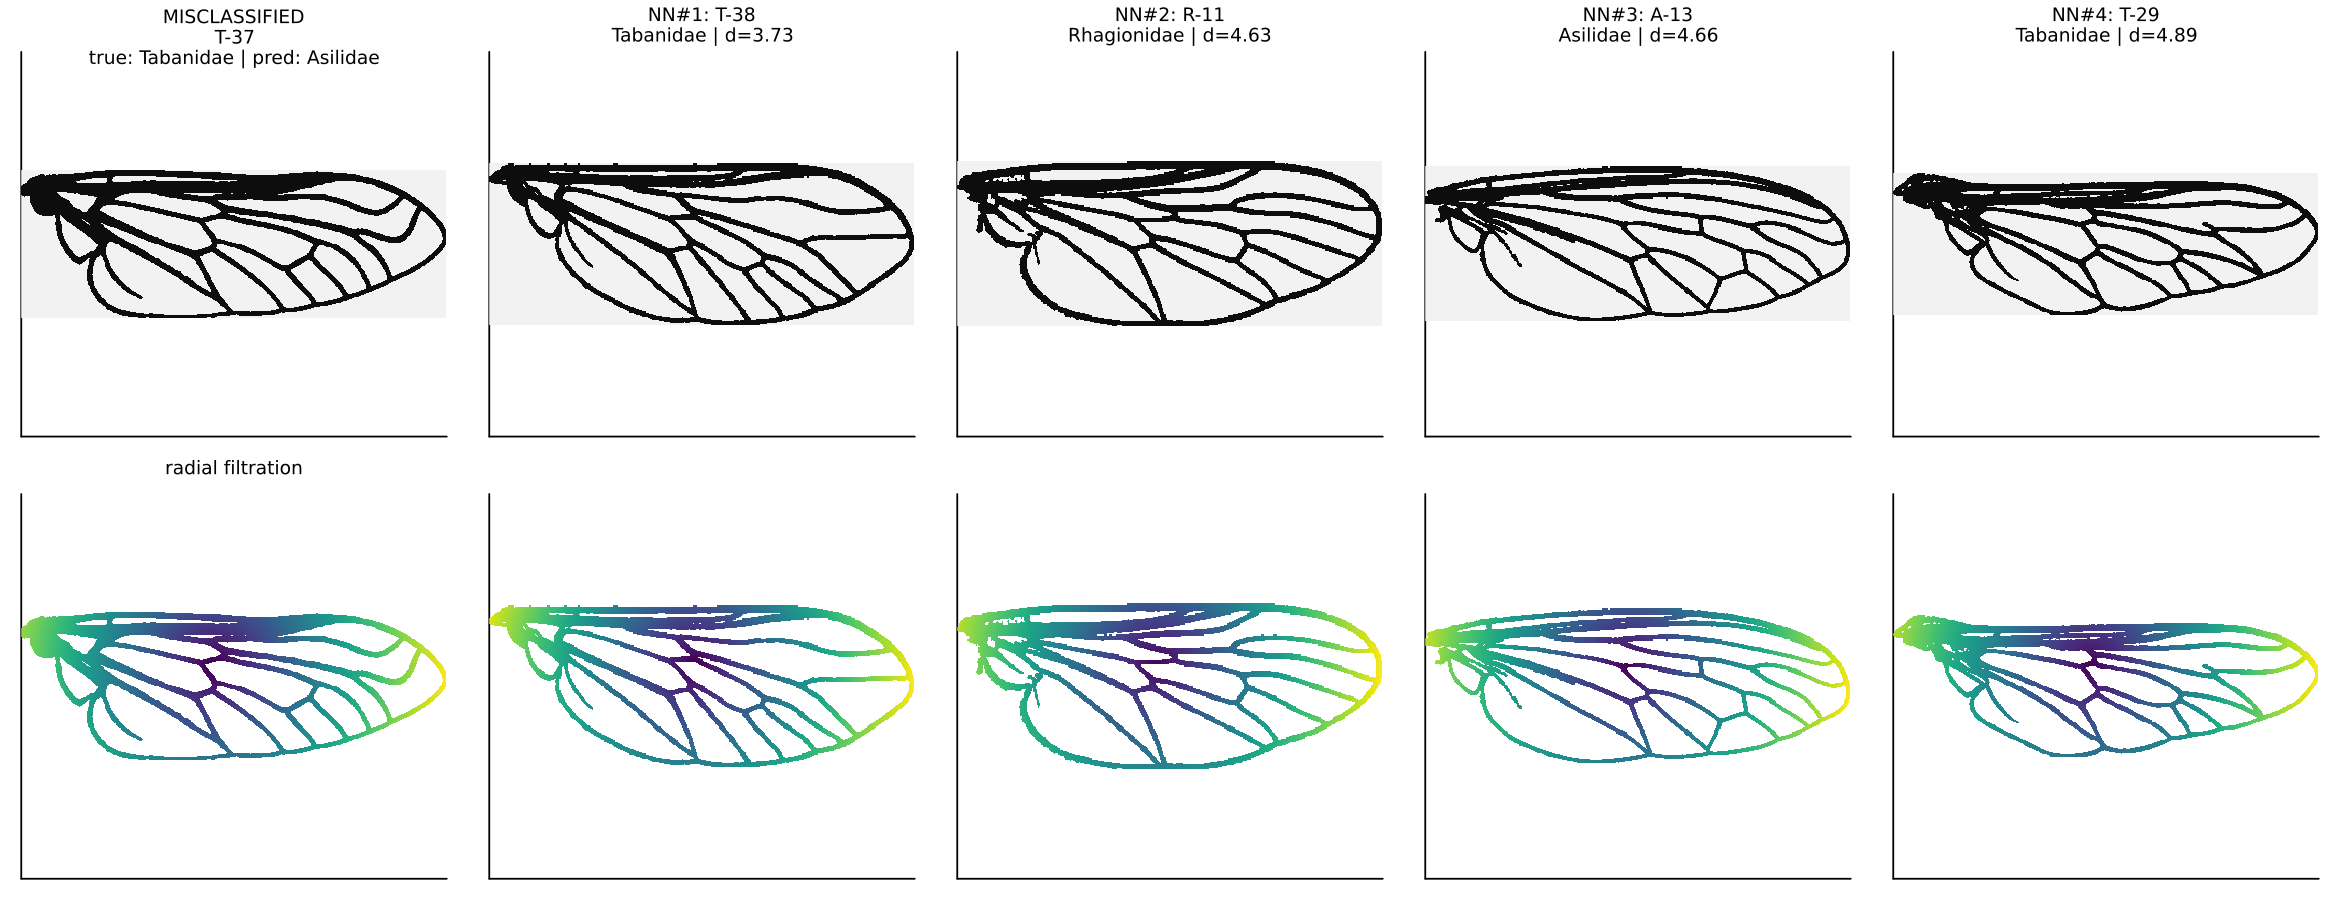

In [48]:
# For each misclassified wing, show 2 rows × (1 + K_NEIGHBORS) columns:
# (wing_panel / radial_panel are defined in the radial gallery section above)
#   top row    = wing image
#   bottom row = radial filtration
K_NEIGHBORS = 4
N_COLS = K_NEIGHBORS + 1

for idx in misclassified_idx
    dists = [(D_feat[idx, j], j) for j in 1:n_all if j != idx]
    sort!(dists)
    neighbor_idx = [j for (_, j) in dists[1:K_NEIGHBORS]]

    all_idx = [idx; neighbor_idx]
    titles = [
        "MISCLASSIFIED\n$(individuals[idx])\ntrue: $(labels[idx]) | pred: $(nested_rf.predictions[idx])";
        ["NN#$(k): $(individuals[nidx])\n$(labels[nidx]) | d=$(round(D_feat[idx, nidx], digits=2))"
         for (k, nidx) in enumerate(neighbor_idx)]
    ]

    wing_panels   = [wing_panel(i;   title_str = t) for (i, t) in zip(all_idx, titles)]
    radial_panels = [radial_panel(i; title_str = (i == idx ? "radial filtration" : "")) for i in all_idx]

    # Plots.jl fills layout = (2, N_COLS) row-by-row:
    # row 1 → all wing images, row 2 → all radial filtrations
    p = plot([wing_panels; radial_panels]...,
             layout = (2, N_COLS),
             size = (260 * N_COLS, 500))
    display(p)
end

In [49]:
best_row = results_df[1, :]
println("=== Best Method ===")
println("$(best_row.method): $(best_row.n_correct)/$(best_row.n_total) ($(round(best_row.accuracy * 100, digits=1))%)")
ci = wilson_ci(best_row.n_correct, best_row.n_total)
println("95% Wilson CI: [$(round(ci.lower * 100, digits=1))%, $(round(ci.upper * 100, digits=1))%]")

=== Best Method ===
SVM (Nested LOOCV): 56/70 (80.0%)
95% Wilson CI: [69.2%, 87.7%]

## 9 Discussion

We applied three TDA filtration strategies — Vietoris-Rips, radial, and directional — to classify Diptera families from wing venation images, extracting extended summary statistics per persistence diagram and removing low-relevance moments (skewness and kurtosis).

### 9.1 Key findings

1.  **Three filtrations capture complementary information**: The Vietoris-Rips filtration on point-cloud samples captures the **global loop structure** of the wing venation (number and prominence of wing cells). The radial H0 filtration captures the **center-to-periphery organization**: how vein segments merge as the filtration grows outward from the centroid. The directional H0 filtrations capture **vein connectivity along four axes** (horizontal, vertical, and both diagonals), encoding how disconnected components merge under directional sweeps.

2.  **Pruned extended statistics remain sufficient**: After removing skewness and kurtosis, we retain 17 statistics per diagram (count, max/total persistence, quantiles, entropy, median birth/death, etc.). With 6 diagrams × 17 features = 102 total features for 72 samples, the feature-to-sample ratio is ~1.42:1, reducing overfitting risk while preserving discriminative signal.

3.  **Feature ablation reveals which filtrations matter**: The ablation study compares Rips alone, radial H0 alone, directional H0 alone, and their combinations. This provides evidence about whether global topology (Rips), radial organization (radial H0), or directional sweep information (directional H0) is most discriminative.

4.  **Why some filtrations were dropped**:

    -   **Radial H1**: On pixelated binary images, few genuine 1-cycles survive the radial filtration, making radial H1 mostly noise.
    -   **EDT (Euclidean Distance Transform)**: On binarized images, the EDT is trivially related to the binary structure, providing little additional information beyond what Rips already captures.
    -   **Cubical (grayscale sublevel-set)**: After binarization, the grayscale information is lost, so cubical persistence reduces to computing persistence on a binary image — equivalent to connected-component analysis.

5.  **Nested LOOCV provides honest evaluation**: Standard LOOCV can be optimistic when hyperparameters are tuned on the same data. Nested LOOCV (with 4-fold inner CV for hyperparameter selection) gives unbiased accuracy estimates.

6.  **Statistical rigor**: We report LOOCV accuracy with Wilson confidence intervals, and nested LOOCV for unbiased evaluation.

### 9.2 Limitations

-   **Class imbalance**: Tipulidae has 12 samples while some families have only 2–3, which affects classifier performance.
-   Image quality and preprocessing parameters (blur, threshold) influence topological features.
-   With only 72 samples, confidence intervals remain wide regardless of method.
-   Wings are manually segmented and binarized; automated segmentation could introduce different error patterns.

### 9.3 Future work

-   Extend dataset with more specimens per family, especially underrepresented ones
-   Improve imaging/segmentation quality to reduce noise
-   Apply extended persistence or zigzag persistence for richer invariants
-   Investigate which specific topological features (e.g., how many loops, persistence of largest features) correspond to known vein characters in Diptera taxonomy
-   Try the analysis on non-binarized (grayscale) images, where EDT and cubical filtrations would be more informative
-   Explore directional H1 persistence on higher-quality images where loop detection under sweeps may be more reliable